# Imports


In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics.cluster import mutual_info_score
from sklearn.cluster import KMeans
from scipy.stats import entropy
import copy
import pandas as pd
import math
import matplotlib.pyplot as plt
import os
import pickle
import itertools
import numpy as np
import random
from pandas.arrays import SparseArray
import seaborn as sns
from scipy.stats import spearmanr
from scipy.stats import f


# Transformer


## getTrainingData


In [3]:
def getTrainingData(songStrings,nrOfSongs):
    notes=list("ABCDEFGH")
    chord=[[0],
           [1],
           [2],
           [3],
           [4],
           [5],
           [6],
           [7]]
    source=[]
    target=[]
    song=[]
    for s in range(nrOfSongs):
        for i in range(42):
            sentence=[]
            answer=[]
            song.append(s)
            for j in range(41):
                sentence.append(chord[notes.index(songStrings[s][(i+j)%42])][0])
                answer.append(chord[notes.index(songStrings[s][(i+j+1)%42])][0])
            source.append(sentence)
            target.append(answer)
    return numpy.array(source),numpy.array(target),numpy.array(song)

songStrings = numpy.array([
    "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC",
    "ABCDEFABCDEFABCDEFABCDEFABCDEFABCDEFABCDEF",
    "ABACADAEAFABEFADECBABCFEDEFABCADEBACADFABE",
    "DBCACBCFFDCEFFEFCDDEFEBEACFECBBBCBECBFDAFB",
    "ABEBCAEFCDFFBCBDBBBCEDCBFBFFECBCEBCAAFFADB",
    "BEEFBAFDAEAAEFDBDFDEFCACEBCCDACEACACEEDBAA",
    "BFEBFEEBDBCFEAACAAAFDFCBFBFEAACFFCAABCEDDC",
    "BADDFFEADBEDFDFBEBCCADEFDEABBFDEFFEBEEFDEF",
    "ABFFEDBDBFECEDEAEBBEECFDDAEDCDBBFCADADBBCF",
    "DFBCEBDAADAAFCDACADDAFFACDCFCCDDDCFBEBBDED",
    "CCFBEFDDCBFDADDBFBCCEEABAFAAAEDCDCEAEFBFCD",
    "EBADFFAAFADDDABEABBDFDCAFBCDEEBBBECDDFEEAE",
    "AFADDFEFADDBCDCFEEFCAEEEDFFEDBCADBBDBAEFCD"])

I,O,S=getTrainingData(songStrings,4)
print(I.shape,O.shape,S.shape)

(168, 41) (168, 41) (168,)


In [77]:
len(songStrings[0])

42

In [78]:
len("CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC")

42

In [109]:
len(I[140])

41

In [110]:
len(O[140])

41

In [74]:
I

array([[[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]],

       ...,

       [[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0.

In [97]:
print(I[0].flatten(),O[0].flatten())
print(I[1].flatten(),O[1].flatten())

[2 2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5
 4 4 3 3] [2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4
 4 3 3 2]
[2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4
 4 3 3 2] [6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4 4
 3 3 2 2]


In [101]:
print(I[0].flatten(),O[0].flatten())
print(len(I[0].flatten()),len(O[0].flatten()))

[2 2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5
 4 4 3 3] [2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4
 4 3 3 2]
41 41


In [90]:
print(len(O[0].flatten()))

41


In [5]:
S

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [6]:
I.shape

(168, 41)

In [7]:
I

array([[2, 2, 6, ..., 4, 3, 3],
       [2, 6, 6, ..., 3, 3, 2],
       [6, 6, 0, ..., 3, 2, 2],
       ...,
       [0, 5, 1, ..., 2, 1, 5],
       [5, 1, 3, ..., 1, 5, 3],
       [1, 3, 1, ..., 5, 3, 0]])

In [8]:
S

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [9]:
print(I[0].flatten(),O[0].flatten())
print(I[1].flatten(),O[1].flatten())
print(I[2].flatten(),O[2].flatten())

print(I[-2].flatten(),O[-2].flatten())
print(I[-1].flatten(),O[-1].flatten())

[2 2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5
 4 4 3 3] [2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4
 4 3 3 2]
[2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4
 4 3 3 2] [6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4 4
 3 3 2 2]
[6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4 4
 3 3 2 2] [6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4 4 3
 3 2 2 2]
[5 1 3 1 2 0 2 1 2 5 5 3 2 4 5 5 4 5 2 3 3 4 5 4 1 4 0 2 5 4 2 1 1 1 2 1 4
 2 1 5 3] [1 3 1 2 0 2 1 2 5 5 3 2 4 5 5 4 5 2 3 3 4 5 4 1 4 0 2 5 4 2 1 1 1 2 1 4 2
 1 5 3 0]
[1 3 1 2 0 2 1 2 5 5 3 2 4 5 5 4 5 2 3 3 4 5 4 1 4 0 2 5 4 2 1 1 1 2 1 4 2
 1 5 3 0] [3 1 2 0 2 1 2 5 5 3 2 4 5 5 4 5 2 3 3 4 5 4 1 4 0 2 5 4 2 1 1 1 2 1 4 2 1
 5 3 0 5]


## Transformer Model


In [4]:
class TransformerModel(nn.Module):
    def __init__(self, ntokens, emsize, nhead, d_hid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(emsize, dropout)
        encoder_layers = nn.TransformerEncoderLayer(emsize, nhead, d_hid, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntokens, emsize)
        self.emsize = emsize
        self.decoder = nn.Linear(emsize, ntokens)
        self.ntokens=ntokens
        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src,verbose=False):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.encoder(src) * math.sqrt(self.emsize)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        self.store=output.detach().numpy().copy()
        # adding noise to the store using torch random and then a variacnce // output.apply
        if verbose:
            print(output.shape)
        output = self.decoder(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

# Parameters
ntokens = 8  # size of vocabulary
emsize = 20  # embedding dimension
nhead = 4  # number of heads in the nn.MultiheadAttention
d_hid = 20  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # number of nn.TransformerEncoderLayer
dropout = 0.00  # dropout probability

# Initialize the model
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


## Test


In [5]:
def test(model, source, target):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    source = torch.tensor(source, dtype=torch.long)
    target = torch.tensor(target, dtype=torch.long)

    with torch.no_grad():  # No need to track gradients
        src = source.transpose(0, 1)  # Adjust for the expected input dimensions [sequence_length, batch_size]
        tgt = target.transpose(0, 1)  # Same adjustment for the target
        
        output = model(src)  # Compute the output
        
        # The output is [sequence_length, batch_size, ntokens]. Get the most likely token predictions
        predictions = output.argmax(dim=2)  # Get the index of the max log-probability
        #print(predictions)
        correct += (predictions == tgt).sum().item()  # Count how many predictions match the target
        total += tgt.numel()  # Total number of predictions
        
    accuracy = correct / total  # Calculate the accuracy
    return accuracy

## Train


In [ ]:
def train(model, source, target, num_epochs=1000, learning_rate=1e-3):
    W=[]
    model.train()  # Set the model to training mode
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Assuming source and target are numpy arrays of shape (sentences, 41) and need to be converted to tensors
    source = torch.tensor(source, dtype=torch.long)
    target = torch.tensor(target, dtype=torch.long)
    
    for epoch in range(num_epochs):
        total_loss = 0
        
        # Here, we assume batching is handled externally, and source is directly fed into the model
        optimizer.zero_grad()  # Clear the gradients of all optimized tensors
        indices = torch.randperm(source.size(0))
        inputs_shuffled = source[indices]
        targets_shuffled = target[indices]
        # Adjust for PyTorch expecting (sequence_length, batch_size), so we transpose source and target
        src = inputs_shuffled.transpose(0, 1)  # Now shape [41, sentences]
        tgt = targets_shuffled.transpose(0, 1)  # Now shape [41, sentences]
        
        output = model(src)  # Forward pass: compute the output of the model
        
        # Output is [sequence_length, batch_size, ntokens], target is [sequence_length, batch_size]
        # Flatten output to [sequence_length*batch_size, ntokens] for compatibility with CrossEntropyLoss
        output_flat = output.view(-1, model.ntokens)
        tgt_flat = tgt.reshape(-1)
        
        loss = criterion(output_flat, tgt_flat)  # Compute the loss
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Perform a single optimization step (parameter update)
        
        total_loss += loss.item()
        
        avg_loss = total_loss / src.size(1)  # average loss per sentence
        if epoch % 100 ==0:
            print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')
            W.append(test(model,source,target))
            print("acc:",W[-1])
        if  W[-1]>0.95:
            break    
    return W
# Example usage
# Assuming `model` is your model instance, and `source`, `target` are your data tensors

ntokens = 8  # size of vocabulary
emsize = 20  # embedding dimension
nhead = 4  # number of heads in the nn.MultiheadAttention
d_hid = 20  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # number of nn.TransformerEncoderLayer
dropout = 0.00  # dropout probability

# Initialize the model
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)

nrOfSongs=4
source,target,songs=getTrainingData(songStrings,nrOfSongs)

W=train(model, torch.tensor(source), torch.tensor(target),num_epochs=10000)
plot(W)
model_name = 'Transformer'
transformer_model = model
torch.save(transformer_model, f'./SongModels/model_{model_name}_songs.model')


In [19]:
source,target,songs = getTrainingData(songStrings,4)
model.eval()  
x = test(model, source, target)
x

0.9551393728222997

In [8]:
torch.save(model, f'model_TF.model')

In [46]:
source,target,songs = getTrainingData(songStrings,4)
model_path = f'model_TF.model'
model = torch.load(model_path)
model.eval()  
x = test(model, source, target)
x

0.7788908246225319

In [48]:
source,target,songs = getTrainingData(songStrings,4)
model_path = f'./dataModelsSongs/TF_22.model'
model = torch.load(model_path)
model.eval()  
x = test(model, source, target)
x

0.9503484320557491

In [49]:
state_dict = torch.load(f'./dataCF/TF_1000_11.model')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
       
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)
      
model.to(device)  # Move the model to the appropriate device

model.load_state_dict(state_dict)
model.eval()  # Set the model to evaluation mode

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=20, out_features=20, bias=True)
        )
        (linear1): Linear(in_features=20, out_features=20, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=20, out_features=20, bias=True)
        (norm1): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (encoder): Embedding(8, 20)
  (decoder): Linear(in_features=20, out_features=8, bias=True)
)

In [42]:
model.eval()  
x = test(model, source, target)
x

0.7664053426248548

In [7]:
model.store[-1].shape

(168, 20)

In [8]:
source,target,songs=getTrainingData(songStrings,4)


In [ ]:
source.shape

(168, 41)

In [9]:
target.shape

(168, 41)

In [ ]:
songs.shape

(168,)

In [ ]:
test(model,torch.tensor(source),torch.tensor(target))

/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_969/1989781991.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source = torch.tensor(source, dtype=torch.long)
/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_969/1989781991.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, dtype=torch.long)


0.9700929152148664

## predict_next_token


In [7]:
def predict_next_token_TF(model, token_indices,verbose=False):
    model.eval()  # Ensure the model is in evaluation mode
    
    # Convert the list of token indices to a PyTorch tensor and add a batch dimension
    src = torch.tensor(token_indices, dtype=torch.long).unsqueeze(1)  # Shape [sequence_length, 1] to match expected input

    with torch.no_grad():
        output = model(src,verbose)  # Get model output for the entire sequence

    # Assuming output is [sequence_length, 1, ntokens] and we're interested in the last token's prediction
    last_token_logits = output[-1, 0, :]  # Get logits for the last token
    predicted_token_index = last_token_logits.argmax().item()  # Find the index of the max log-probability
    
    return predicted_token_index

# Example usage:
# Assuming you have a `model` instance and a sentence represented as a list of token indices
# token_indices = [1, 2, 3, 2, 1, 2, 3, ...]


In [ ]:
who=34
source[who]
predicted_token_index = predict_next_token_TF(model, source[who],verbose=True)
print(f'Predicted next token index: {predicted_token_index}')
print(target[who][-1])

In [11]:
    for i in range(len(songs)):
        print(i,songs[i])
        print("source",source[i])


0 0
source [2 2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5
 4 4 3 3]
1 0
source [2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4
 4 3 3 2]
2 0
source [6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4 4
 3 3 2 2]
3 0
source [6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4 4 3
 3 2 2 2]
4 0
source [0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4 4 3 3
 2 2 2 6]
5 0
source [0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4 4 3 3 2
 2 2 6 6]
6 0
source [6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4 4 3 3 2 2
 2 6 6 0]
7 0
source [5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4 4 3 3 2 2 2
 6 6 0 0]
8 0
source [5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4 4 3 3 2 2 2 6
 6 0 0 6]
9 0
source [4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4 4 3 3 2 2 2 6 6
 0 0 6 5]
10 0
source [4 3 3 2 6 6 5 5 4 4 3 6 6 5

## shrinkingDecompositionInformation


In [5]:
def symbolEntropy(D,base=2):
    value,counts = numpy.unique(D, return_counts=True)
    return entropy(counts,base=base)

def computeTransmissionHfast(I,H,O,maskC,maskNC,iMult=2,oMult=2):
    #print("I H O",I.shape,H.shape,O.shape)
    B=numpy.bitwise_and(H,maskNC)
    IB=(B*iMult)+I
    AB=H#numpy.bitwise_and(H,maskC+maskNC)
    BO=(B*oMult)+O
    IAB=(AB*iMult)+I
    IBO=(B*(iMult*oMult))+(I*oMult)+O
    ABO=(AB*oMult)+O
    IABO=(AB*(iMult*oMult))+(I*oMult)+O
    hB=symbolEntropy(B, base=2)
    hIB=symbolEntropy(IB, base=2)
    hAB=symbolEntropy(AB, base=2)
    hBO=symbolEntropy(BO, base=2)
    hIAB=symbolEntropy(IAB, base=2)
    hIBO=symbolEntropy(IBO, base=2)
    hABO=symbolEntropy(ABO, base=2)
    hIABO=symbolEntropy(IABO, base=2)
    #-H(B)+H(IB)+H(AB)+H(BO)-H(IAB)-H(IBO)-H(ABO)+H(IABO)
    #print(hB,hIB,hAB,hBO,hIAB,hIBO,hABO,hIABO)
    return-hB+hIB+hAB+hBO-hIAB-hIBO-hABO+hIABO

def singleShrinkingDecompositionInformation(I,H,O,width,iMult=2,oMult=2):
    nodes=list(range(width))
    cols=[]
    colh=[]
    while len(nodes)>0:
        infos=[]
        for node in nodes:
            subset=copy.deepcopy(nodes)
            subset.remove(node)
            maskA=0
            for s in subset:
                maskA+=1*(2**s)
            maskA=int(maskA)
            maskB=numpy.bitwise_and(numpy.bitwise_not(maskA),((2**width)-1))
            h=computeTransmissionHfast(I,H,O,maskA,maskB,iMult=iMult,oMult=oMult)
            infos.append(h)
        nodeToDrop=nodes[infos.index(max(infos))]
        nodes.remove(nodeToDrop)
        cols.append(copy.deepcopy(nodes))
        colh.append(max(infos))
    return cols,colh

def getAllIOH(model,source,target,songs,width=20, name= ""):
    I=[]
    O=[]
    H=[]
    for i in range(len(songs)):
        I.append(songs[i])
        if name == "TF":
            predicted_token_index = predict_next_token_TF(model, source[i])
        else:
            predicted_token_index = predict_next_token_RNNS(model, source[i])
        if predicted_token_index==target[i][-1]:
            O.append(1)
        else:
            O.append(0)
        H.append(list(model.store[-1].flatten()))
    H=numpy.array(H).transpose()
    #print(H.shape)
    imshow(H)
    B=numpy.zeros(H.shape)
    clusterNr=2
    for i in range(B.shape[0]):
        a=H[i].reshape(-1, 1)
        if len(numpy.unique(a))==1:
            who=numpy.random.randint(len(a))
            a[who]=1-a[who]
        kmeans = KMeans(n_clusters=clusterNr,n_init=10).fit(a)
        B[i]=kmeans.labels_
    #print(B.shape)
    H=numpy.zeros((H.shape[1]))
    for i in range(width):
        H+=B[i]*(clusterNr**i)
    H=H.astype((int))
    return numpy.array(I),numpy.array(O),H

def shrinkingDecompositionInformation(model,source,target,songs,numbers=[0,1,2,3],width=20, model_name= ""):
    allI,allO,H=getAllIOH(model,source,target,songs,width=width, name=model_name)
    collectorSet=dict()
    collectorH=dict()
    for number in numbers:
        I=(1*(songs==number)).astype(int)
        O=(I*allO).astype(int)
        s,h=singleShrinkingDecompositionInformation(I,H,O,width)
        collectorSet[number]=s
        collectorH[number]=h
        #print(f"I: {I}")
        #print(f"O: {O}")
    return collectorSet,collectorH

def removalIntoVec(res,width,H):
    V=numpy.zeros(width)
    #for i,r in enumerate(res):
    #    for e in r:
    #        V[e]+=H[0]-H[i]
    fullSet=list(range(width))
    nRes=copy.deepcopy(res)
    nRes.insert(0,fullSet)
    nodeList=[]
    for i in range(width):
        removedNode=list(set(nRes[i])-set(nRes[i+1]))[0]
        nodeList.append(removedNode)
    for i,node in enumerate(nodeList):
        V[node]=H[0]-H[i]
    #V=sqrt(V)
    if V.sum()==0:
        return V
    return V#/V.max()

def removalIntoMatrix(res,width,H):
    M=[]
    for i in range(len(res)):
        M.append(removalIntoVec(res[i],width,H[i]))
    return numpy.array(M)



(20, 168)
(20, 168)
I: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
O: [1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
I: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

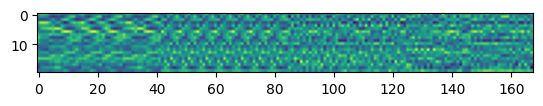

In [13]:
s,h=shrinkingDecompositionInformation(transformer_model,source,target,songs,numbers=list(range(4)),width=20)

In [14]:
M=removalIntoMatrix(s,20,h)

In [15]:
print(M.shape)

(4, 20)


0.8111417624295809 -0.004454685336307662


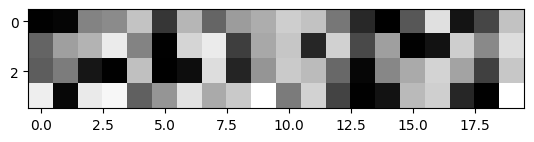

In [16]:
imshow(M,cmap="gray")
print(M.max(),M.min())

In [29]:
print(M.mean(),M.std())

0.4127551098296699 0.27312479520682564


In [30]:
print(songs)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


(20, 168)
(20, 168)


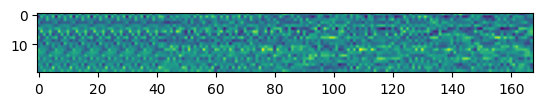

In [31]:
allI,allO,H=getAllIOH(model,source,target,songs,width=20)

In [ ]:
number=5
I=(1*(songs==number)).astype(int)
O=(target.transpose()[-1]==allO)

In [ ]:
allI

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [ ]:
allO

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [ ]:
allI

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [ ]:
model.state_dict().keys()
#model.state_dict().values()

odict_keys(['pos_encoder.pe', 'transformer_encoder.layers.0.self_attn.in_proj_weight', 'transformer_encoder.layers.0.self_attn.in_proj_bias', 'transformer_encoder.layers.0.self_attn.out_proj.weight', 'transformer_encoder.layers.0.self_attn.out_proj.bias', 'transformer_encoder.layers.0.linear1.weight', 'transformer_encoder.layers.0.linear1.bias', 'transformer_encoder.layers.0.linear2.weight', 'transformer_encoder.layers.0.linear2.bias', 'transformer_encoder.layers.0.norm1.weight', 'transformer_encoder.layers.0.norm1.bias', 'transformer_encoder.layers.0.norm2.weight', 'transformer_encoder.layers.0.norm2.bias', 'transformer_encoder.layers.1.self_attn.in_proj_weight', 'transformer_encoder.layers.1.self_attn.in_proj_bias', 'transformer_encoder.layers.1.self_attn.out_proj.weight', 'transformer_encoder.layers.1.self_attn.out_proj.bias', 'transformer_encoder.layers.1.linear1.weight', 'transformer_encoder.layers.1.linear1.bias', 'transformer_encoder.layers.1.linear2.weight', 'transformer_encode

In [ ]:
I.shape

(41, 8)

In [ ]:
O.shape

(41, 8)

# RNN models


## RNN


In [8]:
class RNN(nn.Module):
    def __init__(self, hidden_dim=20, inp=8):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.rnnLayer = nn.RNN(self.hidden_dim, self.hidden_dim, batch_first=True)
        
        self.outputLayer = nn.Linear(self.hidden_dim, self.inp)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x,verbose= False):
        x = self.expand_layer(x)
        x = torch.relu(x)

        self.h0 = torch.Tensor(numpy.zeros((1, x.shape[0], self.hidden_dim)))
        out, self.h0 = self.rnnLayer(x, self.h0)
        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))
        self.store = copy.deepcopy(self.h0.detach().numpy())
        out = self.outputLayer(out)
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.Tensor(numpy.zeros((1, 1, self.hidden_dim)))
            for i in range(x.shape[1]):
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.relu(step_input)

                out, h0 = self.rnnLayer(step_input, h0)
                H.append(out.detach().numpy().flatten())
            out = self.outputLayer(out)
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
        return numpy.array(O), numpy.array(H)


## Attention layer


In [9]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim**0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        return weighted

## RNNA


In [10]:
class RNNA(nn.Module):
    def __init__(self, hidden_dim=20, inp=8):
        super(RNNA, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        self.attention = SelfAttention(inp)  

        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.rnnLayer = nn.RNN(self.hidden_dim, self.hidden_dim, batch_first=True)
        
        self.outputLayer = nn.Linear(self.hidden_dim, self.inp)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x, verbose= False):
        
        attn_out = self.attention(x)
        
        expanded_attn_out = self.expand_layer(attn_out)
        
        expanded_attn_out = torch.relu(expanded_attn_out)

        h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        
        rnn_out, self.hidden = self.rnnLayer(expanded_attn_out, h0)
        self.store = self.hidden.detach().numpy().copy()
        out = self.outputLayer(rnn_out)

        return out
    
    

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.relu(expanded_attn_out)

                out, h0 = self.rnnLayer(expanded_attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = self.outputLayer(out)
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)


## LSTM


In [11]:
class LSTM(nn.Module):
    def __init__(self, hidden_dim=20, inp=8):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.lstmLayer = nn.LSTM(self.hidden_dim, int(self.hidden_dim/2), 1, batch_first=True)

        self.outputLayer = nn.Linear(int(self.hidden_dim/2), self.inp)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x, verbose= False):
        x = self.expand_layer(x)
        x = torch.relu(x)

        self.h0 = (torch.zeros(1, x.shape[0], int(self.hidden_dim/2)), torch.zeros(1, x.shape[0], int(self.hidden_dim/2)))

        out, self.h0 = self.lstmLayer(x, self.h0)

        hh = numpy.concatenate((self.h0[0].detach().numpy(), self.h0[1].detach().numpy()), 2)
        self.hidden.append(hh)
        self.store = hh
        out = self.outputLayer(out)
        return out

        
    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = (torch.zeros(1, 1, int(self.hidden_dim/2)),
                  torch.zeros(1, 1, int(self.hidden_dim/2)))
            for i in range(x.shape[1]):
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.relu(step_input)

                out, h0 = self.lstmLayer(step_input, h0)
                hh = numpy.concatenate((h0[0].detach().numpy().flatten(), h0[1].detach().numpy().flatten()))
                H.append(hh.flatten())

            out = self.outputLayer(out)
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
        return numpy.array(O), numpy.array(H)
    


## LSTMA


In [12]:
class LSTMA(nn.Module):
    def __init__(self, hidden_dim=20, inp=8):
        super(LSTMA, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        self.attention = SelfAttention(inp)  

        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.lstmLayer = nn.LSTM(self.hidden_dim, int(self.hidden_dim/2), batch_first=True)

        self.outputLayer = nn.Linear(int(self.hidden_dim/2), self.inp)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x, verbose= False):
        
        attn_out = self.attention(x)

        expanded_attn_out = self.expand_layer(attn_out)
        expanded_attn_out = torch.relu(expanded_attn_out)

        self.h0 = (torch.zeros(1, x.shape[0], int(self.hidden_dim/2)), torch.zeros(1, x.shape[0], int(self.hidden_dim/2)))
        out, self.h0 = self.lstmLayer(expanded_attn_out, self.h0)
        hh = numpy.concatenate((self.h0[0].detach().numpy(), self.h0[1].detach().numpy()), 2)
        self.hidden.append(hh)
        self.store = hh
        out = self.outputLayer(out)  # Corrected line

        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = (torch.zeros(1, 1, int(self.hidden_dim/2)),
                  torch.zeros(1, 1, int(self.hidden_dim/2)))
            for i in range(x.shape[1]):
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.relu(expanded_attn_out)

                out, h0 = self.lstmLayer(expanded_attn_out, h0)
                H.append(torch.cat((h0[0].detach(), h0[1].detach()), 2).numpy().flatten())

                out = self.outputLayer(out)
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)
    


## GRU


In [13]:
class GRU(nn.Module):
    def __init__(self, hidden_dim=20, inp=8):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.GRULayer = nn.GRU(self.hidden_dim, self.hidden_dim, batch_first=True)
        
        self.outputLayer = nn.Linear(self.hidden_dim, self.inp)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x, verbose= False):
        x = self.expand_layer(x)
        x = torch.relu(x)

        self.h0 = torch.Tensor(numpy.zeros((1, x.shape[0], self.hidden_dim)))
        out, self.h0 = self.GRULayer(x, self.h0)
        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))
        self.store = self.h0.detach().numpy().copy()
        out = self.outputLayer(out)
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.Tensor(numpy.zeros((1, 1, self.hidden_dim)))
            for i in range(x.shape[1]):
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.relu(step_input)

                out, h0 = self.GRULayer(step_input, h0)
                H.append(out.detach().numpy().flatten())
            out = self.outputLayer(out)
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
        return numpy.array(O), numpy.array(H)


## GRUA


In [14]:
class GRUA(nn.Module):
    def __init__(self, hidden_dim=20, inp=8):
        super(GRUA, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        self.attention = SelfAttention(inp) 
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.gruLayer = nn.GRU(self.hidden_dim, self.hidden_dim, batch_first=True)

        self.outputLayer = nn.Linear(self.hidden_dim, self.inp)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x, verbose= False):
        attn_out = self.attention(x)

        expanded_attn_out = self.expand_layer(attn_out)
        expanded_attn_out = torch.relu(expanded_attn_out)

        self.h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        out, self.h0 = self.gruLayer(expanded_attn_out, self.h0)
    
        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))
        self.store = self.h0.detach().numpy().copy()
        out = self.outputLayer(out)
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.relu(expanded_attn_out)

                out, h0 = self.gruLayer(expanded_attn_out, h0)
                H.append(out.detach().numpy().flatten())

    
                out = self.outputLayer(out)
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)



## generateIOData on all songs at once with its corresponding combinations


Input shape: (42, 41, 8), Output (One-Hot) shape: (42, 41, 8), Output (Indices) shape: (42, 41), Song shape: (42,)


Text(0.5, 1.0, 'One Hot Label Input')

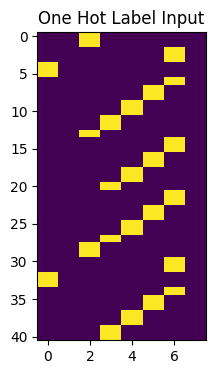

In [15]:
    songStrings = numpy.array([
        "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC",
        "ABCDEFABCDEFABCDEFABCDEFABCDEFABCDEFABCDEF",
        "ABACADAEAFABEFADECBABCFEDEFABCADEBACADFABE",
        "DBCACBCFFDCEFFEFCDDEFEBEACFECBBBCBECBFDAFB",
        "ABEBCAEFCDFFBCBDBBBCEDCBFBFFECBCEBCAAFFADB",
        "BEEFBAFDAEAAEFDBDFDEFCACEBCCDACEACACEEDBAA",
        "BFEBFEEBDBCFEAACAAAFDFCBFBFEAACFFCAABCEDDC",
        "BADDFFEADBEDFDFBEBCCADEFDEABBFDEFFEBEEFDEF",
        "ABFFEDBDBFECEDEAEBBEECFDDAEDCDBBFCADADBBCF",
        "DFBCEBDAADAAFCDACADDAFFACDCFCCDDDCFBEBBDED",
        "CCFBEFDDCBFDADDBFBCCEEABAFAAAEDCDCEAEFBFCD",
        "EBADFFAAFADDDABEABBDFDCAFBCDEEBBBECDDFEEAE",
        "AFADDFEFADDBCDCFEEFCAEEEDFFEDBCADBBDBAEFCD"])

    def generateIOData(nrOfSongs, songStrings):
        notes = list("ABCDEFGH")
        source = []
        target_one_hot = []
        target_indices = []
        songs = []  # Array to track the song index for each sequence

        for s in range(nrOfSongs):
            song_length = len(songStrings[s])
            for i in range(song_length):  # Adjust to iterate correctly
                input_one_hot = np.zeros((41, 8))
                current_target_one_hot = np.zeros((41, 8))
                current_target_indices = np.zeros(41, dtype=int)

                for j in range(41):
                    note_index = notes.index(songStrings[s][(i+j) % song_length])
                    next_note_index = notes.index(songStrings[s][(i+j+1) % song_length])

                    input_one_hot[j, note_index] = 1
                    current_target_one_hot[j, next_note_index] = 1
                    current_target_indices[j] = next_note_index

                source.append(input_one_hot)
                target_one_hot.append(current_target_one_hot)
                target_indices.append(current_target_indices)
                songs.append(s)  # Append the song index

        return np.array(source), np.array(target_one_hot), np.array(target_indices), np.array(songs)


I, O_hot, O_indices, songs = generateIOData(1, songStrings)
print(f"Input shape: {I.shape}, Output (One-Hot) shape: {O_hot.shape}, Output (Indices) shape: {O_indices.shape}, Song shape: {songs.shape}")

# Display the first input and output for visualization
plt.figure(figsize=(10, 4))
plt.subplot(1, 4, 1)
who = 0
plt.imshow(I[who], aspect='auto')
plt.title("One Hot Label Input")



In [ ]:
    I, O_hot, O_indices, songs = generateIOData(4, songStrings)


In [20]:
print(I[0])


[[0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 

In [4]:
O_indices


array([[2, 6, 6, ..., 3, 3, 2],
       [6, 6, 0, ..., 3, 2, 2],
       [6, 0, 0, ..., 2, 2, 2],
       ...,
       [5, 1, 3, ..., 1, 5, 3],
       [1, 3, 1, ..., 5, 3, 0],
       [3, 1, 2, ..., 3, 0, 5]])

(41, 8)
(41, 8)


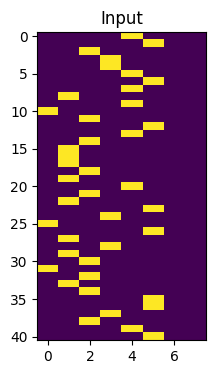

In [103]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 4, 1)
who = 140
plt.imshow(I[who], aspect='auto')
plt.title("Input")
print(I[who].shape)
print(O_hot[who].shape)



In [107]:
len(I[who])

41

In [40]:
songs

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

## Train Rnns on all songs at once with its corresponding combinations


In [66]:
def train_model(model, num_epochs, songStrings, number_of_Songs):
    L = []  # Losses
    A = []  # Accuracies
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), 1e-3)
    
    # Assuming generateIOData has been adjusted to take only songStrings
    I, _, O_indices, songs = generateIOData(number_of_Songs,songStrings)  # Use the full dataset
    #print(f"Input shape: {I.shape}, Output (Indices) shape: {O_indices.shape}")
    # Convert the dataset to tensors
    inputs = torch.tensor(I, dtype=torch.float)
    targets = torch.tensor(O_indices, dtype=torch.long)

    for epoch in range(num_epochs):
        optimizer.zero_grad()  # Zero the gradients at the start of each epoch
        
        # Shuffle dataset
        indices = torch.randperm(inputs.size(0))
        inputs_shuffled = inputs[indices]
        targets_shuffled = targets[indices]
        
        # Assuming the model expects inputs of shape [seq_len, batch, feature]
        src = inputs_shuffled
        tgt = targets_shuffled
        #print(f"src shape: {src.shape}, tgt shape: {tgt.shape}")
        # Forward pass
        outputs = model(src)
        output_flat = outputs.view(-1, outputs.shape[-1])  # Flatten output for CrossEntropyLoss
        loss = criterion(output_flat, tgt.view(-1))
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        total_loss = loss.item()

        # Calculate accuracy
        _, predicted_indices = torch.max(output_flat, 1)
        #print(f'predicted { predicted_indices}')
        #print(f'target {tgt.view(-1)}')
        correct_predictions = (predicted_indices == tgt.view(-1)).sum().item()
        total_accuracy = correct_predictions / tgt.numel()
        
        # Log the loss and accuracy
        if epoch % 100 == 0:
            print(f'Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {total_accuracy:.4f}')
        
        L.append(total_loss)
        A.append(total_accuracy)

        # Early stopping criteria (optional)
        if total_accuracy >= 0.95:
            print("Early stopping criteria met")
            break

    return L, A

In [ ]:
model = RNN()
num_epochs = 5000
number_of_Songs = 4
L, A  = train_model(model, num_epochs, songStrings= songStrings, number_of_Songs = 4)

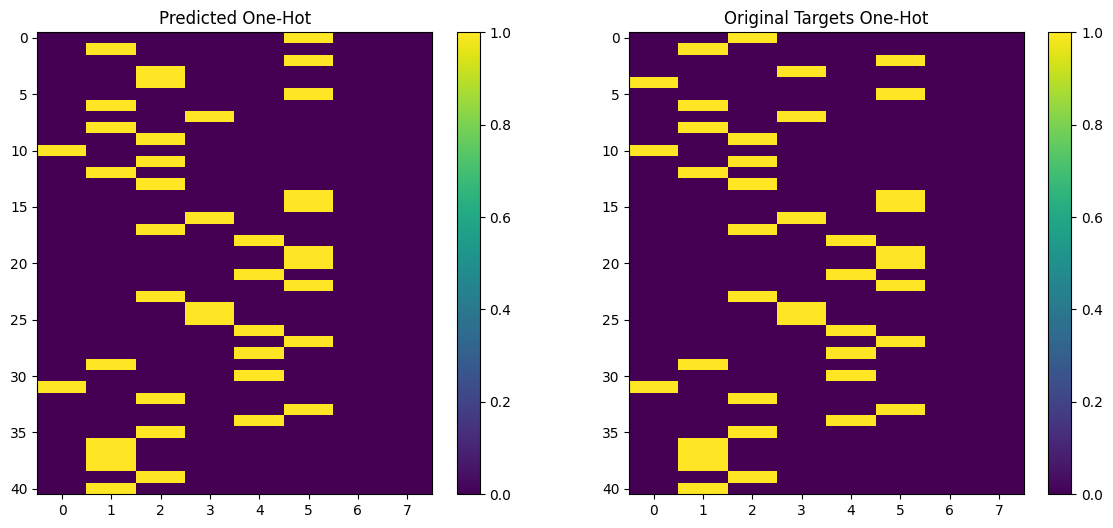

In [44]:
I, O, O_indices, songs = generateIOData(number_of_Songs,songStrings)  # Use the full dataset

inputs = torch.Tensor(I)
outputs = model(inputs)

_, predicted_indices = torch.max(outputs, 2)

num_classes = 8 

predicted_one_hot = F.one_hot(predicted_indices.squeeze(), num_classes=num_classes).numpy()


O_tensor = torch.tensor(O_indices, dtype=torch.long)
original_one_hot = F.one_hot(O_tensor, num_classes=num_classes).numpy()


plt.figure(figsize=(14, 6))
who = 160
# Plotting one-hot encoded predicted indices
plt.subplot(1, 2, 1)
plt.imshow(predicted_one_hot[who], cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Predicted One-Hot')

# Plotting one-hot encoded original targets
plt.subplot(1, 2, 2)
plt.imshow(original_one_hot[who], cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Original Targets One-Hot')

plt.show()

In [17]:
models = {
    "RNN": RNN(),
    "RNNA": RNNA(),  
    "LSTM": LSTM(),
    "LSTMA": LSTMA(),  
    "GRU": GRU(),
    "GRUA": GRUA() 
    
}

In [13]:
models = {
    "RNN": RNN(),
    "RNNA": RNNA(),  
    "LSTM": LSTM(),
    "LSTMA": LSTMA(),  
    "GRU": GRU(),
    "GRUA": GRUA() 
    
}
number_of_Songs = 4
num_epochs = 10000
results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    L , A = train_model(model, num_epochs, songStrings, number_of_Songs)
    results[model_name] = {"Accuracy": A, "Loss": L}
    torch.save(model, f'./SongModels/model_{model_name}_songs.model')


Training RNN...
Epoch 1, Loss: 2.1002, Accuracy: 0.1720
Epoch 101, Loss: 1.7311, Accuracy: 0.3924
Epoch 201, Loss: 1.2693, Accuracy: 0.5129
Epoch 301, Loss: 0.9028, Accuracy: 0.7101
Epoch 401, Loss: 0.6484, Accuracy: 0.7933
Epoch 501, Loss: 0.4826, Accuracy: 0.8776
Epoch 601, Loss: 0.3768, Accuracy: 0.9138
Epoch 701, Loss: 0.3066, Accuracy: 0.9370
Epoch 801, Loss: 0.2624, Accuracy: 0.9464
Epoch 901, Loss: 0.2330, Accuracy: 0.9474
Early stopping criteria met
Training RNNA...
Epoch 1, Loss: 2.0826, Accuracy: 0.1607
Epoch 101, Loss: 1.9103, Accuracy: 0.1826
Epoch 201, Loss: 1.7912, Accuracy: 0.2207
Epoch 301, Loss: 1.6227, Accuracy: 0.3410
Epoch 401, Loss: 1.3642, Accuracy: 0.4834
Epoch 501, Loss: 1.1992, Accuracy: 0.5510
Epoch 601, Loss: 0.9910, Accuracy: 0.6648
Epoch 701, Loss: 0.8747, Accuracy: 0.6792
Epoch 801, Loss: 0.7817, Accuracy: 0.6973
Epoch 901, Loss: 0.6836, Accuracy: 0.7589
Epoch 1001, Loss: 0.5909, Accuracy: 0.7983
Epoch 1101, Loss: 0.5153, Accuracy: 0.8230
Epoch 1201, Loss:

In [ ]:
for model_name, metrics in results.items():
    print(f"\nModel: {model_name}")
    print(f"Number of Epoch: {len(metrics['Accuracy'])}")
    print(f"Final Accuracy: {metrics['Accuracy'][-1]:.4f}")
    print(f"Final Loss: {metrics['Loss'][-1]:.4f}")


In [15]:
model.store[-1].shape

(168, 20)

In [106]:
I, _, O_indices, songs = generateIOData(number_of_Songs,songStrings)  # Use the full dataset
I.shape

(168, 41, 8)

## predict_next_token


In [16]:
def predict_next_token_RNNS(model, token_indices,verbose=False):
    model.eval()  # Ensure the model is in evaluation mode
    
    # Convert the list of token indices to a PyTorch tensor and add a batch dimension
    inputs = torch.Tensor([token_indices])
    outputs = model(inputs)

    with torch.no_grad():
        outputs = model(inputs)

    _, predicted_indices = torch.max(outputs, 2)
    #print(predicted_indices)

    
    #last_token_logits = output[-1, 0, :]  # Get logits for the last token
    #predicted_token_index =   # Find the index of the max log-probability
    predicted_token_index = predicted_indices[0, -1].item()  # Get the last item as a Python int

    return predicted_token_index

# Example usage:
# Assuming you have a `model` instance and a sentence represented as a list of token indices
# token_indices = [1, 2, 3, 2, 1, 2, 3, ...]



In [ ]:
who=88
I[who]
#print(I[who])
print(O_indices[who])
predicted_token_index = predict_next_token_RNNS(model, I[who],verbose=True)
print(f'Predicted next token index: {predicted_token_index}')
print(f"original target {O_indices[who][-1]}")

In [54]:
O_indices[who]

array([6, 6, 5, 5, 4, 4, 3, 2, 2, 6, 6, 0, 0, 6, 5, 5, 4, 4, 3, 3, 2, 2,
       2, 6, 6, 0, 0, 6, 5, 5, 4, 4, 3, 3, 2, 6, 6, 5, 5, 4, 4])

tensor([2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5, 4, 4, 3, 2, 2, 5,
        5, 4, 4, 3, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3])
tensor([2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5, 4, 4, 3, 2, 2, 5, 5,
        4, 4, 3, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2])
tensor([2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5, 4, 4, 3, 2, 2, 5, 5, 4,
        4, 3, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2])
tensor([2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5, 4, 4, 3, 2, 2, 5, 5, 4, 4,
        3, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2])
tensor([0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5, 4, 4, 3, 2, 2, 5, 5, 4, 4, 3,
        2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 2])
tensor([0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5, 4, 4, 3, 2, 2, 5, 5, 4, 4, 3, 2,
        2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 2, 2])
tensor([2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5, 4, 4, 3, 2, 2, 5, 5, 4, 4, 3, 2, 2,
        2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 2, 2, 0])
tensor([5, 5, 4, 4, 

tensor([5, 4, 4, 3, 3, 2, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5,
        4, 4, 3, 2, 2, 5, 5, 4, 4, 3, 2, 2, 2, 2, 0, 0, 2])
tensor([4, 4, 3, 3, 2, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5, 4,
        4, 3, 2, 2, 5, 5, 4, 4, 3, 2, 2, 2, 2, 0, 0, 2, 5])
tensor([4, 3, 3, 2, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5, 4, 4,
        3, 2, 2, 5, 5, 4, 4, 3, 2, 2, 2, 2, 0, 0, 2, 5, 5])
tensor([3, 3, 2, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5, 4, 4, 3,
        2, 2, 5, 5, 4, 4, 3, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4])
tensor([3, 2, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5, 4, 4, 3, 2,
        2, 5, 5, 4, 4, 3, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4])
tensor([2, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5, 4, 4, 3, 2, 2,
        5, 5, 4, 4, 3, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3])
tensor([0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5,
        0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4])
tensor([1, 2, 3, 4, 

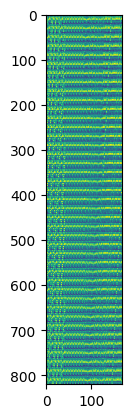

In [55]:
source, O_hot, target, songs = generateIOData(4, songStrings)

s,h=shrinkingDecompositionInformation(model,source,target,songs,numbers=list(range(4)),width=20)

In [56]:
M=removalIntoMatrix(s,20,h)

0.00856853999610463 -0.007828062947824677


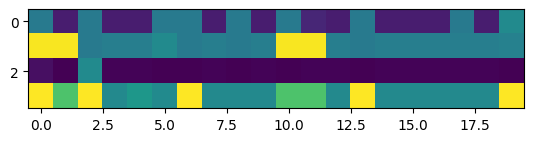

In [57]:
imshow(M)
print(M.max(),M.min())

# plot M


In [48]:
target

array([[2, 6, 6, ..., 3, 3, 2],
       [6, 6, 0, ..., 3, 2, 2],
       [6, 0, 0, ..., 2, 2, 2],
       ...,
       [5, 1, 3, ..., 1, 5, 3],
       [1, 3, 1, ..., 5, 3, 0],
       [3, 1, 2, ..., 3, 0, 5]])

tensor([[3, 6, 6, 0, 0, 6, 5, 5, 4, 4, 3, 3, 2, 6, 6, 5, 5, 4, 4, 3, 6, 6, 5, 5,
         4, 4, 3, 2, 2, 6, 6, 0, 0, 6, 5, 5, 4, 4, 3, 3, 2]])
tensor([[3, 6, 5, 0, 6, 5, 5, 4, 4, 3, 3, 2, 6, 6, 5, 5, 4, 4, 3, 6, 6, 5, 5, 4,
         4, 3, 2, 2, 6, 6, 0, 0, 6, 5, 5, 4, 4, 3, 3, 2, 2]])
tensor([[6, 5, 3, 6, 5, 5, 4, 4, 3, 3, 2, 6, 6, 5, 5, 4, 4, 3, 6, 6, 5, 5, 4, 4,
         3, 2, 2, 6, 6, 0, 0, 6, 5, 5, 4, 4, 3, 3, 2, 2, 2]])
tensor([[6, 0, 6, 5, 5, 4, 4, 3, 3, 2, 6, 6, 5, 5, 4, 4, 3, 6, 6, 5, 5, 4, 4, 3,
         2, 2, 6, 6, 0, 0, 6, 5, 5, 4, 4, 3, 3, 2, 2, 2, 6]])
tensor([[1, 1, 6, 5, 4, 4, 3, 3, 2, 2, 6, 5, 5, 4, 4, 3, 6, 6, 5, 5, 4, 4, 3, 2,
         2, 6, 6, 0, 0, 6, 5, 5, 4, 4, 3, 3, 2, 2, 2, 6, 6]])
tensor([[1, 5, 5, 4, 4, 3, 3, 2, 2, 6, 5, 5, 4, 4, 3, 6, 6, 5, 5, 4, 4, 3, 2, 2,
         6, 6, 0, 0, 6, 5, 5, 4, 4, 3, 3, 2, 2, 2, 6, 6, 0]])
tensor([[6, 5, 4, 4, 3, 3, 2, 2, 6, 5, 5, 4, 4, 3, 6, 6, 5, 5, 4, 4, 3, 2, 2, 6,
         6, 0, 0, 6, 5, 5, 4, 4, 3, 3, 2, 2, 2, 6, 6, 0, 0]])

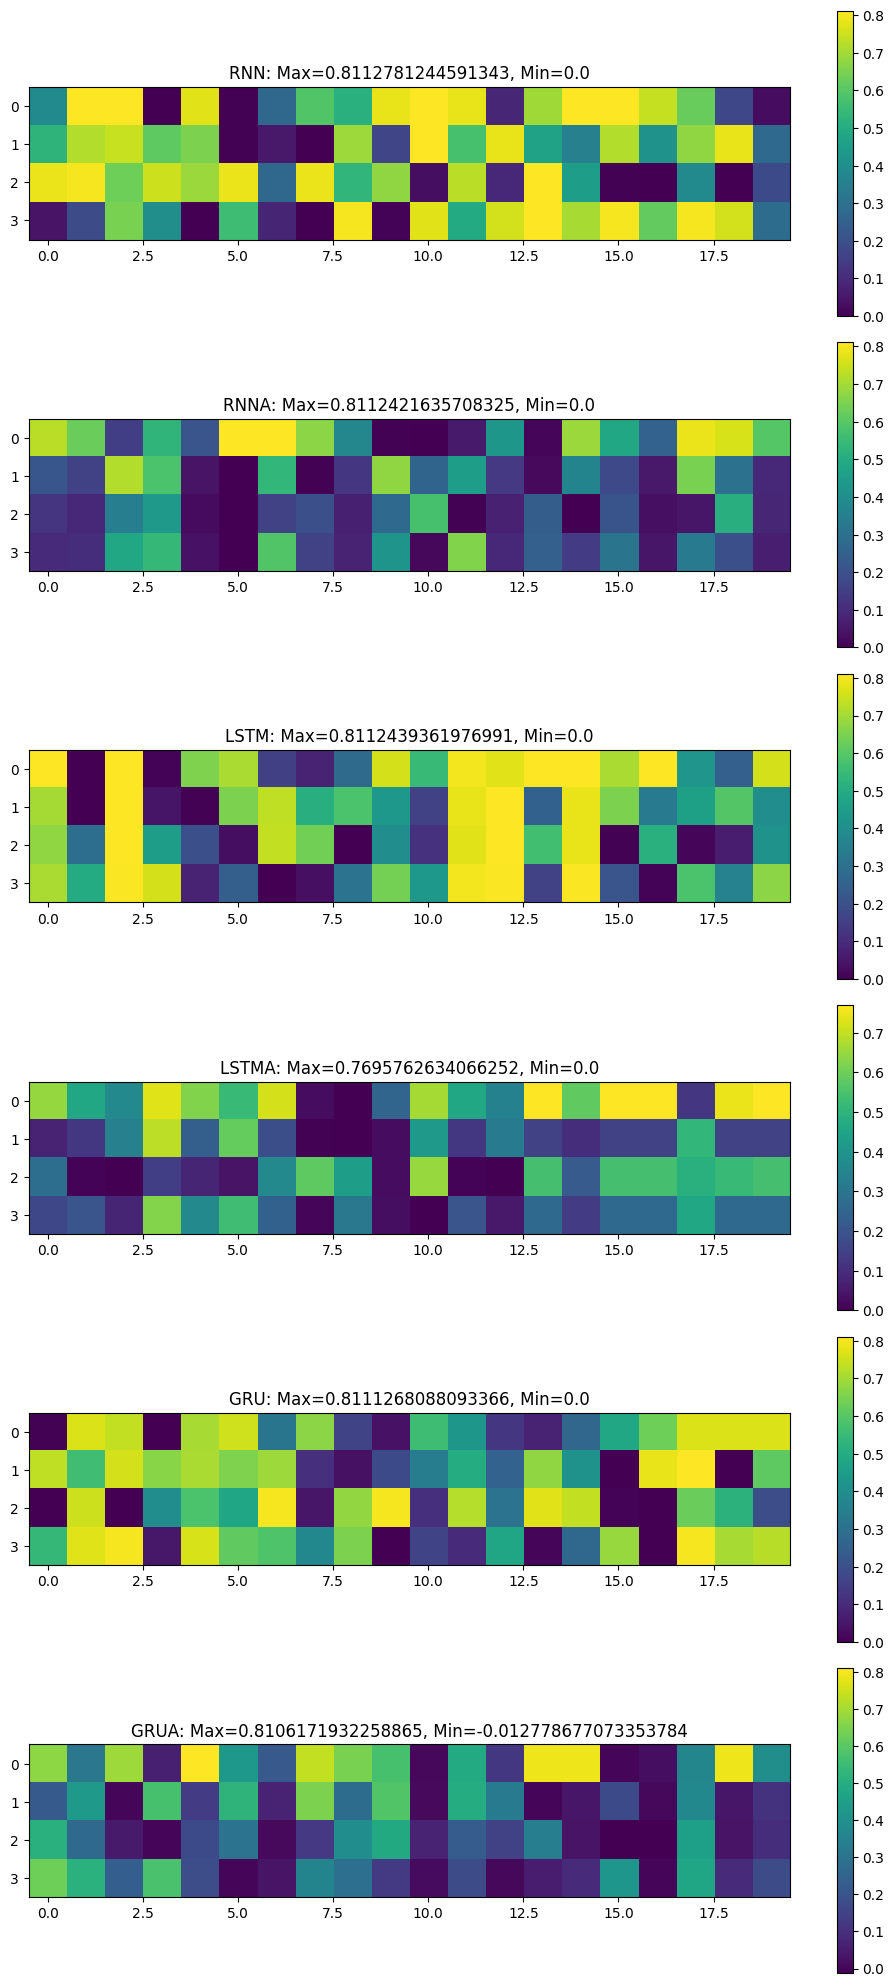

In [30]:
models = {
    "RNN": RNN(),
    "RNNA": RNNA(),  
    "LSTM": LSTM(),
    "LSTMA": LSTMA(),  
    "GRU": GRU(),
    "GRUA": GRUA(),
}
source, O_hot, target, songs = generateIOData(4, songStrings)
fig, axs = plt.subplots(len(models), 1, figsize=(10, 20))

# For each model, process the data and plot the resulting matrix
for i, (model_name, model) in enumerate(models.items()):
    model = torch.load(f'./SongModels/model_{model_name}_songs.model')
    model.eval()  # Set the model to evaluation mode if you're doing inference

    s, h = shrinkingDecompositionInformation(model, source, target, songs, numbers=list(range(4)), width=20)
    M = removalIntoMatrix(s, 20, h)
    
    ax = axs[i]
    cax = ax.imshow(M)
    fig.colorbar(cax, ax=ax)
    ax.set_title(f"{model_name}: Max={M.max()}, Min={M.min()}")

plt.tight_layout()
plt.show()


In [ ]:
M

array([[-0.01394116,  0.        , -0.01394116, -0.01021922, -0.01394116,
        -0.01394116, -0.01394116, -0.01394116, -0.01394116, -0.01021922,
        -0.01394116, -0.01021922, -0.01394116, -0.01021922, -0.01021922,
        -0.01021922, -0.01394116, -0.01394116, -0.01394116, -0.01394116],
       [-0.02607095, -0.02607095, -0.02607095, -0.02526978, -0.02607095,
        -0.02607095, -0.02607095, -0.02607095,  0.        , -0.02526978,
        -0.02607095, -0.02526978, -0.02607095, -0.02526978, -0.02526978,
        -0.02526978, -0.02607095, -0.02607095, -0.02607095, -0.02607095],
       [-0.02395571, -0.02395571,  0.        , -0.02395571, -0.02395571,
        -0.02395571, -0.02395571, -0.02395571, -0.01398283, -0.02395571,
        -0.02395571, -0.02395571, -0.02395571, -0.02395571, -0.02395571,
        -0.02395571, -0.02395571, -0.02395571, -0.02395571, -0.02395571],
       [ 0.01873013,  0.        ,  0.        ,  0.02300939,  0.01873013,
         0.01873013,  0.01873013,  0.01873013,  

# Calculations


In [17]:
def kmeans_thresholding(matrix, random_state=42):
    # Flatten the matrix
    flat_matrix = matrix.flatten()

    # Apply KMeans clustering with a fixed random state for reproducibility
    kmeans = KMeans(n_clusters=2, n_init=10, random_state=random_state).fit(flat_matrix.reshape(-1, 1))

    centroids = kmeans.cluster_centers_.flatten()

    # Check if there are two centroids (clusters) and handle accordingly
    if len(centroids) > 1:
        # Determine threshold - you may choose a different method here
        threshold = np.mean(centroids)
    else:
        # If only one centroid (unlikely, but possible), use it as the threshold
        threshold = centroids[0]

    # Count the number of elements exceeding the threshold
    count_exceeding = np.sum(flat_matrix > threshold)

    return threshold, count_exceeding



In [18]:
def threshold_binarize_matrix(matrix, threshold):
    # Flatten the matrix
    flat_matrix = matrix.flatten()

    # Apply thresholding
    binarized_matrix = np.where(flat_matrix >= threshold, 1, 0)

    # Reshape to the original matrix shape
    binarized_matrix = binarized_matrix.reshape(matrix.shape)

    return binarized_matrix



In [19]:
def calculate_degrees_of_overlap(matrix):
    # Assuming 'matrix' is a NumPy array of shape (4, 20)
    degree_2, degree_3, degree_4 = 0, 0, 0

    # Transpose is not necessary as we want to work column-wise
    for col in range(matrix.shape[1]):  # Iterate through each column
        count_ones = np.sum(matrix[:, col] == 1)  # Count the number of ones in the current column
        if count_ones == 2:
            degree_2 += 1
        elif count_ones == 3:
            degree_3 += 1
        elif count_ones == 4:
            degree_4 += 1

    return degree_2, degree_3, degree_4



In [23]:
M

array([[-0.0264147 , -0.0264147 , -0.0264147 , -0.0264147 , -0.0264147 ,
        -0.0264147 , -0.00704346, -0.0264147 , -0.0264147 , -0.0264147 ,
        -0.0264147 ,  0.        , -0.01311215, -0.0264147 , -0.0264147 ,
        -0.0264147 , -0.0264147 , -0.0264147 , -0.0264147 , -0.0264147 ],
       [-0.1386625 , -0.1386625 , -0.1386625 , -0.1386625 ,  0.        ,
        -0.03196544, -0.1386625 , -0.1386625 , -0.1386625 , -0.1386625 ,
        -0.1386625 , -0.06142105, -0.1386625 , -0.1386625 , -0.1386625 ,
        -0.1386625 , -0.1386625 , -0.1386625 , -0.1386625 , -0.1386625 ],
       [-0.07864014, -0.02409398, -0.07864014, -0.07864014, -0.07864014,
        -0.07864014,  0.        , -0.07864014, -0.07864014, -0.07864014,
        -0.07864014, -0.07149082, -0.06206952, -0.07864014, -0.07864014,
        -0.07864014, -0.07864014, -0.07864014, -0.07864014, -0.07864014],
       [-0.00091821,  0.        , -0.00091821, -0.00091821,  0.00167111,
        -0.00091821,  0.00167111, -0.00091821, -

In [36]:
results = []
           
# Calculate metrics
sum_abs = np.sum(np.abs(M))
mean = np.mean(M)
std = np.std(M)
max_val = np.max(M)
min_val = np.min(M)

threshold_song_1, count_exceeding_song_1 = kmeans_thresholding(M[0]) # fix this K means of A alone then B alone
threshold_song_2, count_exceeding_song_2 = kmeans_thresholding(M[1]) # fix this K means of A alone then B alone
threshold_song_3, count_exceeding_song_3 = kmeans_thresholding(M[2]) # fix this K means of A alone then B alone
threshold_song_4, count_exceeding_song_4 = kmeans_thresholding(M[3]) # fix this K means of A alone then B alone

binarized_matrix_song_1 = np.where(M[0].flatten() >= threshold_song_1, 1, 0).reshape(M[0].shape) 
binarized_matrix_song_2 = np.where(M[1].flatten() >= threshold_song_2, 1, 0).reshape(M[1].shape)
binarized_matrix_song_3 = np.where(M[2].flatten() >= threshold_song_3, 1, 0).reshape(M[2].shape)
binarized_matrix_song_4 = np.where(M[3].flatten() >= threshold_song_4, 1, 0).reshape(M[3].shape)
count_exceeding_song_1_sum = np.sum(M[0] > threshold_song_1) # or use count_exceeding_song_1
count_exceeding_song_2_sum = np.sum(M[1] > threshold_song_2) # or use count_exceeding_song_2
count_exceeding_song_3_sum = np.sum(M[2] > threshold_song_3) # or use count_exceeding_song_3
count_exceeding_song_4_sum = np.sum(M[3] > threshold_song_4) # or use count_exceeding_song_4
# Vertically stack binarized_matrix_A and binarized_matrix_B
binarized_combined_matrix = np.vstack([binarized_matrix_song_1, binarized_matrix_song_2, binarized_matrix_song_3, binarized_matrix_song_4])

degree_2, degree_3, degree_4  = calculate_degrees_of_overlap(binarized_combined_matrix)

min_values = np.min(binarized_combined_matrix, axis=0)

# Clip these values between 0 and 1
clipped_min_values = np.clip(min_values, 0, 1)

# Sum the clipped values
sum_clipped_min_values = np.sum(clipped_min_values) # fixed this







In [38]:
threshold_song_1, count_exceeding_song_1 ,binarized_count_exceeding_song_1,threshold_song_1

(-0.016566616639408976, 3, 3, -0.016566616639408976)

In [39]:
binarized_combined_matrix

array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0]])

In [40]:
degree_2, degree_3, degree_4

(2, 2, 0)

# Accuracy plots


In [20]:
def tensor_str_to_float(tensor_str):
    # Convert a string like 'tensor(0.4533)' to a float
    return float(tensor_str.strip('tensor()'))

def pad_data(data, target_length):
    # Truncate or extend the data to the target length
    if len(data) > target_length:
        return data[:target_length]
    else:
        pad_value = data[-1] if data else 0  # Use last value or 0 if data is empty
        x = data + [pad_value] * (target_length - len(data))
        return x[:target_length]
    
    
    
def read_and_process_csv(filename, target_epoch, process_func, skip_condition=None):
    try:
        data = pd.read_csv(filename)
        data['accuracy'] = data['accuracy'].apply(process_func)

        if skip_condition and skip_condition(data):
            return None, True

        padded_data = pad_data(data['accuracy'].tolist(), target_epoch)
        return padded_data, False
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return None, False

def skip_condition(data):
    return len(data) >= 2000 and data['accuracy'].max() < 0.97


# Function to find the first epoch where accuracy reaches 80%
def find_epoch_at_80_percent(accuracy_list):  
    for i, acc in enumerate(accuracy_list):
        if acc >= 0.80:
            return i
    return None

/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_73675/2522936209.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  avg_data = np.mean(np.array(rep_data), axis=0)


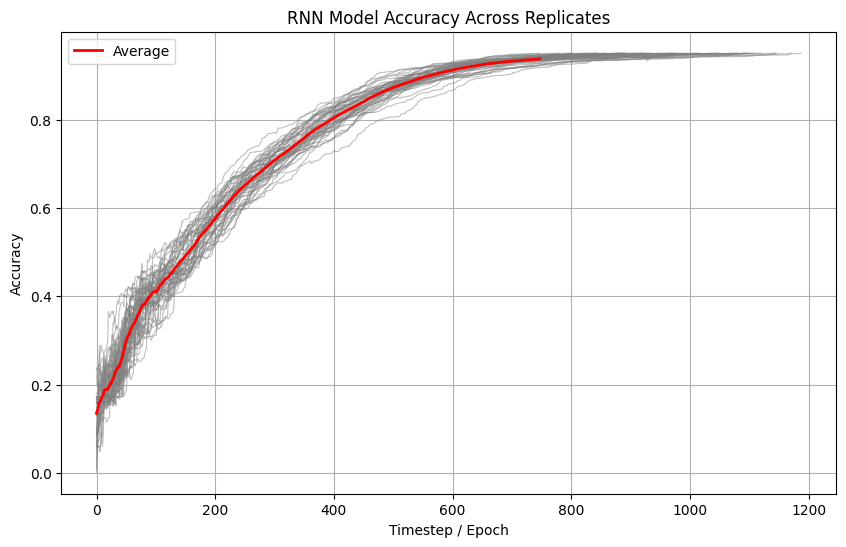

/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_73675/2522936209.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  avg_data = np.mean(np.array(rep_data), axis=0)


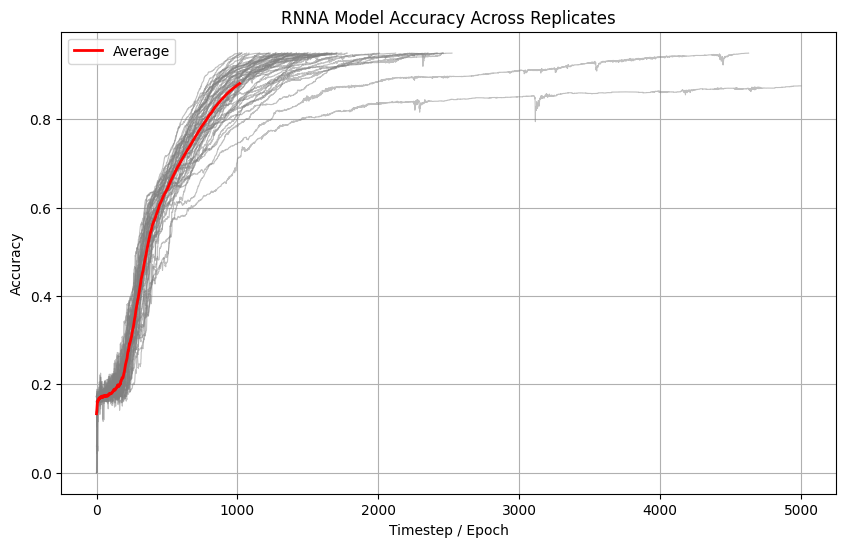

/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_73675/2522936209.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  avg_data = np.mean(np.array(rep_data), axis=0)


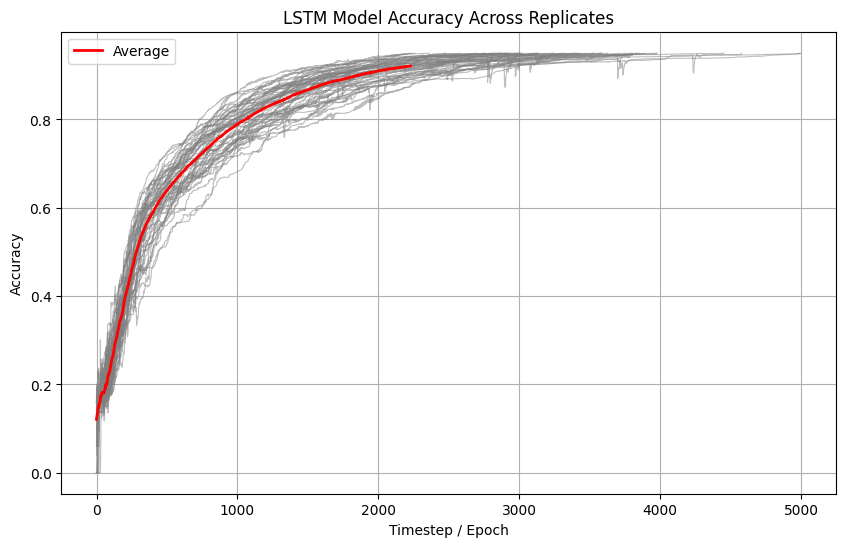

/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_73675/2522936209.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  avg_data = np.mean(np.array(rep_data), axis=0)


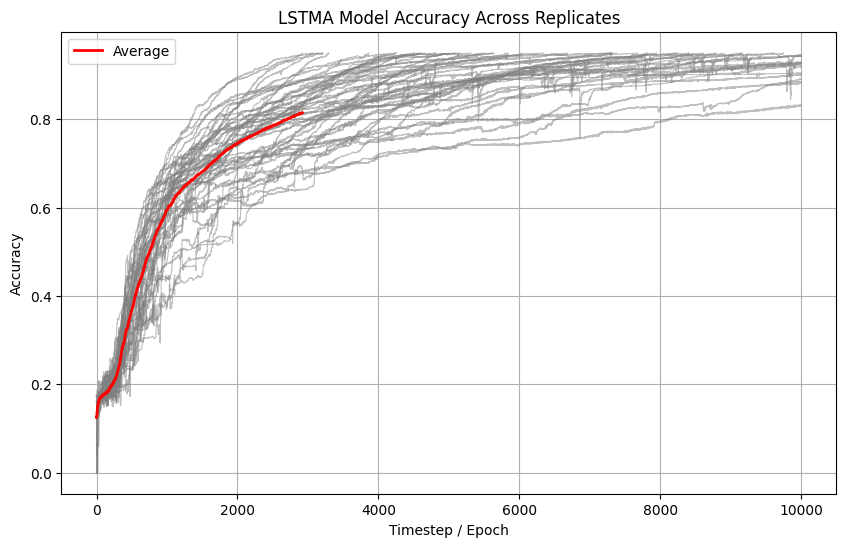

/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_73675/2522936209.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  avg_data = np.mean(np.array(rep_data), axis=0)


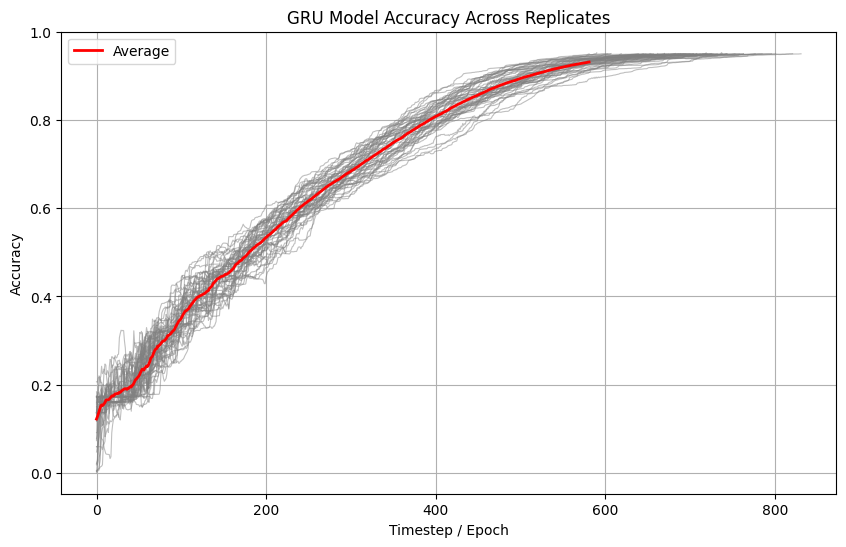

/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_73675/2522936209.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  avg_data = np.mean(np.array(rep_data), axis=0)


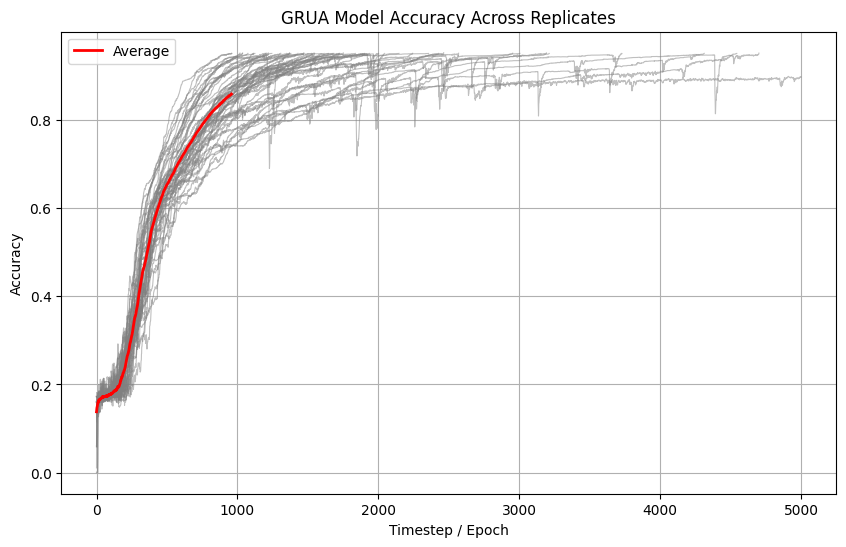

/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_73675/2522936209.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  avg_data = np.mean(np.array(rep_data), axis=0)


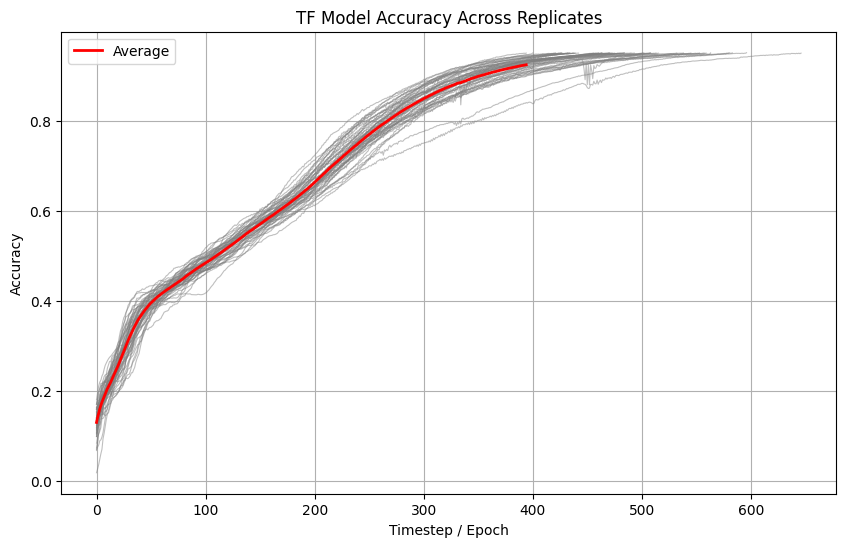

<Figure size 640x480 with 0 Axes>

In [22]:
#kinds = ["TF"]
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA", "TF"]
num_reps = 50
base_path = './dataAcc'  # Assuming the files are in the 'dataAcc' directory

# Plotting for each kind
for kind in kinds:
    rep_data = []  # To store accuracy data from all replicates
    for rep in range(num_reps):
        filename = f'acc_{kind}_{rep}.csv'
        filepath = os.path.join(base_path, filename)
        try:
            # Load the CSV file
            data = pd.read_csv(filepath)['acc']
            rep_data.append(data)
        except FileNotFoundError:
            print(f"File not found: {filepath}")
            continue

    if not rep_data:
        print(f"No data found for {kind}, skipping...")
        continue

    # Calculating the average accuracy across all replicates at each timestep
    avg_data = np.mean(np.array(rep_data), axis=0)

    # Plotting
    plt.figure(figsize=(10, 6))
    for data in rep_data:
        plt.plot(data, alpha=0.5, linewidth=0.8, color='gray', label='_nolegend_')
    plt.plot(avg_data, label="Average", linewidth=2, color='red')
    
    # Configuring the plot
    plt.title(f"{kind} Model Accuracy Across Replicates")
    plt.xlabel("Timestep / Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

plt.tight_layout()


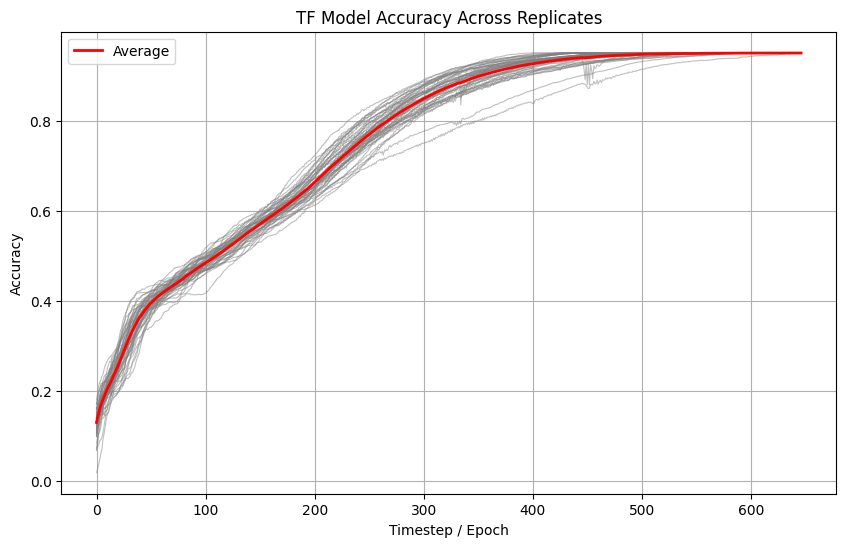

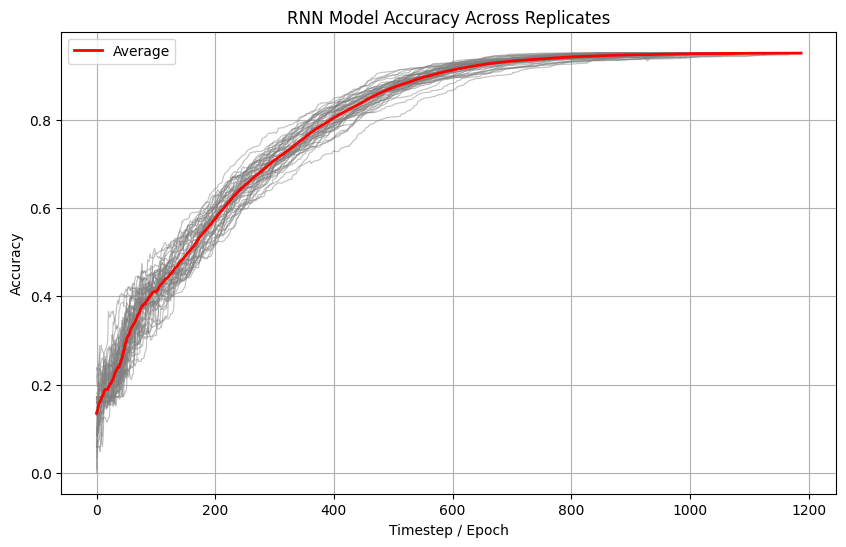

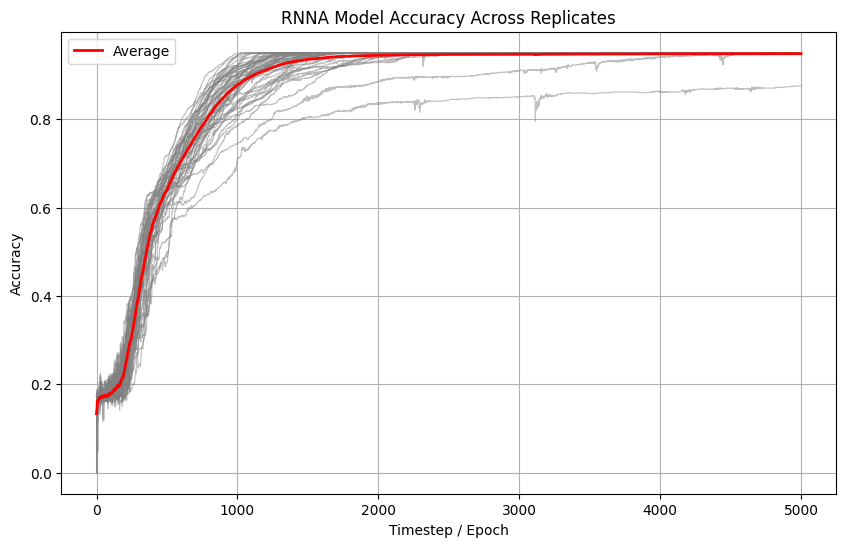

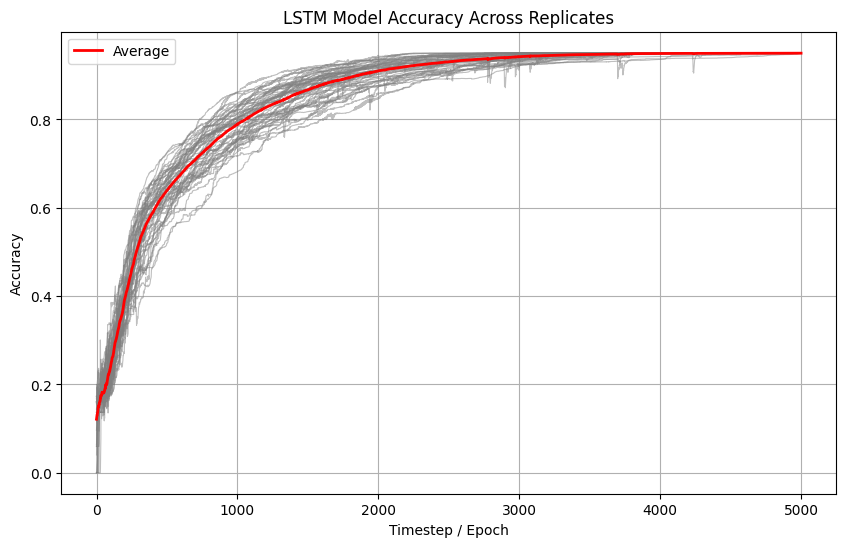

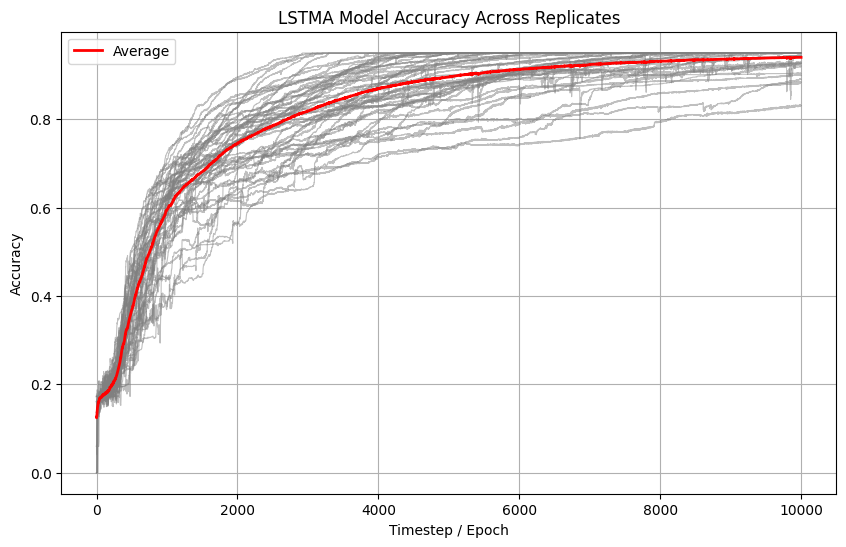

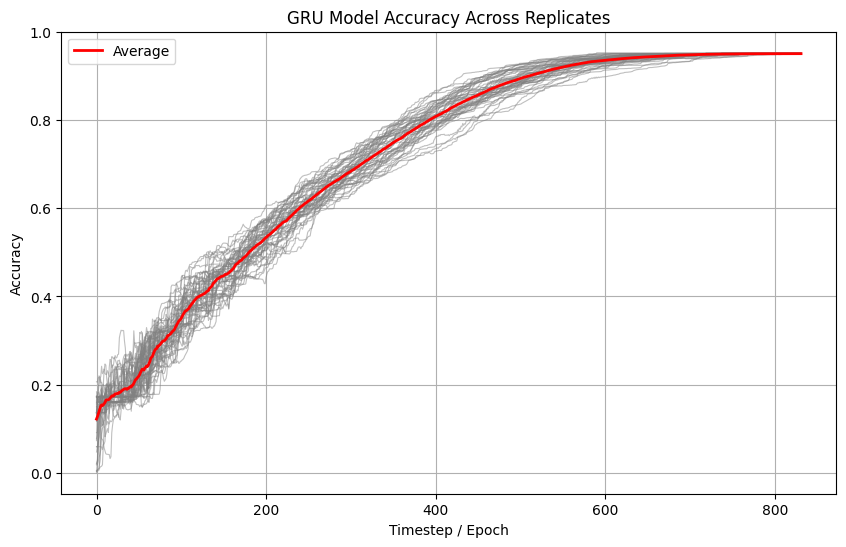

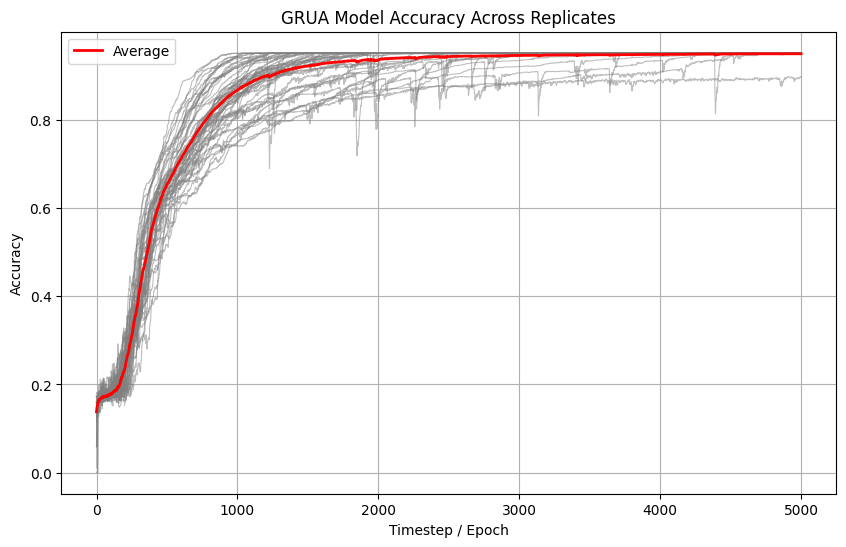

<Figure size 640x480 with 0 Axes>

In [23]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

kinds = ["TF", "RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
num_reps = 50
base_path = './dataAcc'  # Updated base path to use the provided storage

# Initialize a dictionary to hold the padded data for plotting
padded_rep_data_dict = {}

for kind in kinds:
    rep_data = []  # To store accuracy data from all replicates
    max_length = 0  # To find the maximum length of rows among all files
    
    # First pass: find the max length and collect data
    for rep in range(num_reps):
        filename = f'acc_{kind}_{rep}.csv'
        filepath = os.path.join(base_path, filename)
        try:
            data = pd.read_csv(filepath)['acc']
            rep_data.append(data)
            max_length = max(max_length, len(data))  # Update the max_length if current data is longer
        except FileNotFoundError:
            print(f"File not found: {filepath}")
            continue
    
    if not rep_data:
        print(f"No data found for {kind}, skipping...")
        continue
    
    # Second pass: pad data to max_length
    padded_rep_data = []
    for data in rep_data:
        last_value = data.iloc[-1]  # Get the last value to use for padding
        padded_data = np.pad(data, (0, max_length - len(data)), 'constant', constant_values=(last_value))
        padded_rep_data.append(padded_data)
    
    padded_rep_data_dict[kind] = padded_rep_data  # Store the padded data for plotting

# Now plotting for each kind with padded data
for kind, padded_rep_data in padded_rep_data_dict.items():
    # Calculating the average accuracy across all replicates at each timestep
    avg_data = np.mean(np.array(padded_rep_data), axis=0)

    # Plotting
    plt.figure(figsize=(10, 6))
    for data in padded_rep_data:
        plt.plot(data, alpha=0.5, linewidth=0.8, color='gray', label='_nolegend_')
    plt.plot(avg_data, label="Average", linewidth=2, color='red')
    
    # Configuring the plot
    plt.title(f"{kind} Model Accuracy Across Replicates")
    plt.xlabel("Timestep / Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

plt.tight_layout()


In [24]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

kinds = ["TF", "RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
num_reps = 50
base_path = './dataAcc'  # Specify your data directory

# Identify the maximum length across all files
overall_max_length = 0
for kind in kinds:
    for rep in range(num_reps):
        filename = f'acc_{kind}_{rep}.csv'
        filepath = os.path.join(base_path, filename)
        try:
            data = pd.read_csv(filepath)['acc']
            overall_max_length = max(overall_max_length, len(data))
        except FileNotFoundError:
            print(f"File not found: {filepath}")
            continue

# Initialize dictionaries for storing padded data and average accuracy
padded_rep_data_dict = {}
average_accuracy_dict = {}

for kind in kinds:
    rep_data = []
    for rep in range(num_reps):
        filename = f'acc_{kind}_{rep}.csv'
        filepath = os.path.join(base_path, filename)
        try:
            data = pd.read_csv(filepath)['acc']
            # Use last value for padding or 0 if data is empty
            last_value = data.iloc[-1] if not data.empty else 0
            padded_data = np.pad(data, (0, overall_max_length - len(data)), 'constant', constant_values=(last_value))
            rep_data.append(padded_data)
        except FileNotFoundError:
            print(f"File not found: {filepath}")
            continue

    if not rep_data:
        print(f"No data found for {kind}, skipping...")
        continue
    
    padded_rep_data_dict[kind] = rep_data  # Store the padded data
    average_accuracy_dict[kind] = np.mean(np.array(rep_data), axis=0)  # Calculate and store the average accuracy



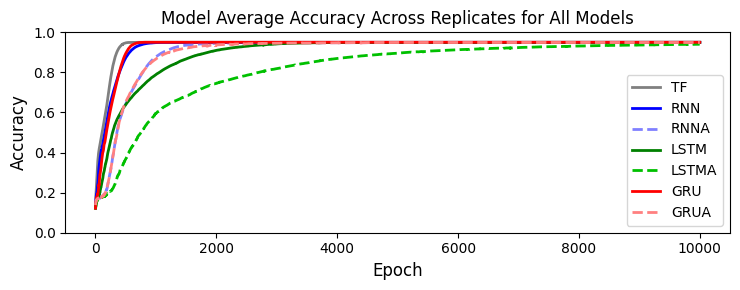

In [106]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'average_accuracy_dict' contains your data
kinds = ["TF", "RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]

# Adjust color lightness function
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

plt.figure(figsize=(7.5, 3))

for kind in kinds:
    avg_data = average_accuracy_dict[kind]
    if kind in base_colors:
        color = base_colors[kind]
        linestyle = '-'
    else:
        base_model = kind[:-1]
        color = adjust_lightness(base_colors[base_model], amount=1.5)
        linestyle = '--'
    
    plt.plot(avg_data, label=f"{kind}", linewidth=2, linestyle=linestyle, color=color)

plt.title("Model Average Accuracy Across Replicates for All Models", fontsize = 12)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize =12)
plt.legend()
plt.grid(False)
plt.ylim(0, 1)  # Set the y-axis limit to show maximum value of 1
plt.tight_layout()
plt.savefig("./Final-Plots/Model_Accuracy.pdf")  # Saving the plot as PDF
plt.show()


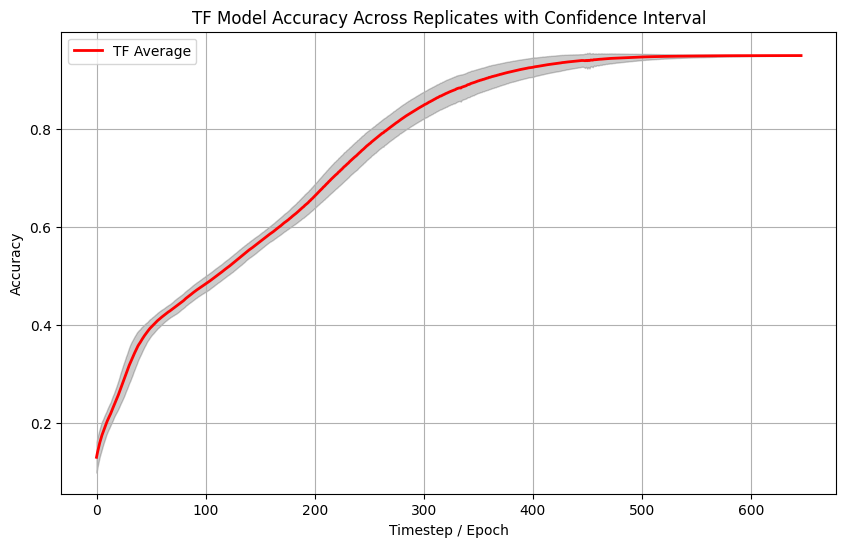

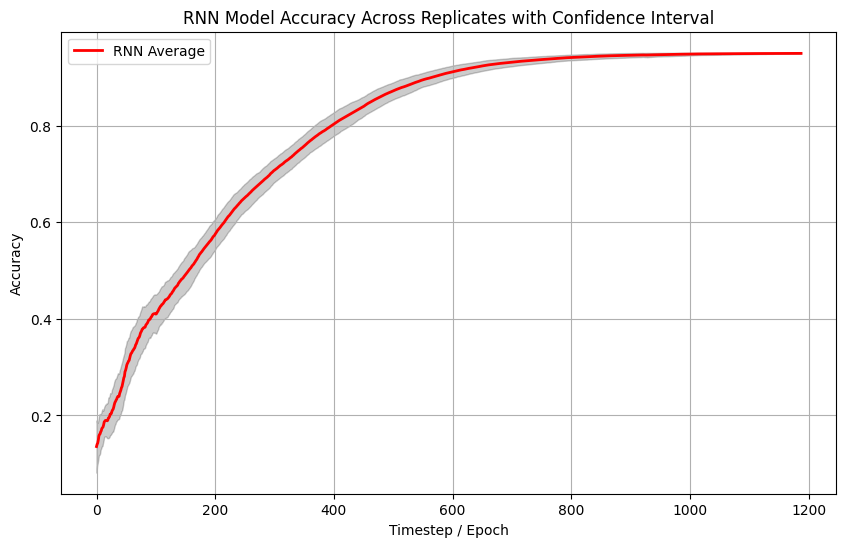

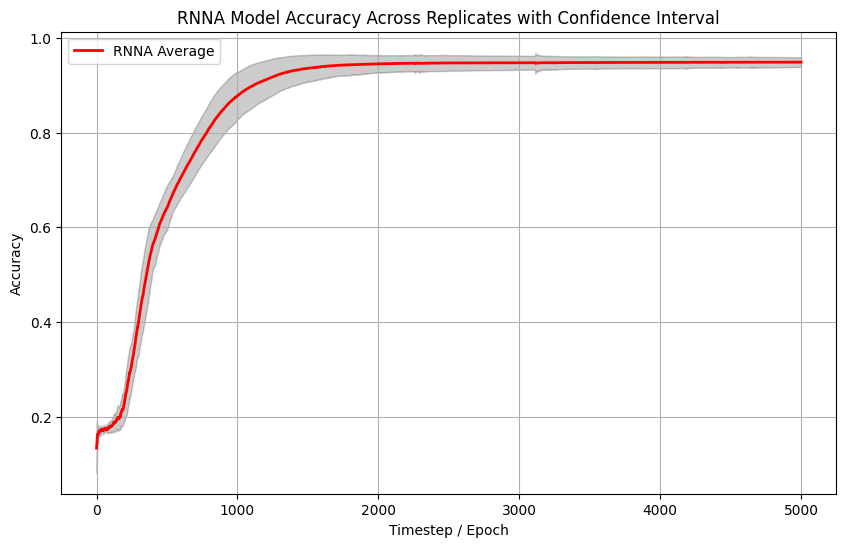

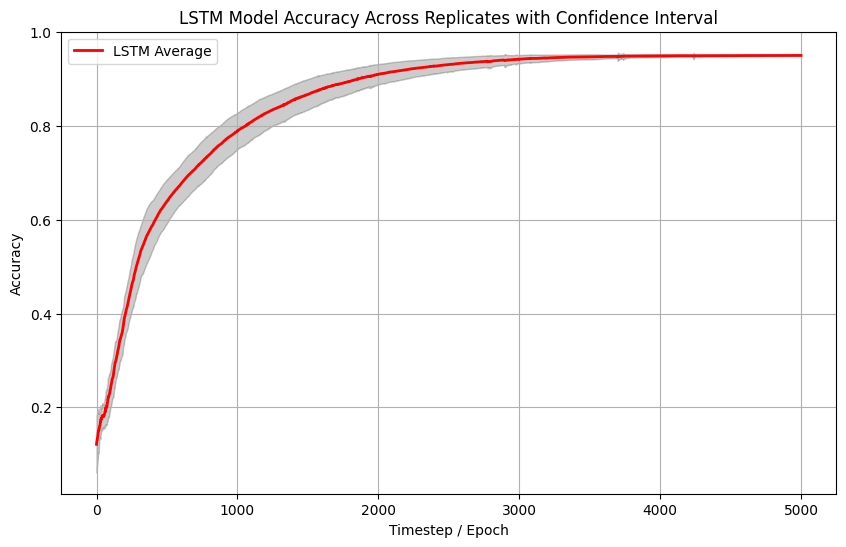

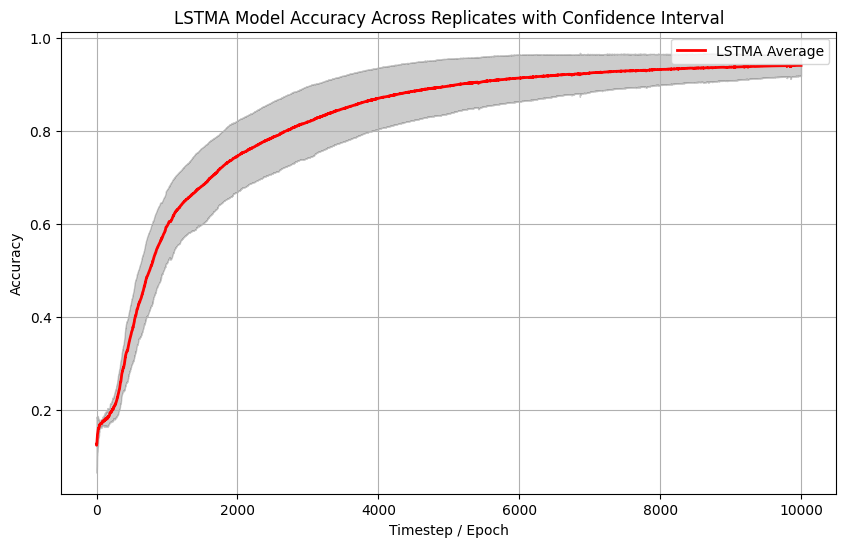

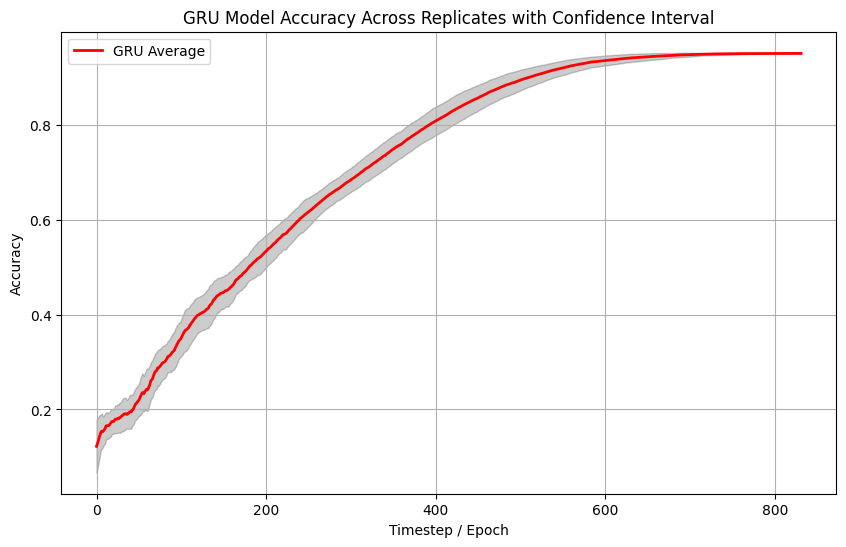

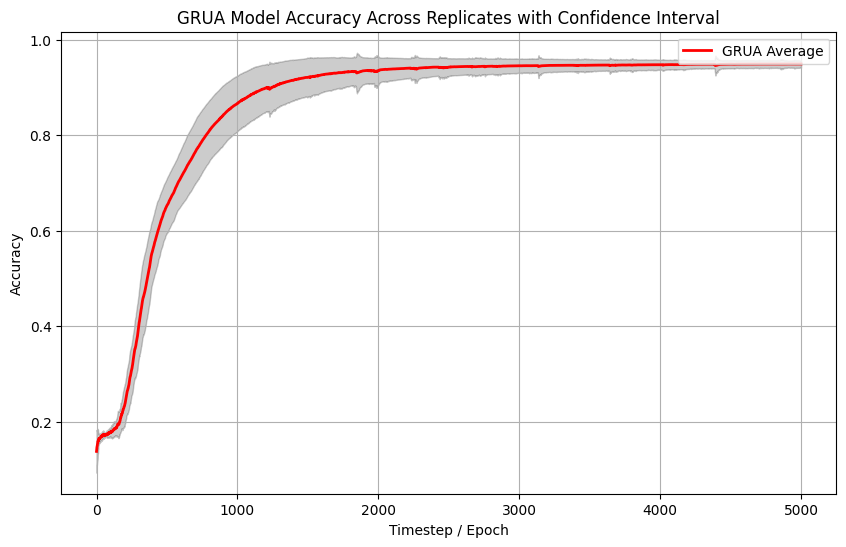

In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the kinds of models and the number of replicates
kinds = ["TF", "RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
num_reps = 50
base_path = './dataAcc'  # Adjust this to your actual directory

# Initialize a dictionary to hold the padded data for plotting
padded_rep_data_dict = {}

for kind in kinds:
    rep_data = []  # To store accuracy data from all replicates
    max_length = 0  # To find the maximum length of rows among all files
    
    # First pass: find the max length and collect data
    for rep in range(num_reps):
        filename = f'acc_{kind}_{rep}.csv'
        filepath = os.path.join(base_path, filename)
        try:
            data = pd.read_csv(filepath)['acc']
            rep_data.append(data)
            max_length = max(max_length, len(data))  # Update the max_length if current data is longer
        except FileNotFoundError:
            print(f"File not found: {filepath}")
            continue
    
    if not rep_data:
        print(f"No data found for {kind}, skipping...")
        continue
    
    # Second pass: pad data to max_length
    padded_rep_data = []
    for data in rep_data:
        last_value = data.iloc[-1]  # Get the last value to use for padding
        padded_data = np.pad(data, (0, max_length - len(data)), 'constant', constant_values=(last_value))
        padded_rep_data.append(padded_data)
    
    padded_rep_data_dict[kind] = padded_rep_data  # Store the padded data for plotting

# Plotting for each kind with padded data and confidence intervals
for kind, padded_rep_data in padded_rep_data_dict.items():
    # Convert to NumPy array for easier manipulation
    data_array = np.array(padded_rep_data)
    
    # Calculating the mean and standard deviation across all replicates at each timestep
    mean_data = np.mean(data_array, axis=0)
    std_data = np.std(data_array, axis=0)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(mean_data, label=f"{kind} Average", linewidth=2, color='red')
    
    # Adding the confidence interval as a shaded area
    plt.fill_between(range(len(mean_data)), mean_data - std_data, mean_data + std_data, color='black', alpha=0.2)
    
    # Configuring the plot
    plt.title(f"{kind} Model Accuracy Across Replicates with Confidence Interval")
    plt.xlabel("Timestep / Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


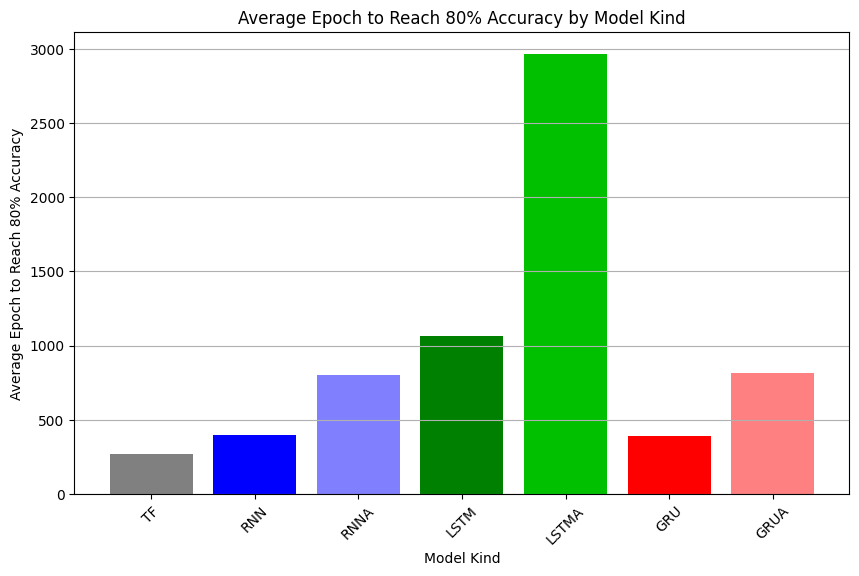

In [26]:
import matplotlib.pyplot as plt
import numpy as np


average_epochs_to_80 = {}

for kind, padded_rep_data in padded_rep_data_dict.items():
    epochs_to_80 = []
    for data in padded_rep_data:
        # Find the index (epoch) where accuracy reaches or exceeds 80%
        epoch_index = np.where(data >= 0.8)[0]
        if len(epoch_index) > 0:  # If at least one epoch meets the criterion
            epochs_to_80.append(epoch_index[0])
    
    if epochs_to_80:
        # Calculate the average epoch across replicates for the current kind
        average_epochs_to_80[kind] = np.mean(epochs_to_80)
    else:
        average_epochs_to_80[kind] = None  # No replicates reached 80% accuracy

# Assuming 'average_epochs_to_80' is your calculated dictionary
kinds = list(average_epochs_to_80.keys())
averages = [average_epochs_to_80[kind] for kind in kinds]

# Manually select base colors for each model type
base_colors = {
    "TF": "gray",
    "RNN": "blue",
    "LSTM": "green",
    "GRU": "red"
}

# Function to adjust color lightness (same as previously described)
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

# Assign colors to each kind, adjusting for augmented models
colors = []
for kind in kinds:
    if kind in base_colors:  # Base model
        colors.append(base_colors[kind])
    else:  # Augmented model, make the color lighter
        base_model = kind[:-1]  # Remove the "A" to get the base model
        colors.append(adjust_lightness(base_colors[base_model], amount=1.5))

# Now to plot these averages as a bar plot
plt.figure(figsize=(10, 6))

plt.bar(kinds, averages, color=colors)
plt.xlabel('Model Kind')
plt.ylabel('Average Epoch to Reach 80% Accuracy')
plt.title('Average Epoch to Reach 80% Accuracy by Model Kind')
plt.xticks(rotation=45)  # Rotate labels to avoid overlap
plt.grid(axis='y')

plt.show()


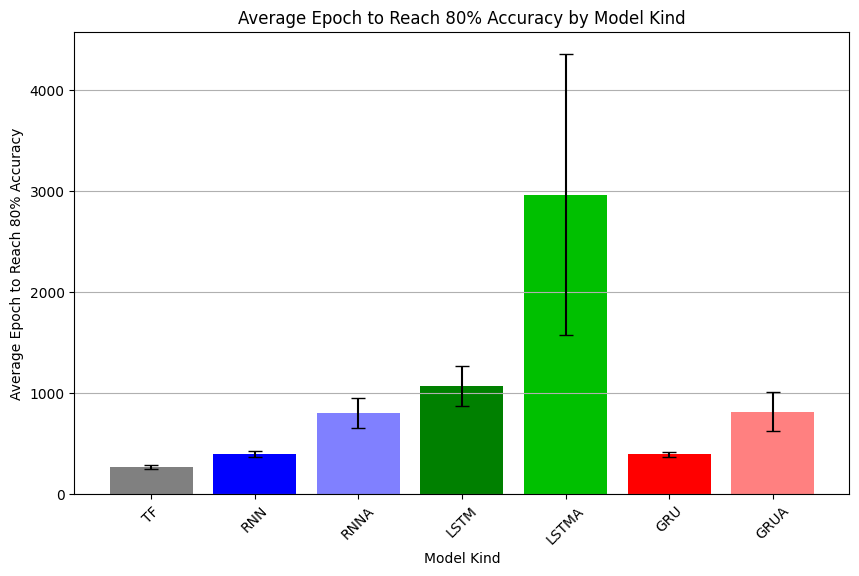

In [27]:
import matplotlib.pyplot as plt
import numpy as np

average_epochs_to_80 = {}
std_dev_epochs_to_80 = {}  # To store standard deviations

for kind, padded_rep_data in padded_rep_data_dict.items():
    epochs_to_80 = []
    for data in padded_rep_data:
        epoch_index = np.where(data >= 0.8)[0]
        if len(epoch_index) > 0:
            epochs_to_80.append(epoch_index[0])
    
    if epochs_to_80:
        average_epochs_to_80[kind] = np.mean(epochs_to_80)
        std_dev_epochs_to_80[kind] = np.std(epochs_to_80)  # Calculate standard deviation
    else:
        average_epochs_to_80[kind] = None
        std_dev_epochs_to_80[kind] = None

kinds = list(average_epochs_to_80.keys())
averages = [average_epochs_to_80[kind] for kind in kinds]
errors = [std_dev_epochs_to_80[kind] for kind in kinds]  # Errors for the plot

# The rest of your code for color settings remains unchanged

# Now, when plotting, include the 'yerr' parameter to add error bars
plt.figure(figsize=(10, 6))
plt.bar(kinds, averages, color=colors, yerr=errors, capsize=5)  # capsize adds horizontal lines at the tops
plt.xlabel('Model Kind')
plt.ylabel('Average Epoch to Reach 80% Accuracy')
plt.title('Average Epoch to Reach 80% Accuracy by Model Kind')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.show()


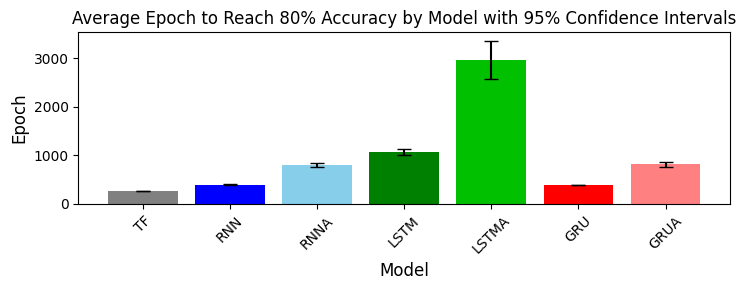

In [105]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Assuming 'padded_rep_data_dict' is predefined and contains your data
# Example structure: {'ModelType': array_of_epochs_to_reach_80%_accuracy, ...}

average_epochs_to_80 = {}
conf_intervals = {}  # To store confidence intervals

for kind, padded_rep_data in padded_rep_data_dict.items():
    epochs_to_80 = []
    for data in padded_rep_data:
        epoch_index = np.where(data >= 0.8)[0]
        if len(epoch_index) > 0:
            epochs_to_80.append(epoch_index[0])
    
    if epochs_to_80:
        average_epochs_to_80[kind] = np.mean(epochs_to_80)
        # Calculate the standard error of the mean (SEM)
        sem = stats.sem(epochs_to_80)
        # Determine the size of the sample
        n = len(epochs_to_80)
        # Get the t-critical value for 95% confidence
        t_critical = stats.t.ppf(0.975, n-1)  # two-tailed, and n-1 degrees of freedom
        # Calculate the margin of error
        margin_of_error = t_critical * sem
        # Store the margin of error (the "error" for plotting)
        conf_intervals[kind] = margin_of_error
    else:
        average_epochs_to_80[kind] = None
        conf_intervals[kind] = None

kinds = list(average_epochs_to_80.keys())
averages = [average_epochs_to_80[kind] for kind in kinds]
errors = [conf_intervals[kind] if kind in conf_intervals else 0 for kind in kinds]  # Confidence interval margins for the plot

# Manually select base colors for each model type
base_colors = {
    "TF": "gray",
    "RNN": "blue",
    "LSTM": "green",
    "GRU": "red"
}

# Function to adjust color lightness
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    if color == 'blue':
        return "#87CEEB"
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

# Assign colors to each kind, adjusting for augmented models
colors = []
for kind in kinds:
    if kind in base_colors:  # Base model
        colors.append(base_colors[kind])
    else:  # Augmented model, make the color lighter
        base_model = kind[:-1]  # Remove the "A" to get the base model
        colors.append(adjust_lightness(base_colors[base_model], amount=1.5))

# Plotting with confidence intervals
plt.figure(figsize=(7.5, 3))
plt.bar(kinds, averages, color=colors, yerr=errors, capsize=5)
plt.xlabel('Model', fontsize=12) # 12 lower or 16 higher
plt.ylabel('Epoch', fontsize = 12)
plt.title('Average Epoch to Reach 80% Accuracy by Model with 95% Confidence Intervals', fontsize = 12)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.grid(False)
plt.tight_layout()
plt.savefig("./Final-Plots/Model_Epoch.pdf")  # Saving the plot as PDF
plt.show()


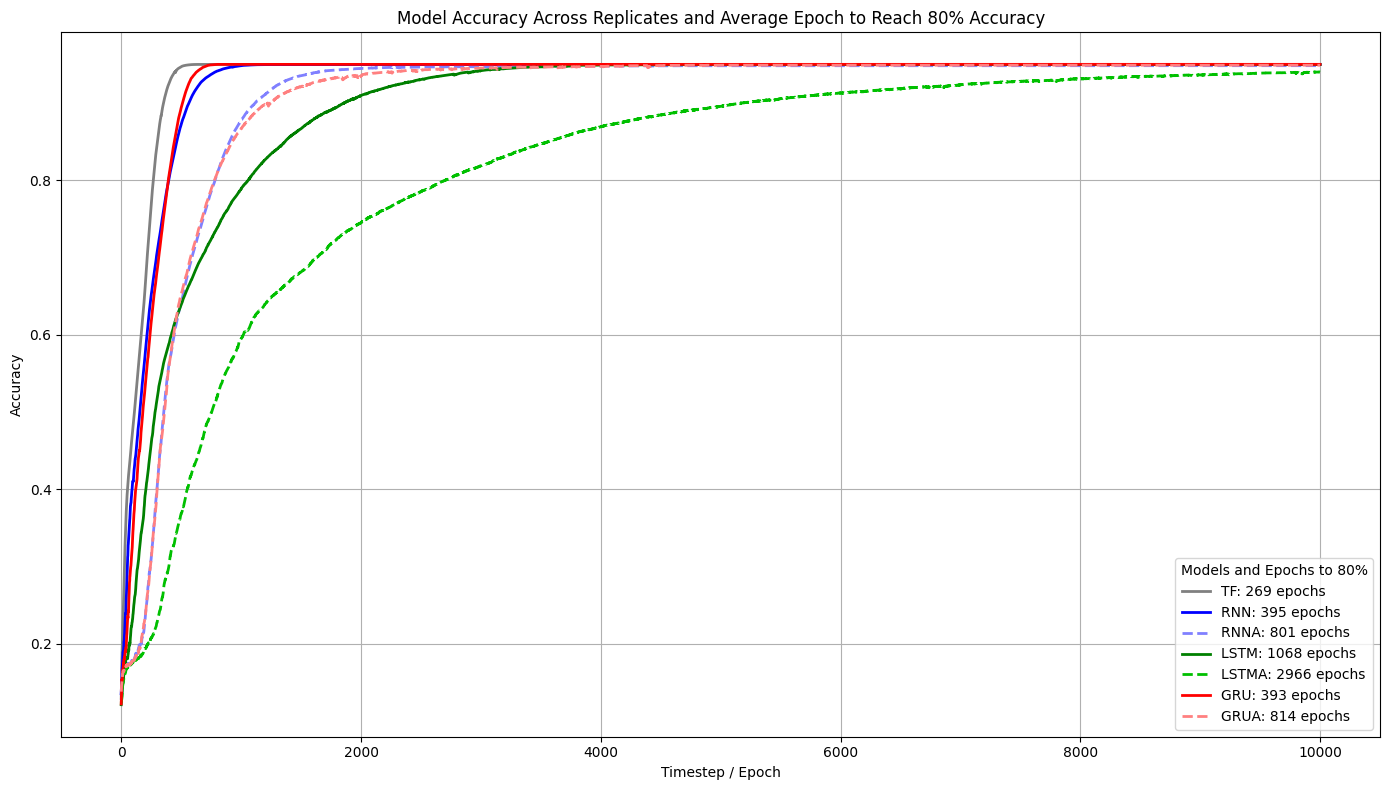

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines

# Main plot for accuracy over time
fig, ax = plt.subplots(figsize=(14, 8))

# Track handles for custom legend entries
custom_legend_handles = []

# Plot accuracy for each model
for kind in kinds:
    avg_data = average_accuracy_dict[kind]
    if kind in base_colors:  # Base model
        color = base_colors[kind]
        linestyle = '-'
    else:  # Augmented model
        base_model = kind[:-1]  # Remove the "A" to find the base model
        color = adjust_lightness(base_colors[base_model], amount=1.5)
        linestyle = '--'
    # Plot and add to legend handles
    line = ax.plot(avg_data, label=f"{kind}", linewidth=2, linestyle=linestyle, color=color)[0]
    custom_legend_handles.append(line)

# Modify each handle in the custom legend to include average epochs to reach 80% accuracy
for handle, kind in zip(custom_legend_handles, kinds):
    avg_epoch = average_epochs_to_80.get(kind, "N/A")
    handle.set_label(f"{kind}: {round(avg_epoch)} epochs")

ax.set_title("Model Accuracy Across Replicates and Average Epoch to Reach 80% Accuracy")
ax.set_xlabel("Timestep / Epoch")
ax.set_ylabel("Accuracy")
ax.grid(True)

# Add custom legend to the plot, placing it in the bottom right corner
ax.legend(handles=custom_legend_handles, loc='lower right', title="Models and Epochs to 80%")

plt.tight_layout()
plt.show()


/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_60720/2364384553.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


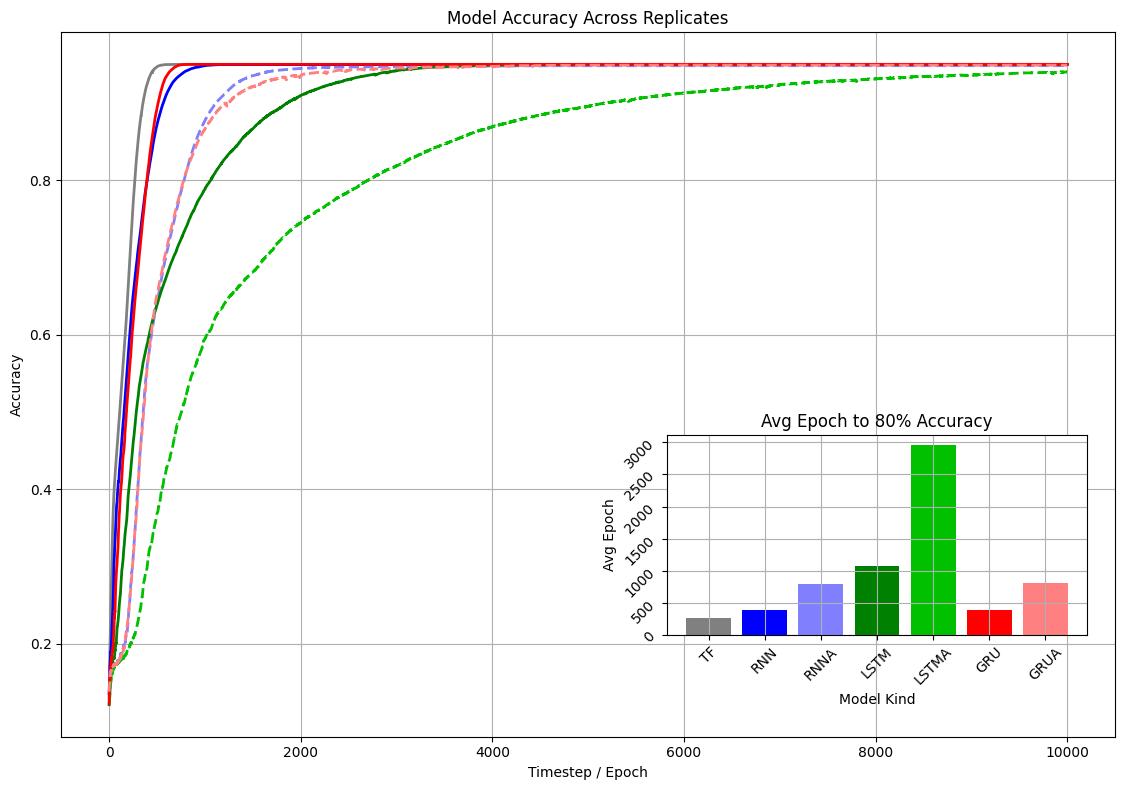

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines

# Assuming 'average_epochs_to_80', 'average_accuracy_dict', and 'base_colors' are predefined

# Function to adjust color lightness
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

# Create the main plot (accuracy over time)
fig, ax = plt.subplots(figsize=(14, 8))
custom_legend_handles = []

for kind, avg_data in average_accuracy_dict.items():
    if kind in base_colors:  # Base model
        color = base_colors[kind]
        linestyle = '-'
    else:  # Augmented model
        base_model = kind[:-1]  # Remove the "A" to find the base model
        color = adjust_lightness(base_colors[base_model], amount=1.5)
        linestyle = '--'
    line = ax.plot(avg_data, label=f"{kind}", linewidth=2, linestyle=linestyle, color=color)[0]
    custom_legend_handles.append(line)

ax.set_title("Model Accuracy Across Replicates")
ax.set_xlabel("Timestep / Epoch")
ax.set_ylabel("Accuracy")
ax.grid(True)

# Position the legend above the inset plot on the bottom right
#legend = ax.legend(handles=custom_legend_handles, loc='lower right', bbox_to_anchor=(1, 0.1), title="Models")

# Insert the inset plot (bar plot for average epochs to reach 80% accuracy) in the bottom right corner
# Adjust these values to move the inset plot to the bottom right and possibly below the legend
inset_ax_position = [0.48, 0.2, 0.3, 0.25]  # [left, bottom, width, height]
inset_ax = fig.add_axes(inset_ax_position)

kinds = list(average_epochs_to_80.keys())
averages = [average_epochs_to_80[kind] for kind in kinds]

colors = []
for kind in kinds:
    if kind in base_colors:
        colors.append(base_colors[kind])
    else:
        base_model = kind[:-1]
        colors.append(adjust_lightness(base_colors[base_model], amount=1.5))

inset_ax.bar(kinds, averages, color=colors)
inset_ax.set_title('Avg Epoch to 80% Accuracy')
inset_ax.set_xlabel('Model Kind')
inset_ax.set_ylabel('Avg Epoch')
inset_ax.tick_params(labelrotation=45)
inset_ax.grid(True)

plt.tight_layout()
# Adjust figure layout to make room for the legend outside the main axes
plt.subplots_adjust(right=0.8)
plt.show()


# Generate M for all Models and calculations


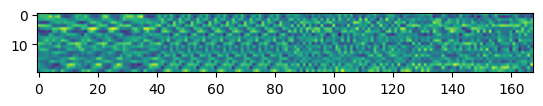

In [88]:
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA", "TF"]  # Assuming you have these types
nrOfSongs  = 4
source, O_hot, target, songs = generateIOData(nrOfSongs, songStrings)
model_matrices = {}

num_reps = 50
# For each model, process the data and plot the resulting matrix
for kind in kinds:
    if kind == "TF":
        source,target,songs=getTrainingData(songStrings,nrOfSongs)

    for rep in range(num_reps):
        model_identifier = model_identifier = f'{kind}-{rep}'

        model = torch.load(f'./dataModelsSongs/{kind}_{rep}.model')
        model.eval()  # Set the model to evaluation mode if you're doing inference

        s, h = shrinkingDecompositionInformation(model, source, target, songs, numbers=list(range(4)), width=20, model_name = kind)
        M = removalIntoMatrix(s, 20, h)
        model_matrices[model_identifier] = M


In [89]:

with open('model_songs_matrices.pkl', 'wb') as file:
    pickle.dump(model_matrices, file)

In [35]:
with open('model_songs_matrices.pkl', 'rb') as file:
    model_matrices = pickle.load(file)

In [36]:
# List to hold data for DataFrame
df_m = []

# Loop through the model_matrices dictionary
for model_identifier, M in model_matrices.items():
    # Create a dictionary for each model with its identifier and matrix
    model_data = {
        'Model Identifier': model_identifier,
        'Matrix': M
    }
    df_m.append(model_data)

# Create DataFrame from the list of dictionaries
models_M = pd.DataFrame(df_m)

# Display the DataFrame
print(models_M)

    Model Identifier                                             Matrix
0              RNN-0  [[0.7603615344483519, 0.8111313261922852, 0.81...
1              RNN-1  [[0.7472609369462537, 0.4025095579701947, 0.81...
2              RNN-2  [[0.13395192824253677, 0.0, 0.6740993404019378...
3              RNN-3  [[0.010053438674871629, 0.7990524322571204, 0....
4              RNN-4  [[0.8112781244591325, 0.7919619786386747, 0.74...
..               ...                                                ...
345            TF-45  [[0.670055857112323, 0.2272691276628338, 0.686...
346            TF-46  [[0.534812480239574, 0.386591715150125, 0.0091...
347            TF-47  [[0.4151775021317423, 0.4631830471690668, 0.43...
348            TF-48  [[0.03510306088645443, 0.5505683074497885, 0.5...
349            TF-49  [[0.5886767285060346, 0.6050748683998624, 0.62...

[350 rows x 2 columns]


In [37]:
results = []


for index, row in models_M.iterrows():
    model_identifier = row['Model Identifier']
    M = row['Matrix']
    kind, rep = model_identifier.split('-')                
    # Calculate metrics
    sum_abs = np.sum(np.abs(M))
    mean = np.mean(M)
    std = np.std(M)
    max_val = np.max(M)
    min_val = np.min(M)

    threshold_song_1, count_exceeding_song_1 = kmeans_thresholding(M[0]) # fix this K means of A alone then B alone
    threshold_song_2, count_exceeding_song_2 = kmeans_thresholding(M[1]) # fix this K means of A alone then B alone
    threshold_song_3, count_exceeding_song_3 = kmeans_thresholding(M[2]) # fix this K means of A alone then B alone
    threshold_song_4, count_exceeding_song_4 = kmeans_thresholding(M[3]) # fix this K means of A alone then B alone

    binarized_matrix_song_1 = np.where(M[0].flatten() >= threshold_song_1, 1, 0).reshape(M[0].shape) 
    binarized_matrix_song_2 = np.where(M[1].flatten() >= threshold_song_2, 1, 0).reshape(M[1].shape)
    binarized_matrix_song_3 = np.where(M[2].flatten() >= threshold_song_3, 1, 0).reshape(M[2].shape)
    binarized_matrix_song_4 = np.where(M[3].flatten() >= threshold_song_4, 1, 0).reshape(M[3].shape)

    # Vertically stack binarized_matrix_A and binarized_matrix_B
    binarized_combined_matrix = np.vstack([binarized_matrix_song_1, binarized_matrix_song_2, binarized_matrix_song_3, binarized_matrix_song_4])

    degree_2, degree_3, degree_4  = calculate_degrees_of_overlap(binarized_combined_matrix)

    min_values = np.min(binarized_combined_matrix, axis=0)

    # Clip these values between 0 and 1
    clipped_min_values = np.clip(min_values, 0, 1)

    # Sum the clipped values
    sum_clipped_min_values = np.sum(clipped_min_values) # fixed this

    # Counting the number of 1's in each column
    ones_count = np.sum(binarized_combined_matrix, axis=0)
    # Calculating the overlap percentage for each column
    # Initialize the overlap percentage array
    overlap_percentage_per_column = np.zeros(ones_count.shape)
    # Setting the overlap percentage based on the number of 1's in each column
    overlap_percentage_per_column[ones_count == 2] = .5
    overlap_percentage_per_column[ones_count == 3] = .75
    overlap_percentage_per_column[ones_count == 4] = 1
    # Calculating the overall overlap percentage across all columns
    overall_overlap_percentage = (np.sum(overlap_percentage_per_column) / (ones_count.shape[0])) * 100

  
    
    metrics = {
        "Kind": kind,
        "Repetition": int(rep),
        "Sum of Absolute Values": round(sum_abs,4),
        "Mean Value": round(mean,4),
        "Standard Deviation": round(std, 4),
        "Maximum Value": round(max_val,4),
        "Minimum Value": round(min_val,4),
        "Kmeans_song_1_treshold": round(threshold_song_1,4),
        "Kmeans_song_2_treshold": round(threshold_song_2,4),
        "Kmeans_song_3_treshold": round(threshold_song_3,4),
        "Kmeans_song_4_treshold": round(threshold_song_4,4),
        "Song_1_Nodes_exceeding_treshold": count_exceeding_song_1,
        "Song_2_Nodes_exceeding_treshold": count_exceeding_song_2,
        "Song_3_Nodes_exceeding_treshold": count_exceeding_song_3,
        "Song_4_Nodes_exceeding_treshold": count_exceeding_song_4,
        "Total_Nodes_exceeding_treshold": count_exceeding_song_1 + count_exceeding_song_2 + count_exceeding_song_3 + count_exceeding_song_4,
        "degree_2_overlapp": degree_2,
        "degree_3_overlapp": degree_3,
        "degree_4_overlapp": degree_4,
        "sum_of_degree_overlapp": degree_2 + degree_3 + degree_4,
        "Total_Overlapp_percentage" : overall_overlap_percentage,
        "overlapp_column1":overlap_percentage_per_column[0],
        "overlapp_column2":overlap_percentage_per_column[1],
        "overlapp_column3":overlap_percentage_per_column[2],
        "overlapp_column4":overlap_percentage_per_column[3],
        "overlapp_column5":overlap_percentage_per_column[4],
        "overlapp_column6":overlap_percentage_per_column[5],
        "overlapp_column7":overlap_percentage_per_column[6],
        "overlapp_column8":overlap_percentage_per_column[7],
        "overlapp_column9":overlap_percentage_per_column[8],
        "overlapp_column10":overlap_percentage_per_column[9],
        "overlapp_column11":overlap_percentage_per_column[10],
        "overlapp_column12":overlap_percentage_per_column[11],
        "overlapp_column13":overlap_percentage_per_column[12],
        "overlapp_column14":overlap_percentage_per_column[13],
        "overlapp_column15":overlap_percentage_per_column[14],
        "overlapp_column16":overlap_percentage_per_column[15],
        "overlapp_column17":overlap_percentage_per_column[16],
        "overlapp_column18":overlap_percentage_per_column[17],
        "overlapp_column19":overlap_percentage_per_column[18],
        "overlapp_column20":overlap_percentage_per_column[19],
        #"Biniarized Matrix": binarized_combined_matrix,
    }
    num_songs = 4
    # Assuming all songs have the same number of features/columns for simplicity
    num_columns = binarized_matrix_song_1.shape[0]  # Number of columns/features per song

    # Dictionary to store pairwise "11" overlaps for each song pair across all columns
    pair_11_overlaps = {}

    # Iterate through all song combinations
    for (i, j) in itertools.combinations(range(num_songs), 2):
        # Initialize a count for each song pair
        pair_11_overlaps[f'song_{i+1}_song_{j+1}_11_overlap'] = 0

        # For each column, check if both songs have a "1" in the same position
        for col in range(num_columns):
            if binarized_combined_matrix[i, col] == 1 and binarized_combined_matrix[j, col] == 1:
                # If both songs have "1" in the same column, increment the count
                pair_11_overlaps[f'song_{i+1}_song_{j+1}_11_overlap'] += 1

    # Update the metrics dictionary to include the "11" overlaps
    metrics.update(pair_11_overlaps)
    results.append(metrics)
    
df = pd.DataFrame(results)



In [39]:
df

Kind  Repetition  Sum of Absolute Values  Mean Value  Standard Deviation  \
0    RNN           0                 38.2479      0.4781              0.2960   
1    RNN           1                 38.8308      0.4854              0.3045   
2    RNN           2                 39.4933      0.4937              0.2961   
3    RNN           3                 38.1032      0.4763              0.3023   
4    RNN           4                 39.3687      0.4921              0.2991   
..   ...         ...                     ...         ...                 ...   
345   TF          45                 30.2727      0.3781              0.2479   
346   TF          46                 32.2177      0.4026              0.2631   
347   TF          47                 30.8301      0.3854              0.2471   
348   TF          48                 29.8787      0.3729              0.2566   
349   TF          49                 32.3099      0.4038              0.2564   

     Maximum Value  Minimum Value  Kmeans_song_1_treshold  \
0           0.8113         0.0000                  0.4262   
1           0.8113         0.0000                  0.4252   
2           0.8112        -0.0006                  0.3931   
3           0.8112         0.0000                  0.4171   
4           0.8113         0.0000                  0.4152   
..             ...            ...                     ...   
345         0.7755        -0.0056                  0.3177   
346         0.8113        -0.0031                  0.3062   
347         0.7993         0.0000                  0.2854   
348         0.7688        -0.0106                  0.3395   
349         0.7949        -0.0023                  0.3312   

     Kmeans_song_2_treshold  Kmeans_song_3_treshold  ...  overlapp_column17  \
0                    0.4276                  0.3893  ...               0.00   
1                    0.4234                  0.3994  ...               0.50   
2                    0.4315                  0.4274  ...               0.75   
3                    0.4148                  0.3872  ...               1.00   
4                    0.4148                  0.3851  ...               1.00   
..                      ...                     ...  ...                ...   
345                  0.3988                  0.2930  ...               1.00   
346                  0.3427                  0.3684  ...               0.00   
347                  0.3441                  0.3552  ...               0.50   
348                  0.3749                  0.3409  ...               0.50   
349                  0.3824                  0.3026  ...               0.00   

     overlapp_column18  overlapp_column19  overlapp_column20  \
0                 0.50               0.00               1.00   
1                 0.00               0.00               0.75   
2                 0.00               0.50               1.00   
3                 0.50               0.75               0.50   
4                 0.50               0.50               0.50   
..                 ...                ...                ...   
345               0.75               0.00               0.00   
346               0.00               0.75               0.75   
347               0.50               0.75               0.75   
348               0.00               1.00               0.00   
349               1.00               0.00               0.50   

     song_1_song_2_11_overlap  song_1_song_3_11_overlap  \
0                           9                         9   
1                           8                         7   
2                          10                         6   
3                           9                         9   
4                          11                        10   
..                        ...                       ...   
345                         8                         7   
346                        10                         8   
347                         8                         7   
34

In [94]:
df.to_csv("songs_data.csv", index=False)

In [40]:
df = pd.read_csv("songs_data.csv")

In [41]:
df

Kind  Repetition  Sum of Absolute Values  Mean Value  Standard Deviation  \
0    RNN           0                 38.2479      0.4781              0.2960   
1    RNN           1                 38.8308      0.4854              0.3045   
2    RNN           2                 39.4933      0.4937              0.2961   
3    RNN           3                 38.1032      0.4763              0.3023   
4    RNN           4                 39.3687      0.4921              0.2991   
..   ...         ...                     ...         ...                 ...   
345   TF          45                 30.2727      0.3781              0.2479   
346   TF          46                 32.2177      0.4026              0.2631   
347   TF          47                 30.8301      0.3854              0.2471   
348   TF          48                 29.8787      0.3729              0.2566   
349   TF          49                 32.3099      0.4038              0.2564   

     Maximum Value  Minimum Value  Kmeans_song_1_treshold  \
0           0.8113         0.0000                  0.4262   
1           0.8113         0.0000                  0.4252   
2           0.8112        -0.0006                  0.3931   
3           0.8112         0.0000                  0.4171   
4           0.8113         0.0000                  0.4152   
..             ...            ...                     ...   
345         0.7755        -0.0056                  0.3177   
346         0.8113        -0.0031                  0.3062   
347         0.7993         0.0000                  0.2854   
348         0.7688        -0.0106                  0.3395   
349         0.7949        -0.0023                  0.3312   

     Kmeans_song_2_treshold  Kmeans_song_3_treshold  ...  overlapp_column17  \
0                    0.4276                  0.3893  ...               0.00   
1                    0.4234                  0.3994  ...               0.50   
2                    0.4315                  0.4274  ...               0.75   
3                    0.4148                  0.3872  ...               1.00   
4                    0.4148                  0.3851  ...               1.00   
..                      ...                     ...  ...                ...   
345                  0.3988                  0.2930  ...               1.00   
346                  0.3427                  0.3684  ...               0.00   
347                  0.3441                  0.3552  ...               0.50   
348                  0.3749                  0.3409  ...               0.50   
349                  0.3824                  0.3026  ...               0.00   

     overlapp_column18  overlapp_column19  overlapp_column20  \
0                 0.50               0.00               1.00   
1                 0.00               0.00               0.75   
2                 0.00               0.50               1.00   
3                 0.50               0.75               0.50   
4                 0.50               0.50               0.50   
..                 ...                ...                ...   
345               0.75               0.00               0.00   
346               0.00               0.75               0.75   
347               0.50               0.75               0.75   
348               0.00               1.00               0.00   
349               1.00               0.00               0.50   

     song_1_song_2_11_overlap  song_1_song_3_11_overlap  \
0                           9                         9   
1                           8                         7   
2                          10                         6   
3                           9                         9   
4                          11                        10   
..                        ...                       ...   
345                         8                         7   
346                        10                         8   
347                         8                         7   
34

In [42]:

rnn_rows = df[df["Kind"] == "RNN"]
rnn_rows.mean()

/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_73675/91418193.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  rnn_rows.mean()


Repetition                         24.500000
Sum of Absolute Values             38.421578
Mean Value                          0.480240
Standard Deviation                  0.299574
Maximum Value                       0.811280
Minimum Value                      -0.000808
Kmeans_song_1_treshold              0.415386
Kmeans_song_2_treshold              0.416936
Kmeans_song_3_treshold              0.397806
Kmeans_song_4_treshold              0.404234
Song_1_Nodes_exceeding_treshold    13.020000
Song_2_Nodes_exceeding_treshold    13.140000
Song_3_Nodes_exceeding_treshold    11.800000
Song_4_Nodes_exceeding_treshold    12.120000
Total_Nodes_exceeding_treshold     50.080000
degree_2_overlapp                   5.980000
degree_3_overlapp                   6.780000
degree_4_overlapp                   3.720000
sum_of_degree_overlapp             16.480000
Total_Overlapp_percentage          58.975000
overlapp_column1                    0.555000
overlapp_column2                    0.590000
overlapp_c

In [12]:

rnna_rows = df[df["Kind"] == "RNNA"]
rnna_rows.mean()

/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_24922/4202277059.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  rnna_rows.mean()


Repetition                         24.500000
Sum of Absolute Values             28.773840
Mean Value                          0.359538
Standard Deviation                  0.268728
Maximum Value                       0.798754
Minimum Value                      -0.003922
Kmeans_song_1_treshold              0.401202
Kmeans_song_2_treshold              0.372404
Kmeans_song_3_treshold              0.338648
Kmeans_song_4_treshold              0.345418
Song_1_Nodes_exceeding_treshold    12.420000
Song_2_Nodes_exceeding_treshold     9.080000
Song_3_Nodes_exceeding_treshold     8.420000
Song_4_Nodes_exceeding_treshold     8.520000
Total_Nodes_exceeding_treshold     38.440000
degree_2_overlapp                   5.060000
degree_3_overlapp                   4.480000
degree_4_overlapp                   2.120000
sum_of_degree_overlapp             11.660000
Total_Overlapp_percentage          40.050000
overlapp_column1                    0.375000
overlapp_column2                    0.415000
overlapp_c

In [13]:

lstm_rows = df[df["Kind"] == "LSTM"]
lstm_rows.mean()

/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_24922/72160083.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  lstm_rows.mean()


Repetition                         24.500000
Sum of Absolute Values             34.448072
Mean Value                          0.430506
Standard Deviation                  0.292756
Maximum Value                       0.810136
Minimum Value                      -0.002488
Kmeans_song_1_treshold              0.406022
Kmeans_song_2_treshold              0.406558
Kmeans_song_3_treshold              0.376414
Kmeans_song_4_treshold              0.381494
Song_1_Nodes_exceeding_treshold    12.120000
Song_2_Nodes_exceeding_treshold    11.700000
Song_3_Nodes_exceeding_treshold    10.660000
Song_4_Nodes_exceeding_treshold    11.000000
Total_Nodes_exceeding_treshold     45.480000
degree_2_overlapp                   6.260000
degree_3_overlapp                   5.680000
degree_4_overlapp                   2.980000
sum_of_degree_overlapp             14.920000
Total_Overlapp_percentage          51.850000
overlapp_column1                    0.520000
overlapp_column2                    0.510000
overlapp_c

In [14]:

lstma_rows = df[df["Kind"] == "LSTMA"]
lstma_rows.mean()

/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_24922/2824856349.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  lstma_rows.mean()


Repetition                         24.500000
Sum of Absolute Values             28.332298
Mean Value                          0.353924
Standard Deviation                  0.263230
Maximum Value                       0.804030
Minimum Value                      -0.004790
Kmeans_song_1_treshold              0.424456
Kmeans_song_2_treshold              0.370670
Kmeans_song_3_treshold              0.321668
Kmeans_song_4_treshold              0.326704
Song_1_Nodes_exceeding_treshold    12.780000
Song_2_Nodes_exceeding_treshold     7.880000
Song_3_Nodes_exceeding_treshold     7.980000
Song_4_Nodes_exceeding_treshold     8.920000
Total_Nodes_exceeding_treshold     37.560000
degree_2_overlapp                   7.080000
degree_3_overlapp                   3.160000
degree_4_overlapp                   1.940000
sum_of_degree_overlapp             12.180000
Total_Overlapp_percentage          39.250000
overlapp_column1                    0.335000
overlapp_column2                    0.280000
overlapp_c

In [15]:

gru_rows = df[df["Kind"] == "GRU"]
gru_rows.mean()

/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_24922/947642233.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  gru_rows.mean()


Repetition                         24.500000
Sum of Absolute Values             36.694078
Mean Value                          0.458570
Standard Deviation                  0.293238
Maximum Value                       0.810752
Minimum Value                      -0.003018
Kmeans_song_1_treshold              0.397810
Kmeans_song_2_treshold              0.407722
Kmeans_song_3_treshold              0.389588
Kmeans_song_4_treshold              0.397928
Song_1_Nodes_exceeding_treshold    12.800000
Song_2_Nodes_exceeding_treshold    12.820000
Song_3_Nodes_exceeding_treshold    11.560000
Song_4_Nodes_exceeding_treshold    11.580000
Total_Nodes_exceeding_treshold     48.760000
degree_2_overlapp                   5.480000
degree_3_overlapp                   6.260000
degree_4_overlapp                   3.960000
sum_of_degree_overlapp             15.700000
Total_Overlapp_percentage          56.975000
overlapp_column1                    0.520000
overlapp_column2                    0.615000
overlapp_c

In [16]:

grua_rows = df[df["Kind"] == "GRUA"]
grua_rows.mean()

/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_24922/2844744276.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  grua_rows.mean()


Repetition                         24.500000
Sum of Absolute Values             26.785312
Mean Value                          0.334740
Standard Deviation                  0.263060
Maximum Value                       0.792972
Minimum Value                      -0.002404
Kmeans_song_1_treshold              0.400072
Kmeans_song_2_treshold              0.354120
Kmeans_song_3_treshold              0.330792
Kmeans_song_4_treshold              0.334872
Song_1_Nodes_exceeding_treshold    12.140000
Song_2_Nodes_exceeding_treshold     8.120000
Song_3_Nodes_exceeding_treshold     7.600000
Song_4_Nodes_exceeding_treshold     7.860000
Total_Nodes_exceeding_treshold     35.720000
degree_2_overlapp                   4.600000
degree_3_overlapp                   4.200000
degree_4_overlapp                   1.640000
sum_of_degree_overlapp             10.440000
Total_Overlapp_percentage          35.450000
overlapp_column1                    0.475000
overlapp_column2                    0.260000
overlapp_c

In [17]:

tf_rows = df[df["Kind"] == "TF"]
tf_rows.mean()

/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_24922/1054653674.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  tf_rows.mean()


Repetition                         24.500000
Sum of Absolute Values             31.591802
Mean Value                          0.394552
Standard Deviation                  0.257892
Maximum Value                       0.789054
Minimum Value                      -0.008202
Kmeans_song_1_treshold              0.330390
Kmeans_song_2_treshold              0.363502
Kmeans_song_3_treshold              0.346288
Kmeans_song_4_treshold              0.368240
Song_1_Nodes_exceeding_treshold    11.740000
Song_2_Nodes_exceeding_treshold    12.200000
Song_3_Nodes_exceeding_treshold    11.420000
Song_4_Nodes_exceeding_treshold    11.800000
Total_Nodes_exceeding_treshold     47.160000
degree_2_overlapp                   6.300000
degree_3_overlapp                   6.460000
degree_4_overlapp                   2.940000
sum_of_degree_overlapp             15.700000
Total_Overlapp_percentage          54.675000
overlapp_column1                    0.430000
overlapp_column2                    0.590000
overlapp_c

In [101]:
from scipy.stats import mannwhitneyu

# Define the pairs of models to compare and the degrees of overlap to test
model_pairs = [('RNN', 'RNNA'), ('LSTM', 'LSTMA'), ('GRU', 'GRUA')]
degrees_of_overlap = [2, 3, 4]

# Define the significance level
alpha = 0.05

# Loop over each degree of overlap
for degree in degrees_of_overlap:
    print(f'\nComparing Degree {degree} Overlap:')
    # Loop over each pair of models
    for model_1, model_2 in model_pairs:
        # Extract data for the two models being compared
        data_1 = df[(df['Kind'] == model_1)][f'degree_{degree}_overlapp']
        data_2 = df[(df['Kind'] == model_2)][f'degree_{degree}_overlapp']
        
        # Perform the Mann-Whitney U test
        u_statistic, p_value = mannwhitneyu(data_1, data_2, alternative='two-sided')
        
        # Determine if the result is significant
        if p_value < alpha:
            print(f'{model_1} vs {model_2}: Significant Difference (P-Value={p_value:.12f})')
        else:
            print(f'{model_1} vs {model_2}: No Significant Difference (P-Value={p_value:.12f})')


Comparing Degree 2 Overlap:
RNN vs RNNA: Significant Difference (P-Value=0.009875985679)
LSTM vs LSTMA: No Significant Difference (P-Value=0.121377559349)
GRU vs GRUA: Significant Difference (P-Value=0.031579486525)

Comparing Degree 3 Overlap:
RNN vs RNNA: Significant Difference (P-Value=0.000000092954)
LSTM vs LSTMA: Significant Difference (P-Value=0.000000125283)
GRU vs GRUA: Significant Difference (P-Value=0.000001112478)

Comparing Degree 4 Overlap:
RNN vs RNNA: Significant Difference (P-Value=0.000000068310)
LSTM vs LSTMA: Significant Difference (P-Value=0.000072351913)
GRU vs GRUA: Significant Difference (P-Value=0.000000000011)


In [47]:
L = len(df['Song_1_Nodes_exceeding_treshold'])
X  = np.random.normal(0,0.2,(L))
Y  = np.random.normal(0,0.2,(L))


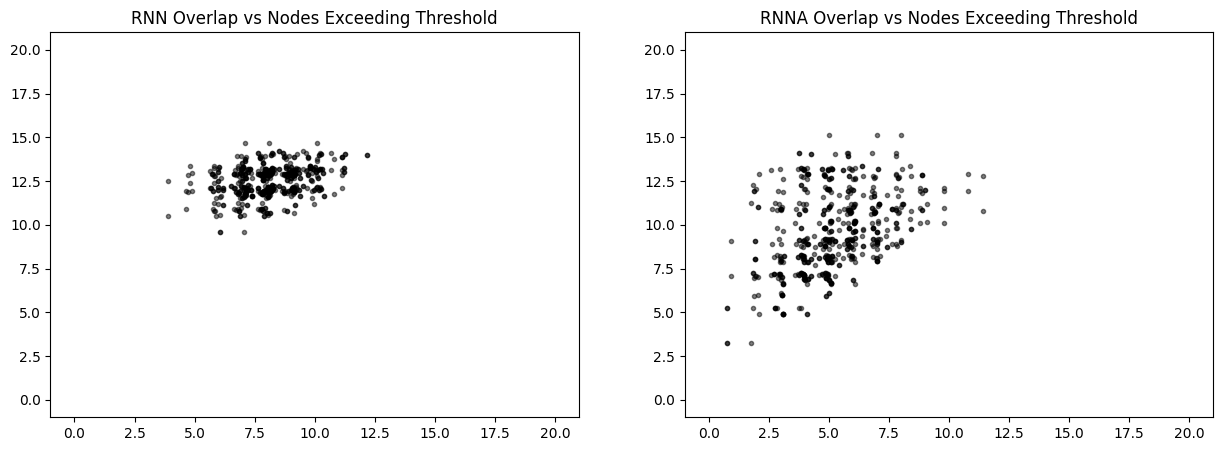

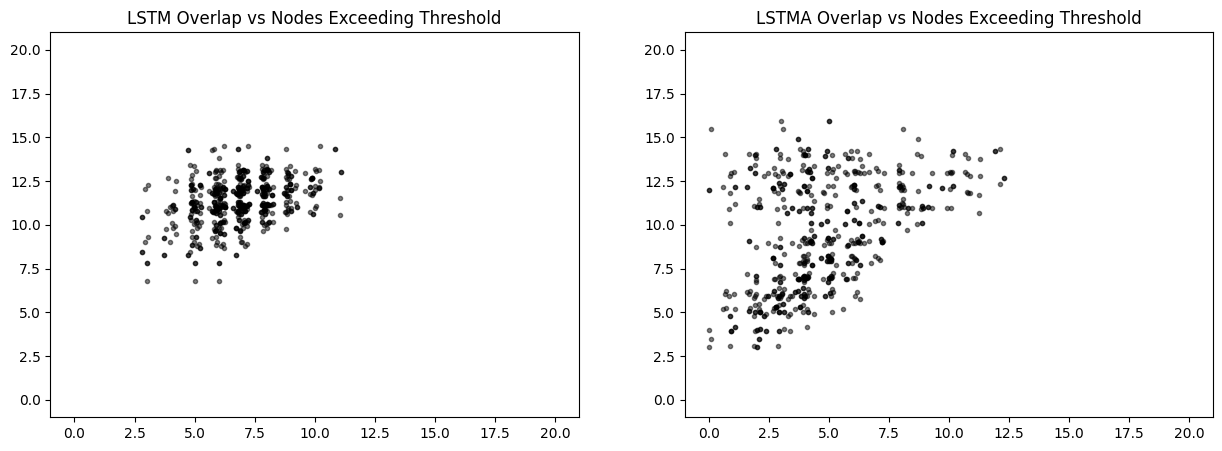

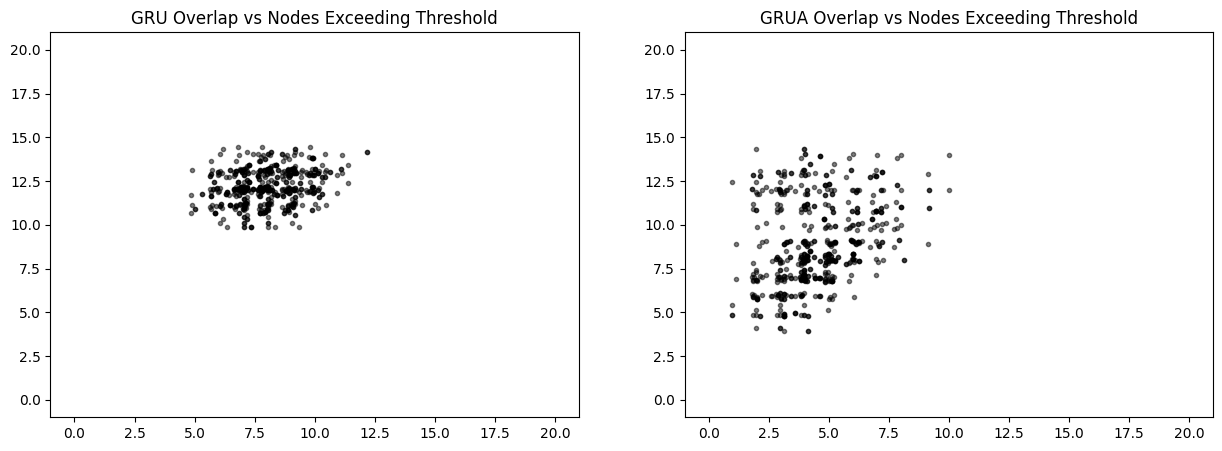

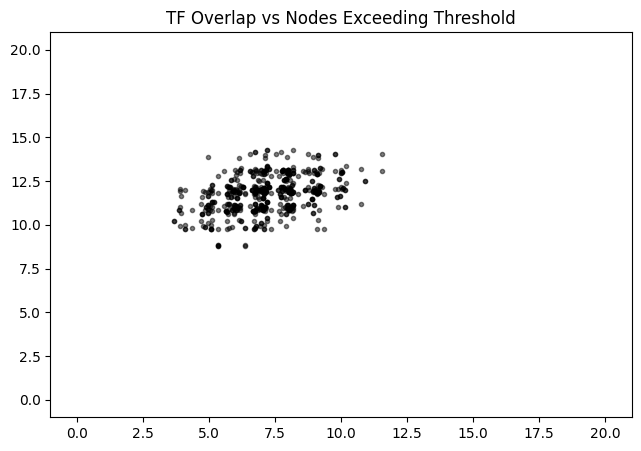

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming 'df', 'X', and 'Y' are already defined.
# Define the types of neural networks and their respective advanced versions
nn_types = [
    ('RNN', 'RNNA'),
    ('LSTM', 'LSTMA'),
    ('GRU', 'GRUA'),
    ('TF', None)  # TF does not have an advanced version in this list
]

pairs = [
    ('song_1_song_2_11_overlap', 'Song_1_Nodes_exceeding_treshold', 'Song_2_Nodes_exceeding_treshold'),
    ('song_1_song_3_11_overlap', 'Song_1_Nodes_exceeding_treshold', 'Song_3_Nodes_exceeding_treshold'),
    ('song_1_song_4_11_overlap', 'Song_1_Nodes_exceeding_treshold', 'Song_4_Nodes_exceeding_treshold'),
    ('song_2_song_3_11_overlap', 'Song_2_Nodes_exceeding_treshold', 'Song_3_Nodes_exceeding_treshold'),
    ('song_2_song_4_11_overlap', 'Song_2_Nodes_exceeding_treshold', 'Song_4_Nodes_exceeding_treshold'),
    ('song_3_song_4_11_overlap', 'Song_3_Nodes_exceeding_treshold', 'Song_4_Nodes_exceeding_treshold'),
]

# Dictionary to store matrices
matrices = {}

for nn_type, nn_advanced in nn_types:
    if nn_advanced:
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    else:
        fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
        axs = [ax]  # Wrap the single ax in a list for consistent handling below

    # Plot for regular type
    who = df['Kind'] == nn_type
    ax = axs[0]
    M = np.zeros((21, 21))
    for overlap, song1, song2 in pairs:
        M[df[overlap][who].astype(int), df[song1][who].astype(int)] += 1
        M[df[overlap][who].astype(int), df[song2][who].astype(int)] += 1
        ax.plot(df[overlap][who] + X[who], df[song1][who] + Y[who], '.k', alpha=0.5)
        ax.plot(df[overlap][who] + X[who], df[song2][who] + Y[who], '.k', alpha=0.5)
    ax.set_xlim(-1, 21)
    ax.set_ylim(-1, 21)
    ax.set_title(f'{nn_type} Overlap vs Nodes Exceeding Threshold')
    matrices[nn_type] = M  # Store the matrix

    # Plot for advanced type if applicable
    if nn_advanced:
        who = df['Kind'] == nn_advanced
        ax = axs[1]
        M_adv = np.zeros((21, 21))  # Initialize matrix for advanced type
        for overlap, song1, song2 in pairs:
            M_adv[df[overlap][who].astype(int), df[song1][who].astype(int)] += 1
            M_adv[df[overlap][who].astype(int), df[song2][who].astype(int)] += 1
            ax.plot(df[overlap][who] + X[who], df[song1][who] + Y[who], '.k', alpha=0.5)
            ax.plot(df[overlap][who] + X[who], df[song2][who] + Y[who], '.k', alpha=0.5)
        ax.set_xlim(-1, 21)
        ax.set_ylim(-1, 21)
        ax.set_title(f'{nn_advanced} Overlap vs Nodes Exceeding Threshold')
        matrices[nn_advanced] = M_adv  # Store the matrix for advanced type

    plt.show()

# Here, you can access 'matrices' to see or use the saved matrices


In [53]:
matrices.keys()

dict_keys(['RNN', 'RNNA', 'LSTM', 'LSTMA', 'GRU', 'GRUA', 'TF'])

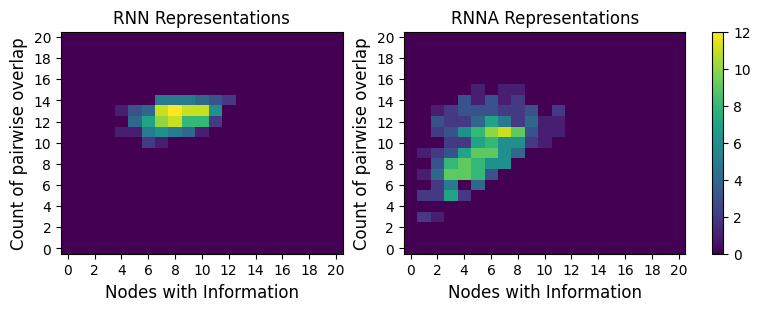

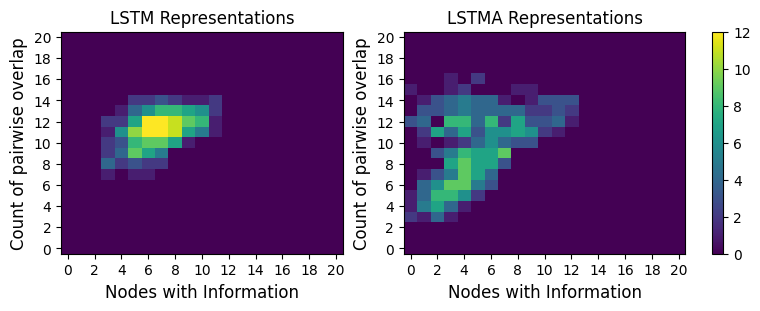

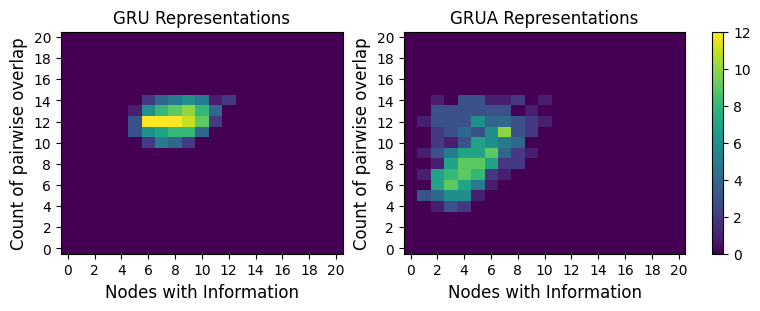

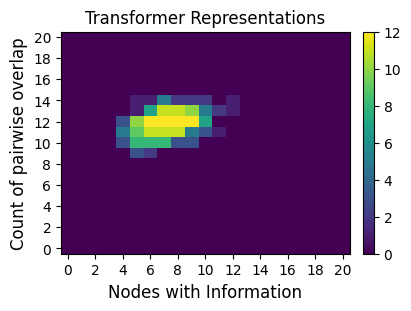

In [104]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'matrices' is a dictionary containing your heatmap data
nn_pairs = [
    ('RNN', 'RNNA'),
    ('LSTM', 'LSTMA'),
    ('GRU', 'GRUA')
]

# Find global minimum and maximum values across all matrices for consistent color scaling
min_val = float('inf')
max_val = float('-inf')

for matrix in matrices.values():
    min_val = min(min_val, np.min(matrix))
    max_val = max(max_val, np.max(matrix))

# Plot each pair of matrices side by side
for nn_type, nn_advanced in nn_pairs:
    if nn_type in matrices and nn_advanced in matrices:
        fig, axs = plt.subplots(1, 2, figsize=(7.5, 3), constrained_layout=True)

        # Regular type
        im = axs[0].imshow(matrices[nn_type].T, aspect='auto', vmin=min_val, vmax=max_val)
        axs[0].set_title(f'{nn_type} Representations', fontsize = 12)
        axs[0].set_xticks(np.arange(0, matrices[nn_type].shape[1], 2))
        axs[0].set_yticks(np.arange(0, matrices[nn_type].shape[0], 2))
        axs[0].set_xlabel("Nodes with Information", fontsize=12)
        axs[0].set_ylabel("Count of pairwise overlap", fontsize=12)
        axs[0].invert_yaxis()

        # Advanced type
        im_adv = axs[1].imshow(matrices[nn_advanced].T, aspect='auto', vmin=min_val, vmax=max_val)
        axs[1].set_title(f'{nn_advanced} Representations', fontsize =12)
        axs[1].set_xticks(np.arange(0, matrices[nn_advanced].shape[1], 2))
        axs[1].set_yticks(np.arange(0, matrices[nn_advanced].shape[0], 2))
        axs[1].set_xlabel("Nodes with Information", fontsize = 12)
        axs[1].set_ylabel("Count of pairwise overlap", fontsize = 12)
        axs[1].invert_yaxis()

        # Add a color bar to the right of the plots
        cbar = fig.colorbar(im_adv, ax=axs, orientation='vertical', fraction=0.046, pad=0.04)
        
        plt.savefig(f"./Final-Plots/Model_{nn_type}_{nn_advanced}_heatmap.pdf")
        plt.show()

# If there's a matrix for the Transformer, plot it alone
if 'TF' in matrices:
    plt.figure(figsize=(4, 3), constrained_layout=True)
    im_tf = plt.imshow(matrices['TF'].T, aspect='auto', vmin=min_val, vmax=max_val)
    plt.title('Transformer Representations', fontsize = 12)
    plt.xticks(np.arange(0, matrices['TF'].shape[1], 2))
    plt.yticks(np.arange(0, matrices['TF'].shape[0], 2))
    plt.xlabel("Nodes with Information", fontsize=12)
    plt.ylabel("Count of pairwise overlap", fontsize=12)
    ax = plt.gca()
    ax.invert_yaxis()

    # Add a color bar
    plt.colorbar(im_tf, orientation='vertical', fraction=0.046, pad=0.04)
    plt.savefig(f"./Final-Plots/Model_Transformer_heatmap.pdf")
    plt.show()


# Adding Noise


In [100]:
def shuffle_notes(song_string, percentage):
    song_list = list(song_string)
    num_to_shuffle = int(len(song_list) * (percentage / 100))
    indices_to_shuffle = random.sample(range(len(song_list)), num_to_shuffle)

    shuffled_indices = indices_to_shuffle.copy()
    random.shuffle(shuffled_indices)

    for original, shuffled in zip(indices_to_shuffle, shuffled_indices):
        song_list[original] = song_string[shuffled]

    return ''.join(song_list)



In [101]:
def shuffle_notes_Transformer(song_string, percentage):
    song_list = list(song_string)
    num_notes_to_shuffle = int(len(song_list) * percentage / 100)
    indices_to_shuffle = np.random.choice(range(len(song_list)), size=num_notes_to_shuffle, replace=False)

    np.random.shuffle(indices_to_shuffle)

    shuffled_song = np.array(song_list)
    shuffled_song[indices_to_shuffle] = shuffled_song[indices_to_shuffle][np.random.permutation(num_notes_to_shuffle)]

    return ''.join(shuffled_song.tolist())


In [102]:
def evaluate_model_with_noise(model, songStrings, number_of_Songs, noise_levels, model_name):
    results = {"noise_level": [], "accuracy": []}

    for noise_level in noise_levels:
        noisy_songStrings = np.array([shuffle_notes(song, noise_level) for song in songStrings])
        I, _, O_indices, _ = generateIOData(number_of_Songs, noisy_songStrings)
        
        inputs = torch.tensor(I, dtype=torch.float)
        targets = torch.tensor(O_indices, dtype=torch.long).view(-1)
        if model_name == 'TF':
            noisy_songStrings = np.array([shuffle_notes_Transformer(song, noise_level) for song in songStrings])
            # Generate data with noisy song strings
            source, target, _ = getTrainingData(noisy_songStrings, number_of_Songs)
            inputs = torch.tensor(source, dtype=torch.long)
            targets = torch.tensor(target, dtype=torch.long)

        model.eval()
        if model_name == 'TF':
            accuracy = test(model, source, target)
            results["noise_level"].append(noise_level)
            results["accuracy"].append(accuracy)
            print(f"Noise Level: {noise_level}%, Accuracy: {accuracy:.4f}")
        else:
            with torch.no_grad():
                outputs = model(inputs)
                output_flat = outputs.view(-1, outputs.shape[-1])
                _, predicted_indices = torch.max(output_flat, 1)
                correct_predictions = (predicted_indices == targets).sum().item()
                total_accuracy = correct_predictions / targets.numel()
                
                print(f"Noise Level: {noise_level}%, Accuracy: {total_accuracy:.4f}")
                
                results["noise_level"].append(noise_level)
                results["accuracy"].append(total_accuracy)

    return results


Evaluating models of type: RNN
Noise Level: 0%, Accuracy: 0.9501
Noise Level: 1%, Accuracy: 0.9501
Noise Level: 2%, Accuracy: 0.9501
Noise Level: 3%, Accuracy: 0.9501
Noise Level: 4%, Accuracy: 0.9501
Noise Level: 5%, Accuracy: 0.8648
Noise Level: 6%, Accuracy: 0.9501
Noise Level: 7%, Accuracy: 0.9029
Noise Level: 8%, Accuracy: 0.7548
Noise Level: 9%, Accuracy: 0.9157
Noise Level: 10%, Accuracy: 0.6947
Noise Level: 11%, Accuracy: 0.6738
Noise Level: 12%, Accuracy: 0.7112
Noise Level: 13%, Accuracy: 0.6369
Noise Level: 14%, Accuracy: 0.6346
Noise Level: 15%, Accuracy: 0.6447
Noise Level: 16%, Accuracy: 0.6299
Noise Level: 17%, Accuracy: 0.6048
Noise Level: 18%, Accuracy: 0.5774
Noise Level: 19%, Accuracy: 0.6086
Noise Level: 20%, Accuracy: 0.5842
Noise Level: 0%, Accuracy: 0.9501
Noise Level: 1%, Accuracy: 0.9501
Noise Level: 2%, Accuracy: 0.9501
Noise Level: 3%, Accuracy: 0.9501
Noise Level: 4%, Accuracy: 0.9501
Noise Level: 5%, Accuracy: 0.9501
Noise Level: 6%, Accuracy: 0.8464
Noise 

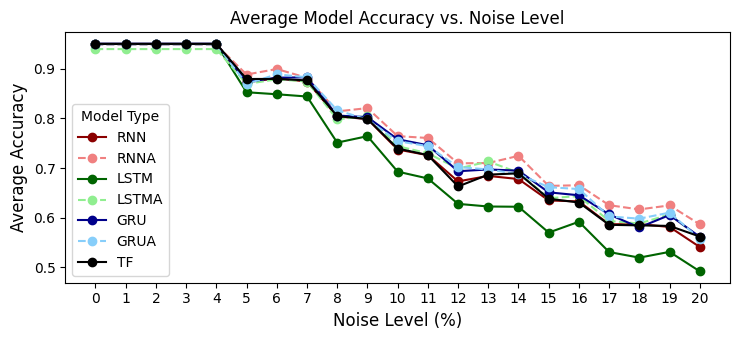

In [108]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Model kinds and settings
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA", "TF"]
num_reps = 50
noise_levels = list(range(21))  # 0% to 20% noise

# Initialize a dictionary to store the cumulative accuracies for averaging
cumulative_results = {kind: np.zeros(len(noise_levels)) for kind in kinds}
# Initialize a dictionary to store results of each repetition for each model kind
results = {kind: [] for kind in kinds}

# Iterate over each model kind and repetition
for kind in kinds:
    print(f"Evaluating models of type: {kind}")
    for rep in range(num_reps):
        model_path = f'./dataModelsSongs/{kind}_{rep}.model'
        model = torch.load(model_path)
        model.eval()  # Ensure the model is in evaluation mode
        temp_results = evaluate_model_with_noise(model, songStrings, 4, noise_levels, kind)
        
        # Accumulate accuracies for later averaging
        cumulative_results[kind] += np.array(temp_results['accuracy'])
        
        # Store results of each repetition
        results[kind].append({
            'rep': rep,
            'noise_level': temp_results['noise_level'],
            'accuracy': temp_results['accuracy']
        })
        
    # Calculate the average by dividing by the number of repetitions
    cumulative_results[kind] /= num_reps

plot_styles = {
    "RNN": {"color": "darkred", "linestyle": "-"},
    "RNNA": {"color": "lightcoral", "linestyle": "--"},
    "LSTM": {"color": "darkgreen", "linestyle": "-"},
    "LSTMA": {"color": "lightgreen", "linestyle": "--"},
    "GRU": {"color": "darkblue", "linestyle": "-"},
    "GRUA": {"color": "lightskyblue", "linestyle": "--"},
    "TF": {"color": "black", "linestyle": "-"}
}

# Plotting the results with specified colors and line styles
plt.figure(figsize=(7.5, 3.5))
for kind, accuracies in cumulative_results.items():
    plt.plot(noise_levels, accuracies, marker='o', label=kind, **plot_styles[kind])

plt.title('Average Model Accuracy vs. Noise Level', fontsize = 12)
plt.xlabel('Noise Level (%)', fontsize = 12)
plt.ylabel('Average Accuracy', fontsize = 12)
plt.legend(title='Model Type')
plt.xticks(noise_levels)
plt.grid(False)
plt.tight_layout()
plt.savefig("./Final-Plots/Noise.pdf")
plt.show()



In [140]:
source,target,songs = getTrainingData(songStrings,4)
model_path = f'./dataModelsSongs/TF_22.model'
model = torch.load(model_path)
model.eval()  
x = test(model, source, target)
x

0.7661149825783972

In [141]:
I, _, O_indices, _ = generateIOData(4, songStrings)
model_path = f'./dataModelsSongs/RNN_22.model'
model = torch.load(model_path)
model.eval()  
inputs = torch.tensor(I, dtype=torch.float)
targets = torch.tensor(O_indices, dtype=torch.long).view(-1)
outputs = model(inputs)
output_flat = outputs.view(-1, outputs.shape[-1])
_, predicted_indices = torch.max(output_flat, 1)
correct_predictions = (predicted_indices == targets).sum().item()
total_accuracy = correct_predictions / targets.numel()
total_accuracy

0.7767131242740999

# Catastrophic Forgetting


In [3]:
def read_csv(model_name, iteration):
    # Construct the file path based on the model name and iteration
    file_name = f"acc_{model_name}_{iteration}.csv"
    if model_name =='TF':
        file_name = f"acc_CF_{model_name}_{iteration}.csv"

    file_path = os.path.join('dataCF', file_name)
    
    # Check if the file exists
    if os.path.exists(file_path):
        # Load and return the data if the file exists
        return pd.read_csv(file_path)
    else:
        # Return None or an empty DataFrame if the file does not exist
        return pd.DataFrame()
def myEval(S):
    S=S[1:-1]
    W=[]
    for s in S.split(","):
        W.append(float(s))
    return W


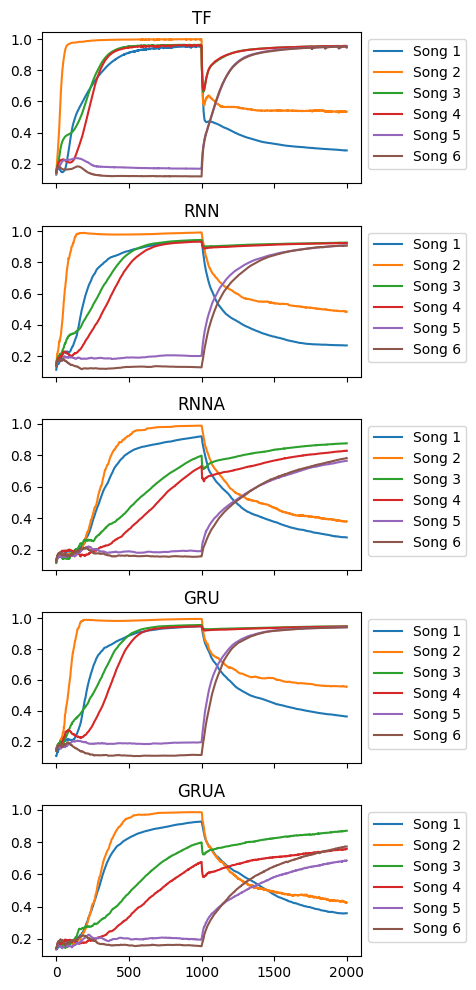

In [68]:

modelNames=["TF","RNN","RNNA","GRU","GRUA"]

# We'll use the plt.subplots function to create a figure and a set of subplots
fig, axs = plt.subplots(len(modelNames), 1, figsize=[5, 10], sharex=True)

for m, mn in enumerate(modelNames):
    # Initialize matrices to hold the data for the current model
    M = [[] for _ in range(6)]  # Six lists for six songs
    
    # Process files for each model, assuming a range of 50 iterations (demonstrated for GRU)
    for n in range(50):  # We would loop over available files/iterations
        data = read_csv(mn, n)
        if not data.empty:
            Ws = [[] for _ in range(6)]  # Temporary storage for the current file's data

            # Iterate over the 'acc' column, parsing each row's data
            for i in range(len(data)):
                W = myEval(data["acc"][i])
                for j in range(6):
                    Ws[j].append(W[j])

            # Convert lists to numpy arrays for easier manipulation
            Ws = np.array(Ws)

            # Aggregate the data
            for j in range(6):
                M[j].append(Ws[j])  # Append the data for each song

    # Convert M to a numpy array for further processing (like mean calculation)
    M = np.array(M)

    # Plotting the mean accuracy for each song in the current model
    for j in range(6):
        if M.shape[1] > 0:
            mean_accuracy = np.mean(M[j], axis=0)
            axs[m].plot(mean_accuracy, label=f"Song {j+1}")

    axs[m].set_title(mn)
    # Move the legend outside the plot area on the right side
    axs[m].legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout to make room for the legend
plt.tight_layout()
plt.subplots_adjust(right=0.75)  # Adjust this value based on your figure's needs
plt.show()

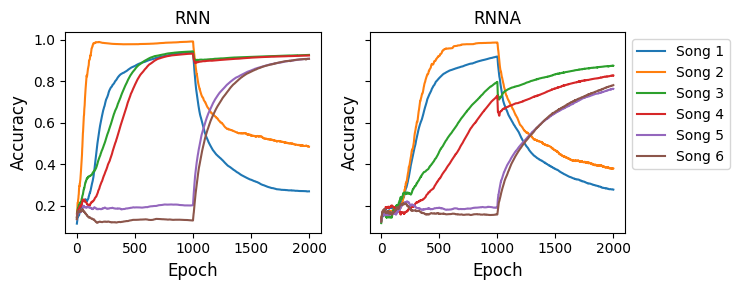

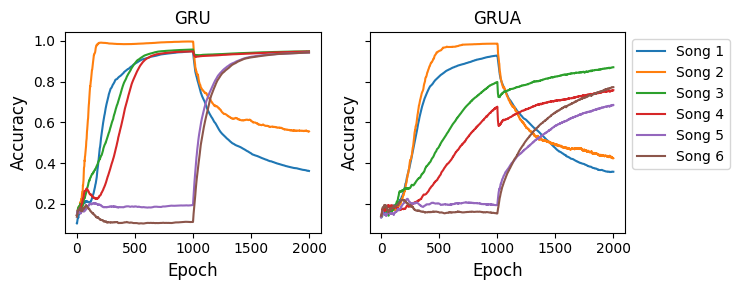

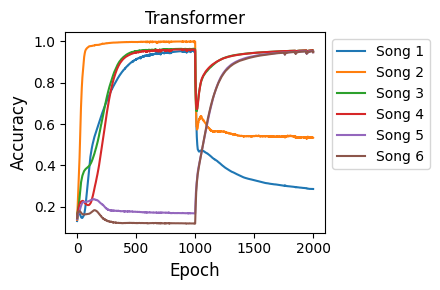

In [118]:

modelNames = ["TF", "RNN", "RNNA", "GRU", "GRUA"]
x_ticks = np.arange(0, 2100, 500) 
# Process and plot for RNN and RNNA
fig1, axs1 = plt.subplots(1, 2, figsize=[7.5, 3], sharex=True, sharey=True)
for m, mn in enumerate(["RNN", "RNNA"]):
    ax = axs1[m]
    M = [[] for _ in range(6)]
    for n in range(50):
        data = read_csv(mn, n)
        if not data.empty:
            Ws = [myEval(row['acc']) for index, row in data.iterrows()]
            for j in range(6):
                M[j].append([W[j] for W in Ws])
    for j in range(6):
        if any(M[j]):
            mean_accuracy = np.mean(M[j], axis=0)
            ax.plot(mean_accuracy, label=f"Song {j+1}")
    ax.set_title(mn,fontsize =12)
    ax.set_xticks(x_ticks)
    ax.set_xlabel("Epoch", fontsize =12)
    ax.set_ylabel("Accuracy",fontsize =12)
    if mn == 'RNNA':
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.savefig("./Final-Plots/Rnn_RNNA_CF_Accuracy.pdf")
plt.show()

# Process and plot for GRU and GRUA
fig2, axs2 = plt.subplots(1, 2, figsize=[7.5, 3], sharex=True, sharey=True)
for m, mn in enumerate(["GRU", "GRUA"]):
    ax = axs2[m]
    M = [[] for _ in range(6)]
    for n in range(50):
        data = read_csv(mn, n)
        if not data.empty:
            Ws = [myEval(row['acc']) for index, row in data.iterrows()]
            for j in range(6):
                M[j].append([W[j] for W in Ws])
    for j in range(6):
        if any(M[j]):
            mean_accuracy = np.mean(M[j], axis=0)
            ax.plot(mean_accuracy, label=f"Song {j+1}")
    ax.set_title(mn,fontsize =12)
    ax.set_xticks(x_ticks)
    ax.set_xlabel("Epoch",fontsize =12)
    ax.set_ylabel("Accuracy",fontsize =12)
    if mn == 'GRUA':
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.savefig("./Final-Plots/GRU_GRUA_CF_Accuracy.pdf")
plt.show()

# Process and plot for TF
fig3, ax = plt.subplots(figsize=[4.5, 3])
M = [[] for _ in range(6)]
for n in range(50):
    data = read_csv("TF", n)
    if not data.empty:
        Ws = [myEval(row['acc']) for index, row in data.iterrows()]
        for j in range(6):
            M[j].append([W[j] for W in Ws])
for j in range(6):
    if any(M[j]):
        mean_accuracy = np.mean(M[j], axis=0)
        ax.plot(mean_accuracy, label=f"Song {j+1}")
ax.set_title("Transformer",fontsize =12)
ax.set_xticks(x_ticks)
ax.set_xlabel("Epoch",fontsize =12)
ax.set_ylabel("Accuracy",fontsize =12)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.savefig("./Final-Plots/Transformer_CF_Accuracy.pdf")
plt.show()

In [ ]:
# Assuming the TransformerModel class and other model classes have been defined correctly
ntokens = 8  # Assuming 8 unique tokens (notes)
emsize = 20  # Embedding dimension
nhead = 4  # Number of heads in the nn.MultiheadAttention
d_hid = 20  # Dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # Number of nn.TransformerEncoderLayer
dropout = 0.00  # Dropout probability

models = {
    "RNN": RNN(),
    "RNNA": RNNA(),  
    "GRU": GRU(),
    "GRUA": GRUA(),
    "TF": TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)
}

nrOfSongs = 4
source, O_hot, target, songs = generateIOData(nrOfSongs, songStrings)
model_matrices = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_reps = 50
epochs = [1000, 2000]
kinds = models.keys()  # Assuming you meant to iterate over the keys of the models dictionary

for epoch in epochs:
    if epoch == 1000:
        source, O_hot, target, songs = generateIOData(nrOfSongs, songStrings)
    else:
        source, O_hot, target, songs = generateIOData(nrOfSongs, songStrings[2:])

    for kind in kinds:
        if kind == "TF":
            if epoch == 1000:
                source, target, songs = getTrainingData(songStrings, nrOfSongs)
            else:
                source, target, songs = getTrainingData(songStrings[2:], nrOfSongs)
        for rep in range(num_reps):
            model_identifier = f'{kind}-{epoch}-{rep}'

            # Adjusted code to handle state dictionary loading
            
            # Ensure the model is re-instantiated for each kind and correctly configured for TF
            #if kind == "TF":
            #    model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)
            if kind == "RNN":
                model = RNN()
            elif kind == "RNNA":
                model = RNNA()
            elif kind == "GRU":
                model = GRU()
            elif kind == "GRUA":
                model = GRUA()

   
            if kind == 'TF':
                model = torch.load(f'./dataCF/{kind}_{epoch}_{rep}.model')
                model.to(device)  # Move the model to the appropriate device
            else:
                state_dict = torch.load(f'./dataCF/{kind}_{epoch}_{rep}.model')
                model.load_state_dict(state_dict)    
                model.to(device)  # Move the model to the appropriate device

            model.eval()  # Set the model to evaluation mode
            s, h = shrinkingDecompositionInformation(model, source, target, songs, numbers=list(range(4)), width=20, model_name=kind)
            M = removalIntoMatrix(s, 20, h)
            model_matrices[model_identifier] = M

In [241]:

with open('model_songs_matrices_CF.pkl', 'wb') as file:
    pickle.dump(model_matrices, file)

In [48]:
with open('model_songs_matrices_CF.pkl', 'rb') as file:
    model_matrices = pickle.load(file)

In [49]:
# List to hold data for DataFrame
df_m = []

# Loop through the model_matrices dictionary
for model_identifier, M in model_matrices.items():
    # Create a dictionary for each model with its identifier and matrix
    model_data = {
        'Model Identifier': model_identifier,
        'Matrix': M
    }
    df_m.append(model_data)

# Create DataFrame from the list of dictionaries
models_M = pd.DataFrame(df_m)

# Display the DataFrame
print(models_M)

    Model Identifier                                             Matrix
0         RNN-1000-0  [[0.3260159285099222, 0.7675683658157793, 0.16...
1         RNN-1000-1  [[0.7373182140483845, 0.16236003082120565, 0.7...
2         RNN-1000-2  [[0.006340537900775267, 0.8112436705602688, 0....
3         RNN-1000-3  [[0.7671822764019014, 0.6983263448871968, 0.0,...
4         RNN-1000-4  [[0.7279616360696375, 0.8111412101829529, 0.45...
..               ...                                                ...
495       TF-2000-45  [[0.6043693401902477, 0.3694832933506076, 0.72...
496       TF-2000-46  [[0.73981542515798, 0.21938616754926166, 0.727...
497       TF-2000-47  [[0.5841067135282971, 0.7636590768400842, 0.21...
498       TF-2000-48  [[0.7397131222101754, 0.7635226460196982, 0.43...
499       TF-2000-49  [[0.7681524548291527, 0.14205203592684956, 0.4...

[500 rows x 2 columns]


In [50]:
results = []


for index, row in models_M.iterrows():
    model_identifier = row['Model Identifier']
    M = row['Matrix']
    kind,epoch ,rep = model_identifier.split('-')                
    # Calculate metrics
    sum_abs = np.sum(np.abs(M))
    mean = np.mean(M)
    std = np.std(M)
    max_val = np.max(M)
    min_val = np.min(M)

    threshold_song_1, count_exceeding_song_1 = kmeans_thresholding(M[0]) # fix this K means of A alone then B alone
    threshold_song_2, count_exceeding_song_2 = kmeans_thresholding(M[1]) # fix this K means of A alone then B alone
    threshold_song_3, count_exceeding_song_3 = kmeans_thresholding(M[2]) # fix this K means of A alone then B alone
    threshold_song_4, count_exceeding_song_4 = kmeans_thresholding(M[3]) # fix this K means of A alone then B alone

    binarized_matrix_song_1 = np.where(M[0].flatten() >= threshold_song_1, 1, 0).reshape(M[0].shape) 
    binarized_matrix_song_2 = np.where(M[1].flatten() >= threshold_song_2, 1, 0).reshape(M[1].shape)
    binarized_matrix_song_3 = np.where(M[2].flatten() >= threshold_song_3, 1, 0).reshape(M[2].shape)
    binarized_matrix_song_4 = np.where(M[3].flatten() >= threshold_song_4, 1, 0).reshape(M[3].shape)

    # Vertically stack binarized_matrix_A and binarized_matrix_B
    binarized_combined_matrix = np.vstack([binarized_matrix_song_1, binarized_matrix_song_2, binarized_matrix_song_3, binarized_matrix_song_4])

    degree_2, degree_3, degree_4  = calculate_degrees_of_overlap(binarized_combined_matrix)

    min_values = np.min(binarized_combined_matrix, axis=0)

    # Clip these values between 0 and 1
    clipped_min_values = np.clip(min_values, 0, 1)

    # Sum the clipped values
    sum_clipped_min_values = np.sum(clipped_min_values) # fixed this

    # Counting the number of 1's in each column
    ones_count = np.sum(binarized_combined_matrix, axis=0)
    # Calculating the overlap percentage for each column
    # Initialize the overlap percentage array
    overlap_percentage_per_column = np.zeros(ones_count.shape)
    # Setting the overlap percentage based on the number of 1's in each column
    overlap_percentage_per_column[ones_count == 2] = .5
    overlap_percentage_per_column[ones_count == 3] = .75
    overlap_percentage_per_column[ones_count == 4] = 1
    # Calculating the overall overlap percentage across all columns
    overall_overlap_percentage = (np.sum(overlap_percentage_per_column) / (ones_count.shape[0])) * 100

  
    
    metrics = {
        "Kind": kind,
        "epoch":int(epoch),
        "Repetition": int(rep),
        "Sum of Absolute Values": round(sum_abs,4),
        "Mean Value": round(mean,4),
        "Standard Deviation": round(std, 4),
        "Maximum Value": round(max_val,4),
        "Minimum Value": round(min_val,4),
        "Kmeans_song_1_treshold": round(threshold_song_1,4),
        "Kmeans_song_2_treshold": round(threshold_song_2,4),
        "Kmeans_song_3_treshold": round(threshold_song_3,4),
        "Kmeans_song_4_treshold": round(threshold_song_4,4),
        "Song_1_Nodes_exceeding_treshold": count_exceeding_song_1,
        "Song_2_Nodes_exceeding_treshold": count_exceeding_song_2,
        "Song_3_Nodes_exceeding_treshold": count_exceeding_song_3,
        "Song_4_Nodes_exceeding_treshold": count_exceeding_song_4,
        "Total_Nodes_exceeding_treshold": count_exceeding_song_1 + count_exceeding_song_2 + count_exceeding_song_3 + count_exceeding_song_4,
        "degree_2_overlapp": degree_2,
        "degree_3_overlapp": degree_3,
        "degree_4_overlapp": degree_4,
        "sum_of_degree_overlapp": degree_2 + degree_3 + degree_4,
        "Total_Overlapp_percentage" : overall_overlap_percentage,
        "overlapp_column1":overlap_percentage_per_column[0],
        "overlapp_column2":overlap_percentage_per_column[1],
        "overlapp_column3":overlap_percentage_per_column[2],
        "overlapp_column4":overlap_percentage_per_column[3],
        "overlapp_column5":overlap_percentage_per_column[4],
        "overlapp_column6":overlap_percentage_per_column[5],
        "overlapp_column7":overlap_percentage_per_column[6],
        "overlapp_column8":overlap_percentage_per_column[7],
        "overlapp_column9":overlap_percentage_per_column[8],
        "overlapp_column10":overlap_percentage_per_column[9],
        "overlapp_column11":overlap_percentage_per_column[10],
        "overlapp_column12":overlap_percentage_per_column[11],
        "overlapp_column13":overlap_percentage_per_column[12],
        "overlapp_column14":overlap_percentage_per_column[13],
        "overlapp_column15":overlap_percentage_per_column[14],
        "overlapp_column16":overlap_percentage_per_column[15],
        "overlapp_column17":overlap_percentage_per_column[16],
        "overlapp_column18":overlap_percentage_per_column[17],
        "overlapp_column19":overlap_percentage_per_column[18],
        "overlapp_column20":overlap_percentage_per_column[19],
    
    }
    num_songs = 4
    # Assuming all songs have the same number of features/columns for simplicity
    num_columns = binarized_matrix_song_1.shape[0]  # Number of columns/features per song

    # Dictionary to store pairwise "11" overlaps for each song pair across all columns
    pair_11_overlaps = {}
    count = 0
    # Iterate through all song combinations
    for (i, j) in itertools.combinations(range(num_songs), 2):
        # Initialize a count for each song pair
        pair_11_overlaps[f'song_{i+1}_song_{j+1}_11_overlap'] = 0

        # For each column, check if both songs have a "1" in the same position
        for col in range(num_columns):
            if binarized_combined_matrix[i, col] == 1 and binarized_combined_matrix[j, col] == 1:
                # If both songs have "1" in the same column, increment the count
                pair_11_overlaps[f'song_{i+1}_song_{j+1}_11_overlap'] += 1
    # Update the metrics dictionary to include the "11" overlaps
    metrics.update(pair_11_overlaps)
    vector_song_1 = binarized_matrix_song_1.flatten()
    vector_song_2 = binarized_matrix_song_2.flatten()
    vector_song_3 = binarized_matrix_song_3.flatten()
    vector_song_4 = binarized_matrix_song_4.flatten()
    count = 0
    for i in pair_11_overlaps.values():
        count+=i
    metrics['total_pairwise_overlap_count'] = count
    metrics["Binarized_Vector_Song_1"] = vector_song_1.tolist()
    metrics["Binarized_Vector_Song_2"] = vector_song_2.tolist()
    metrics["Binarized_Vector_Song_3"] = vector_song_3.tolist()
    metrics["Binarized_Vector_Song_4"] = vector_song_4.tolist()

    count_00 = 0
    for i in range(len(vector_song_3)):
        if vector_song_3[i] == 0 and vector_song_4[i] == 0:
            count_00 += 1
    metrics["count_00_for_songs_34"] = count_00
    results.append(metrics)
    
    
df = pd.DataFrame(results)


In [52]:
df

Kind  epoch  Repetition  Sum of Absolute Values  Mean Value  \
0    RNN   1000           0                 36.3929      0.4549   
1    RNN   1000           1                 38.6083      0.4826   
2    RNN   1000           2                 39.3151      0.4914   
3    RNN   1000           3                 38.0316      0.4754   
4    RNN   1000           4                 39.0421      0.4880   
..   ...    ...         ...                     ...         ...   
495   TF   2000          45                 34.0200      0.4252   
496   TF   2000          46                 33.7050      0.4213   
497   TF   2000          47                 33.8629      0.4233   
498   TF   2000          48                 32.4411      0.4055   
499   TF   2000          49                 33.1770      0.4147   

     Standard Deviation  Maximum Value  Minimum Value  Kmeans_song_1_treshold  \
0                0.2905         0.8113            0.0                  0.3863   
1                0.2992         0.8111            0.0                  0.4344   
2                0.3010         0.8113            0.0                  0.4069   
3                0.2945         0.8113            0.0                  0.3871   
4                0.3016         0.8112            0.0                  0.4166   
..                  ...            ...            ...                     ...   
495              0.2923         0.8113            0.0                  0.3943   
496              0.2888         0.7994            0.0                  0.3651   
497              0.2925         0.7994            0.0                  0.3953   
498              0.2853         0.7992            0.0                  0.3938   
499              0.2853         0.7801            0.0                  0.3703   

     Kmeans_song_2_treshold  ...  song_1_song_4_11_overlap  \
0                    0.4065  ...                         7   
1                    0.4124  ...                         9   
2                    0.4319  ...                        10   
3                    0.4237  ...                         7   
4                    0.3805  ...                         9   
..                      ...  ...                       ...   
495                  0.3828  ...                         7   
496                  0.4004  ...                         9   
497                  0.3561  ...                         7   
498                  0.3590  ...                         6   
499                  0.3717  ...                         7   

     song_2_song_3_11_overlap  song_2_song_4_11_overlap  \
0                           7                         5   
1                           7                         8   
2                           8                         5   
3                           8                         8   
4                           8                         7   
..                        ...                       ...   
495                         7                         4   
496                         8                        10   
497                        10                         7   
498                         6                         6   
499                         7                         6   

     song_3_song_4_11_overlap  total_pairwise_overlap_count  \
0                           7                            41   
1                           8                            47   
2                           6                            47   
3                           8                            47   
4                           9                            51   
..                        ...                           ...   
495                         6                            36   
496                         9                            54   
497                         8                            45   
498                         8                            40   
499                         8                            39   

               

In [53]:
df.to_csv("songs_cf.csv", index=False)

In [4]:
df = pd.read_csv("songs_cf.csv")

In [5]:
df

Kind  epoch  Repetition  Sum of Absolute Values  Mean Value  \
0    RNN   1000           0                 36.3929      0.4549   
1    RNN   1000           1                 38.6083      0.4826   
2    RNN   1000           2                 39.3151      0.4914   
3    RNN   1000           3                 38.0316      0.4754   
4    RNN   1000           4                 39.0421      0.4880   
..   ...    ...         ...                     ...         ...   
495   TF   2000          45                 34.0200      0.4252   
496   TF   2000          46                 33.7050      0.4213   
497   TF   2000          47                 33.8629      0.4233   
498   TF   2000          48                 32.4411      0.4055   
499   TF   2000          49                 33.1770      0.4147   

     Standard Deviation  Maximum Value  Minimum Value  Kmeans_song_1_treshold  \
0                0.2905         0.8113            0.0                  0.3863   
1                0.2992         0.8111            0.0                  0.4344   
2                0.3010         0.8113            0.0                  0.4069   
3                0.2945         0.8113            0.0                  0.3871   
4                0.3016         0.8112            0.0                  0.4166   
..                  ...            ...            ...                     ...   
495              0.2923         0.8113            0.0                  0.3943   
496              0.2888         0.7994            0.0                  0.3651   
497              0.2925         0.7994            0.0                  0.3953   
498              0.2853         0.7992            0.0                  0.3938   
499              0.2853         0.7801            0.0                  0.3703   

     Kmeans_song_2_treshold  ...  song_1_song_4_11_overlap  \
0                    0.4065  ...                         7   
1                    0.4124  ...                         9   
2                    0.4319  ...                        10   
3                    0.4237  ...                         7   
4                    0.3805  ...                         9   
..                      ...  ...                       ...   
495                  0.3828  ...                         7   
496                  0.4004  ...                         9   
497                  0.3561  ...                         7   
498                  0.3590  ...                         6   
499                  0.3717  ...                         7   

     song_2_song_3_11_overlap  song_2_song_4_11_overlap  \
0                           7                         5   
1                           7                         8   
2                           8                         5   
3                           8                         8   
4                           8                         7   
..                        ...                       ...   
495                         7                         4   
496                         8                        10   
497                        10                         7   
498                         6                         6   
499                         7                         6   

     song_3_song_4_11_overlap  total_pairwise_overlap_count  \
0                           7                            41   
1                           8                            47   
2                           6                            47   
3                           8                            47   
4                           9                            51   
..                        ...                           ...   
495                         6                            36   
496                         9                            54   
497                         8                            45   
498                         8                            40   
499                         8                            39   

               

In [54]:
df[(df['Kind'] == 'RNN') & (df['epoch'] == 1000)]

Kind  epoch  Repetition  Sum of Absolute Values  Mean Value  \
0   RNN   1000           0                 36.3929      0.4549   
1   RNN   1000           1                 38.6083      0.4826   
2   RNN   1000           2                 39.3151      0.4914   
3   RNN   1000           3                 38.0316      0.4754   
4   RNN   1000           4                 39.0421      0.4880   
5   RNN   1000           5                 38.3146      0.4789   
6   RNN   1000           6                 39.0348      0.4879   
7   RNN   1000           7                 38.4270      0.4803   
8   RNN   1000           8                 39.4363      0.4930   
9   RNN   1000           9                 37.6846      0.4711   
10  RNN   1000          10                 38.4253      0.4803   
11  RNN   1000          11                 37.7742      0.4721   
12  RNN   1000          12                 39.5586      0.4945   
13  RNN   1000          13                 37.9589      0.4745   
14  RNN   1000          14                 38.2689      0.4784   
15  RNN   1000          15                 39.5406      0.4943   
16  RNN   1000          16                 40.0389      0.5005   
17  RNN   1000          17                 39.4076      0.4926   
18  RNN   1000          18                 38.3548      0.4794   
19  RNN   1000          19                 40.5600      0.5070   
20  RNN   1000          20                 38.5300      0.4816   
21  RNN   1000          21                 37.0564      0.4630   
22  RNN   1000          22                 39.6029      0.4950   
23  RNN   1000          23                 36.2521      0.4530   
24  RNN   1000          24                 39.3087      0.4914   
25  RNN   1000          25                 38.2974      0.4787   
26  RNN   1000          26                 39.8732      0.4984   
27  RNN   1000          27                 36.9290      0.4616   
28  RNN   1000          28                 35.4668      0.4432   
29  RNN   1000          29                 38.1894      0.4773   
30  RNN   1000          30                 38.0775      0.4760   
31  RNN   1000          31                 38.3113      0.4789   
32  RNN   1000          32                 38.4601      0.4808   
33  RNN   1000          33                 37.2108      0.4651   
34  RNN   1000          34                 37.4493      0.4681   
35  RNN   1000          35                 39.4916      0.4936   
36  RNN   1000          36                 37.5027      0.4688   
37  RNN   1000          37                 38.6444      0.4831   
38  RNN   1000          38                 37.7699      0.4721   
39  RNN   1000          39                 38.8325      0.4854   
40  RNN   1000          40                 38.4840      0.4810   
41  RNN   1000          41                 38.9318      0.4865   
42  RNN   1000          42                 39.2714      0.4909   
43  RNN   1000          43                 39.1969      0.4899   
44  RNN   1000          44                 38.9356      0.4867   
45  RNN   1000          45                 39.4396      0.4930   
46  RNN   1000          46                 38.7655      0.4846   
47  RNN   1000          47                 38.8143      0.4852   
48  RNN   1000          48                 37.2624      0.4658   
49  RNN   1000          49                 37.8601      0.4733   

    Standard Deviation  Maximum Value  Minimum Value  Kmeans_song_1_treshold  \
0               0.2905         0.8113         0.0000                  0.3863   
1               0.2992         0.8111         0.0000                  0.4344   
2               0.3010         0.8113         0.0000                  0.4069   
3               0.2945         0.8113         0.0000                  0.3871   
4               0.3016         0.8112         0.0000                  0.4166   
5               0.2984         0.8113         0.0000                  0.4446   
6               0.3005         0.8113         0.0000                  0.4241

In [233]:
import pandas as pd


# Define the function to calculate the percentage of change
def calculate_percentage_of_change(vec1, vec2):
    assert len(vec1) == len(vec2), "Vectors must be of the same length."

    # Calculate the Hamming distance as before
    hamming_distance = sum(e1 != e2 for e1, e2 in zip(vec1, vec2))
    
    # Count columns where both entries are 1
    columns_with_ones = 0
    for i in range(len(vec1)):
        if vec1[i] == '1' or vec2[i] == '1':
            columns_with_ones += 1
    
    # Ensure there is at least one column with both ones to avoid division by zero
    if columns_with_ones == 0:
        return 0  # Return 0% change if no columns have both ones to avoid division by zero
    
    # Calculate the percentage of change based on the columns with ones in both vectors
    percentage_of_change = (hamming_distance / columns_with_ones) * 100
    
    return percentage_of_change


# Placeholder for storing the results
change_results = []

# Iterate over each model kind
for kind in df['Kind'].unique():
    # Iterate over each epoch
    for epoch in df['epoch'].unique():
        # Iterate over each repetition
        for rep in range(50):  # Assuming repetitions are labeled from 0 to 49
            data_epoch_1000 = df[(df['Kind'] == kind) & (df['epoch'] == 1000) & (df['Repetition'] == rep)]
            data_epoch_2000 = df[(df['Kind'] == kind) & (df['epoch'] == 2000) & (df['Repetition'] == rep)]
            
            if not data_epoch_1000.empty and not data_epoch_2000.empty:
                # Get vectors to compare
                vec3_1000 = data_epoch_1000['Binarized_Vector_Song_3'].iloc[0]
                vec1_2000 = data_epoch_2000['Binarized_Vector_Song_1'].iloc[0]
                
                vec4_1000 = data_epoch_1000['Binarized_Vector_Song_4'].iloc[0]
                vec2_2000 = data_epoch_2000['Binarized_Vector_Song_2'].iloc[0]

                # Calculate percentage of change
                change_3_to_1 = calculate_percentage_of_change(vec3_1000, vec1_2000)
                change_4_to_2 = calculate_percentage_of_change(vec4_1000, vec2_2000)
                
                # Append results
                change_results.append({
                    'Kind': kind,
                    'Epoch': '1000-2000',
                    'Repetition': rep,
                    'Percentage of Change_3_to_1': change_3_to_1,
                    'Percentage of Change_4_to_2': change_4_to_2
                })

# Convert the results to a DataFrame
change_df = pd.DataFrame(change_results)

# Here you have change_df with the calculated percentage of change for each repetition


/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_46297/1408098476.py:9: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  hamming_distance = sum(e1 != e2 for e1, e2 in zip(vec1, vec2))


In [234]:
change_df

Kind      Epoch  Repetition  Percentage of Change_3_to_1  \
0    RNN  1000-2000           0                    68.750000   
1    RNN  1000-2000           1                    46.666667   
2    RNN  1000-2000           2                    58.823529   
3    RNN  1000-2000           3                    72.222222   
4    RNN  1000-2000           4                    35.714286   
..   ...        ...         ...                          ...   
495   TF  1000-2000          45                    62.500000   
496   TF  1000-2000          46                    72.222222   
497   TF  1000-2000          47                    46.666667   
498   TF  1000-2000          48                    50.000000   
499   TF  1000-2000          49                    61.111111   

     Percentage of Change_4_to_2  
0                      66.666667  
1                      64.705882  
2                      62.500000  
3                      70.588235  
4                      56.250000  
..                           ...  
495                    73.684211  
496                    42.857143  
497                    56.250000  
498                    53.333333  
499                    53.333333  

[500 rows x 5 columns]

In [235]:
# Group by 'Kind' and calculate the mean of 'Change_3_to_1' and 'Change_4_to_2'
average_changes = change_df.groupby('Kind').agg({
    'Percentage of Change_3_to_1': 'mean',
    'Percentage of Change_4_to_2': 'mean'
}).reset_index()

average_changes


Kind  Percentage of Change_3_to_1  Percentage of Change_4_to_2
0   GRU                    54.127171                    52.908631
1  GRUA                    66.383672                    65.039494
2   RNN                    54.840273                    56.762652
3  RNNA                    64.768015                    62.166295
4    TF                    59.942810                    57.908898

In [6]:
L = len(df['Song_1_Nodes_exceeding_treshold'] ) 
X  = np.random.normal(0,0.2,(int(L /2)))
Y  = np.random.normal(0,0.2,(int(L/2)))


In [7]:
df_1000 =  df[df['epoch'] == 1000]
df_2000 =   df[df['epoch'] == 2000]

In [8]:
df_1000

Kind  epoch  Repetition  Sum of Absolute Values  Mean Value  \
0    RNN   1000           0                 36.3929      0.4549   
1    RNN   1000           1                 38.6083      0.4826   
2    RNN   1000           2                 39.3151      0.4914   
3    RNN   1000           3                 38.0316      0.4754   
4    RNN   1000           4                 39.0421      0.4880   
..   ...    ...         ...                     ...         ...   
245   TF   1000          45                 30.3859      0.3798   
246   TF   1000          46                 29.9914      0.3749   
247   TF   1000          47                 26.2464      0.3263   
248   TF   1000          48                 28.0965      0.3512   
249   TF   1000          49                 28.3074      0.3538   

     Standard Deviation  Maximum Value  Minimum Value  Kmeans_song_1_treshold  \
0                0.2905         0.8113         0.0000                  0.3863   
1                0.2992         0.8111         0.0000                  0.4344   
2                0.3010         0.8113         0.0000                  0.4069   
3                0.2945         0.8113         0.0000                  0.3871   
4                0.3016         0.8112         0.0000                  0.4166   
..                  ...            ...            ...                     ...   
245              0.2481         0.7524         0.0000                  0.3276   
246              0.2519         0.7833         0.0000                  0.3649   
247              0.2246         0.7411        -0.0362                  0.2689   
248              0.2408         0.7633         0.0000                  0.3452   
249              0.2378         0.7992         0.0000                  0.3209   

     Kmeans_song_2_treshold  ...  song_1_song_4_11_overlap  \
0                    0.4065  ...                         7   
1                    0.4124  ...                         9   
2                    0.4319  ...                        10   
3                    0.4237  ...                         7   
4                    0.3805  ...                         9   
..                      ...  ...                       ...   
245                  0.3368  ...                         8   
246                  0.3470  ...                         8   
247                  0.3366  ...                         6   
248                  0.3519  ...                         5   
249                  0.3160  ...                         5   

     song_2_song_3_11_overlap  song_2_song_4_11_overlap  \
0                           7                         5   
1                           7                         8   
2                           8                         5   
3                           8                         8   
4                           8                         7   
..                        ...                       ...   
245                         7                         8   
246                         7                         6   
247                         5                         5   
248                         6                         6   
249                         6                         4   

     song_3_song_4_11_overlap  total_pairwise_overlap_count  \
0                           7                            41   
1                           8                            47   
2                           6                            47   
3                           8                            47   
4                           9                            51   
..                        ...                           ...   
245                         7                            45   
246                         4                            39   
247                         7                            35   
248                         6                            36   
249                         5                            34   

               

In [9]:
df_2000

Kind  epoch  Repetition  Sum of Absolute Values  Mean Value  \
250  RNN   2000           0                 28.8138      0.3597   
251  RNN   2000           1                 33.6421      0.4203   
252  RNN   2000           2                 34.6284      0.4329   
253  RNN   2000           3                 33.4199      0.4177   
254  RNN   2000           4                 34.9236      0.4365   
..   ...    ...         ...                     ...         ...   
495   TF   2000          45                 34.0200      0.4252   
496   TF   2000          46                 33.7050      0.4213   
497   TF   2000          47                 33.8629      0.4233   
498   TF   2000          48                 32.4411      0.4055   
499   TF   2000          49                 33.1770      0.4147   

     Standard Deviation  Maximum Value  Minimum Value  Kmeans_song_1_treshold  \
250              0.2848         0.8112        -0.0079                  0.3758   
251              0.3062         0.8113        -0.0060                  0.4025   
252              0.3147         0.8113         0.0000                  0.3762   
253              0.3004         0.8113         0.0000                  0.4005   
254              0.3147         0.8113         0.0000                  0.4251   
..                  ...            ...            ...                     ...   
495              0.2923         0.8113         0.0000                  0.3943   
496              0.2888         0.7994         0.0000                  0.3651   
497              0.2925         0.7994         0.0000                  0.3953   
498              0.2853         0.7992         0.0000                  0.3938   
499              0.2853         0.7801         0.0000                  0.3703   

     Kmeans_song_2_treshold  ...  song_1_song_4_11_overlap  \
250                  0.4033  ...                         5   
251                  0.4106  ...                         6   
252                  0.4000  ...                         6   
253                  0.3828  ...                         6   
254                  0.3894  ...                         8   
..                      ...  ...                       ...   
495                  0.3828  ...                         7   
496                  0.4004  ...                         9   
497                  0.3561  ...                         7   
498                  0.3590  ...                         6   
499                  0.3717  ...                         7   

     song_2_song_3_11_overlap  song_2_song_4_11_overlap  \
250                         7                         6   
251                         5                         4   
252                         7                         7   
253                         6                         7   
254                         7                         8   
..                        ...                       ...   
495                         7                         4   
496                         8                        10   
497                        10                         7   
498                         6                         6   
499                         7                         6   

     song_3_song_4_11_overlap  total_pairwise_overlap_count  \
250                         5                            34   
251                         8                            38   
252                         9                            40   
253                         6                            36   
254                         8                            48   
..                        ...                           ...   
495                         6                            36   
496                         9                            54   
497                         8                            45   
498                         8                            40   
499                         8                            39   

               

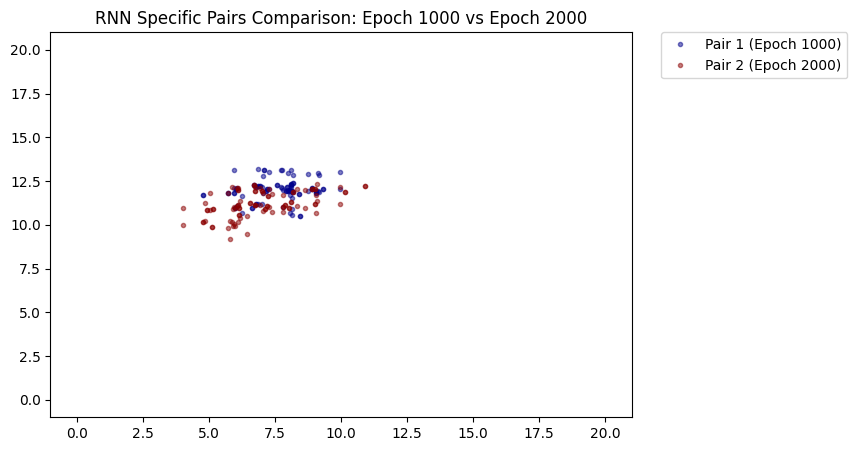

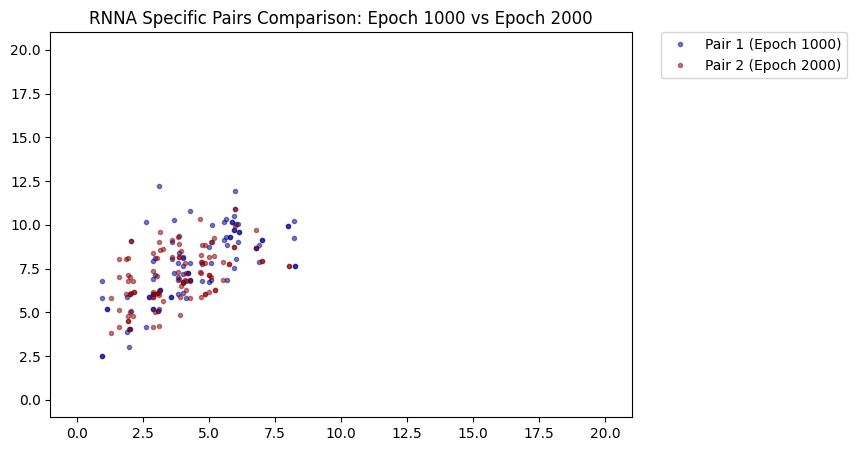

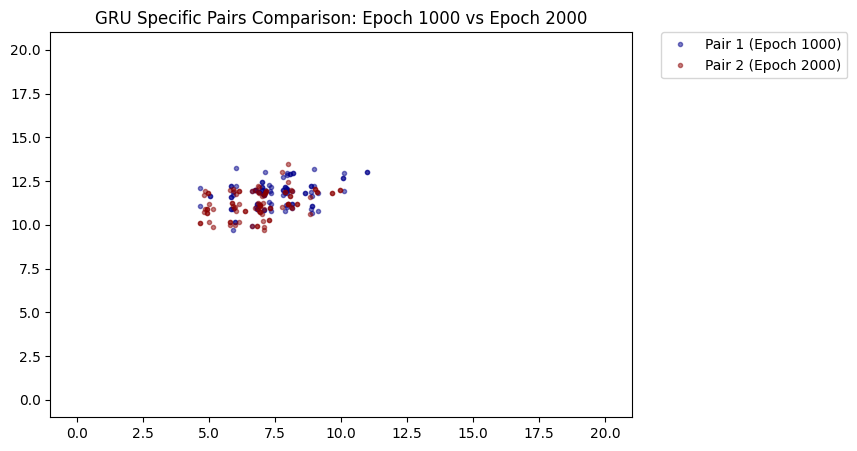

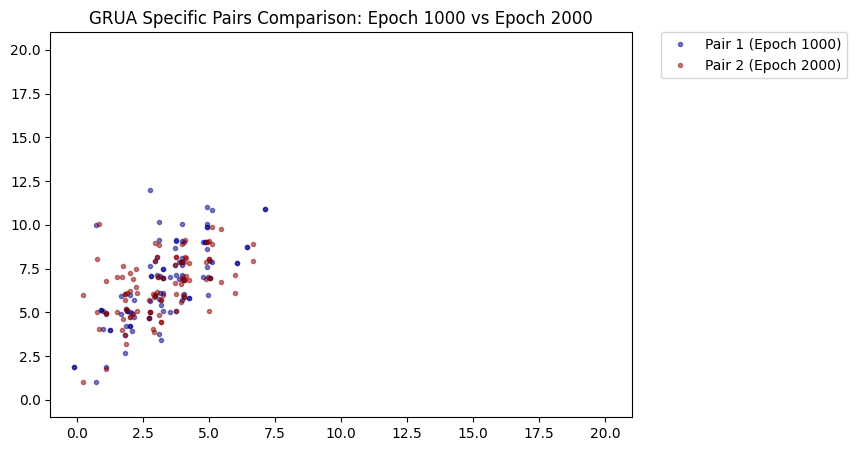

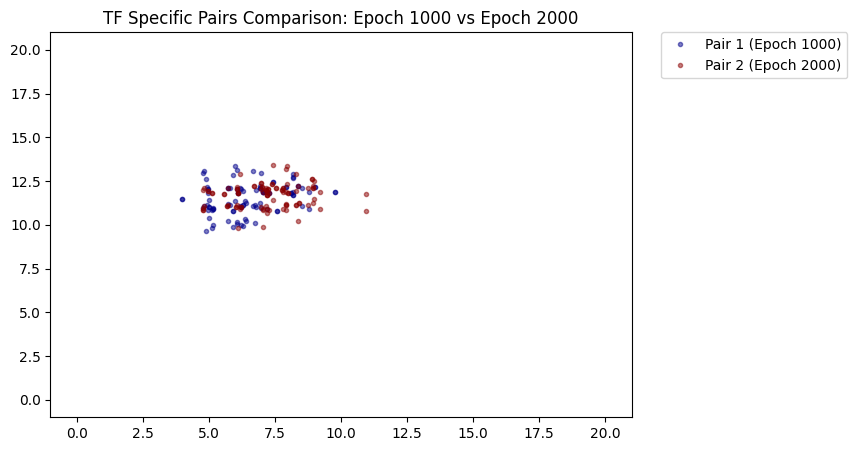

In [126]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'df', 'X', and 'Y' are defined, and dataframes df_1000 and df_2000 are filtered correctly.
nn_types = [
    ('RNN', 'RNNA'),
    ('GRU', 'GRUA'),
    ('TF', None)  # TF does not have an advanced version in this list
]

pairs = [
    ('song_3_song_4_11_overlap', 'Song_3_Nodes_exceeding_treshold', 'Song_4_Nodes_exceeding_treshold'),
    ('song_1_song_2_11_overlap', 'Song_1_Nodes_exceeding_treshold', 'Song_2_Nodes_exceeding_treshold'),
]

# Function to plot comparisons for each neural network type
def plot_comparisons(df_1000, df_2000, X, Y, nn_type):
    fig, ax = plt.subplots(figsize=(7.5, 5))
    
    # Filter by nn_type for both epochs
    who_1000 = df_1000['Kind'] == nn_type
    who_2000 = df_2000['Kind'] == nn_type

    # Colors for epoch 1000 and 2000
    color_epoch_1000 = 'darkblue'
    color_epoch_2000 = 'darkred'
    
    # Plot only the first pair for epoch 1000
    overlap, song1, song2 = pairs[0]
    ax.plot(df_1000[overlap][who_1000] + X[who_1000], df_1000[song1][who_1000] + Y[who_1000], '.', color=color_epoch_1000, alpha=0.5, label=f'Pair 1 (Epoch 1000)')
    ax.plot(df_1000[overlap][who_1000] + X[who_1000], df_1000[song2][who_1000] + Y[who_1000], '.', color=color_epoch_1000, alpha=0.5)
    
    # Plot only the second pair for epoch 2000
    overlap, song1, song2 = pairs[1]
    ax.plot(df_2000[overlap][who_2000] + X[who_2000], df_2000[song1][who_2000] + Y[who_2000], '.', color=color_epoch_2000, alpha=0.5, label=f'Pair 2 (Epoch 2000)')
    ax.plot(df_2000[overlap][who_2000] + X[who_2000], df_2000[song2][who_2000] + Y[who_2000], '.', color=color_epoch_2000, alpha=0.5)
    
    ax.set_xlim(-1, 21)
    ax.set_ylim(-1, 21)
    ax.set_title(f'{nn_type} Specific Pairs Comparison: Epoch 1000 vs Epoch 2000')

    # Add legend outside the plot area
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

    plt.show()

# Plotting comparisons for each neural network type
for nn_type, nn_advanced in nn_types:
    if nn_advanced:
        # Plot for regular type
        plot_comparisons(df_1000, df_2000, X, Y, nn_type)
        # Plot for advanced type
        plot_comparisons(df_1000, df_2000, X, Y, nn_advanced)
    else:
        # Only one type to plot (e.g., TF)
        plot_comparisons(df_1000, df_2000, X, Y, nn_type)


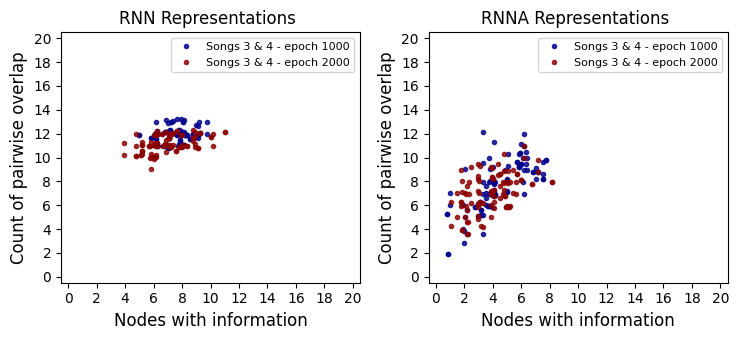

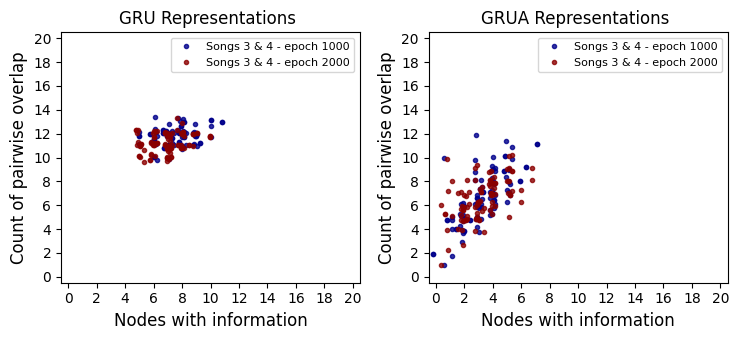

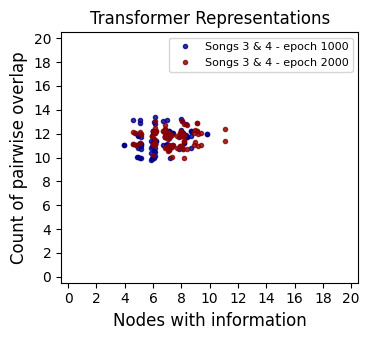

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot comparisons for each neural network type
def plot_comparisons(df_1000, df_2000, X, Y, nn_type1, nn_type2=None):
    cols = 2 if nn_type2 else 1
    fig, axs = plt.subplots(1, cols, figsize=(7.5 if nn_type2 else 3.8, 3.5))
    if not isinstance(axs, np.ndarray):
        axs = [axs]  # Ensure axs is iterable

    nn_types = [nn_type1] if nn_type2 is None else [nn_type1, nn_type2]

    for idx, nn_type in enumerate(nn_types):
        ax = axs[idx]
        who_1000 = df_1000['Kind'] == nn_type
        who_2000 = df_2000['Kind'] == nn_type

        color_epoch_1000 = 'darkblue'
        color_epoch_2000 = 'darkred'
        
        overlap, song1, song2 = pairs[0]
        ax.plot(df_1000[overlap][who_1000] + X[who_1000], df_1000[song1][who_1000] + Y[who_1000], '.', color=color_epoch_1000, alpha=0.8, label=f'Songs 3 & 4 - epoch 1000')
        ax.plot(df_1000[overlap][who_1000] + X[who_1000], df_1000[song2][who_1000] + Y[who_1000], '.', color=color_epoch_1000, alpha=0.8)

        overlap, song1, song2 = pairs[1]
        ax.plot(df_2000[overlap][who_2000] + X[who_2000], df_2000[song1][who_2000] + Y[who_2000], '.', color=color_epoch_2000, alpha=0.8, label=f'Songs 3 & 4 - epoch 2000')
        ax.plot(df_2000[overlap][who_2000] + X[who_2000], df_2000[song2][who_2000] + Y[who_2000], '.', color=color_epoch_2000, alpha=0.8)
        
        # Set custom limits for the axes
        ax.set_xlim(-0.5, 20.5)
        ax.set_ylim(-0.5, 20.5)
        title = "Transformer Representations" if nn_type == "TF" else f"{nn_type} Representations "
        ax.set_title(title ,fontsize = 12)
        ax.set_xlabel("Nodes with information", fontsize = 12)
        ax.set_ylabel("Count of pairwise overlap", fontsize = 12)
        
        # Set integer ticks incremented by 2
        ax.set_xticks(np.arange(0, 21, 2))
        ax.set_yticks(np.arange(0, 21, 2))

        # Place the legend inside the plot in the upper right corner
        ax.legend(loc='upper right', fontsize=8)
        

    plt.tight_layout()
    # Specific filename for catastrophic forgetting heatmap
    plt.savefig(f"./Final-Plots/Catastrophic_Forget_Heatmap_{nn_type1}_{nn_type2 if nn_type2 else ''}.pdf")
    plt.show()

# Define neural network types and pair configurations
nn_types = [
    ('RNN', 'RNNA'),
    ('GRU', 'GRUA'),
    ('TF', None)  # TF does not have an advanced version
]

pairs = [
    ('song_3_song_4_11_overlap', 'Song_3_Nodes_exceeding_treshold', 'Song_4_Nodes_exceeding_treshold'),
    ('song_1_song_2_11_overlap', 'Song_1_Nodes_exceeding_treshold', 'Song_2_Nodes_exceeding_treshold'),
]

# Assuming 'df_1000', 'df_2000', 'X', and 'Y' are dataframes and arrays properly defined
for nn_type1, nn_type2 in nn_types:
    plot_comparisons(df_1000, df_2000, X, Y, nn_type1, nn_type2)


In [5]:
data_epoch_1000 = df[df['epoch'] == 1000]

In [6]:
data_epoch_1000_overlap = data_epoch_1000[['Kind','Repetition','Total_Overlapp_percentage','epoch','count_00_for_songs_34']]

In [7]:
data_epoch_1000_overlap

Kind  Repetition  Total_Overlapp_percentage  epoch  count_00_for_songs_34
0    RNN           0                      56.25   1000                      5
1    RNN           1                      57.50   1000                      4
2    RNN           2                      60.00   1000                      2
3    RNN           3                      55.00   1000                      5
4    RNN           4                      61.25   1000                      5
..   ...         ...                        ...    ...                    ...
245   TF          45                      56.25   1000                      3
246   TF          46                      51.25   1000                      2
247   TF          47                      48.75   1000                      4
248   TF          48                      45.00   1000                      5
249   TF          49                      50.00   1000                      1

[250 rows x 5 columns]

In [8]:
import pandas as pd

# Adjusted function to output more detailed results suitable for DataFrame creation
def analyze_model_accuracies_songs_12(model_names, num_iterations=50, data_folder='dataCF'):
    all_results = []  # List to store results for DataFrame

    for model_name in model_names:
        for iteration in range(num_iterations):
            # Construct the file path based on the model name and iteration
            file_name = f'acc_{model_name}_{iteration}.csv'
            if  model_name == 'TF':
                 file_name = f"acc_CF_{model_name}_{iteration}.csv"
            file_path = os.path.join(data_folder, file_name)

            # Check if the file exists
            if os.path.exists(file_path):
                # Load and process data if the file exists
                data = pd.read_csv(file_path)
                if not data.empty:
                    accuracies = data['acc'].apply(myEval).tolist()

                    # Assuming each row in the file represents consecutive epochs
                    accuracies = np.array(accuracies)

                    # Process each song's accuracy, focusing on Song 1 and Song 2 for this demonstration
                    for song_index in range(2):  # only process the first two songs for demonstration
                        if accuracies.shape[0] >= 2000:
                            song_accuracies = accuracies[:2000, song_index]
                        else:
                            repeat_factor = int(np.ceil(2000 / accuracies.shape[0]))
                            song_accuracies = np.tile(accuracies[:, song_index], repeat_factor)[:2000]

                        # Calculate 50% drop after 1000 epochs
                        initial_accuracy = song_accuracies[999]
                        drop_index = np.argmax(song_accuracies[1000:] <= initial_accuracy * 0.5) + 1000
                        final_accuracy = song_accuracies[-1]

                        # Save results with detailed info for DataFrame
                        all_results.append({
                            "Kind": model_name,
                            "Repetition": iteration,
                            "Song": song_index + 1,
                            "Epoch at 50% Drop": drop_index,
                            "Final Accuracy": final_accuracy
                        })

    # Convert all results into a DataFrame
    return pd.DataFrame(all_results)

# List of model names
model_names = ["TF", "RNN", "RNNA", "GRU", "GRUA"]

# Call the function to analyze all models and create a DataFrame
df_model_accuracies_songs_12 = analyze_model_accuracies_songs_12(model_names)
df_model_accuracies_songs_12


Kind  Repetition  Song  Epoch at 50% Drop  Final Accuracy
0      TF           0     1               1012        0.268873
1      TF           0     2               1004        0.597561
2      TF           1     1               1055        0.293844
3      TF           1     2               1499        0.439024
4      TF           2     1               1013        0.229965
..    ...         ...   ...                ...             ...
495  GRUA          47     2               1334        0.195122
496  GRUA          48     1               1418        0.227642
497  GRUA          48     2               1000        0.565041
498  GRUA          49     1               1551        0.271196
499  GRUA          49     2               1253        0.227642

[500 rows x 5 columns]

In [9]:
df_model_accuracies_songs_12_merged = pd.merge(df_model_accuracies_songs_12, data_epoch_1000_overlap, on=['Kind', 'Repetition'])


In [10]:
df_model_accuracies_songs_12_merged

Kind  Repetition  Song  Epoch at 50% Drop  Final Accuracy  \
0      TF           0     1               1012        0.268873   
1      TF           0     2               1004        0.597561   
2      TF           1     1               1055        0.293844   
3      TF           1     2               1499        0.439024   
4      TF           2     1               1013        0.229965   
..    ...         ...   ...                ...             ...   
495  GRUA          47     2               1334        0.195122   
496  GRUA          48     1               1418        0.227642   
497  GRUA          48     2               1000        0.565041   
498  GRUA          49     1               1551        0.271196   
499  GRUA          49     2               1253        0.227642   

     Total_Overlapp_percentage  epoch  count_00_for_songs_34  
0                        53.75   1000                      3  
1                        53.75   1000                      3  
2                        55.00   1000                      1  
3                        55.00   1000                      1  
4                        53.75   1000                      4  
..                         ...    ...                    ...  
495                      26.25   1000                      9  
496                      33.75   1000                     12  
497                      33.75   1000                     12  
498                      18.75   1000                     14  
499                      18.75   1000                     14  

[500 rows x 8 columns]

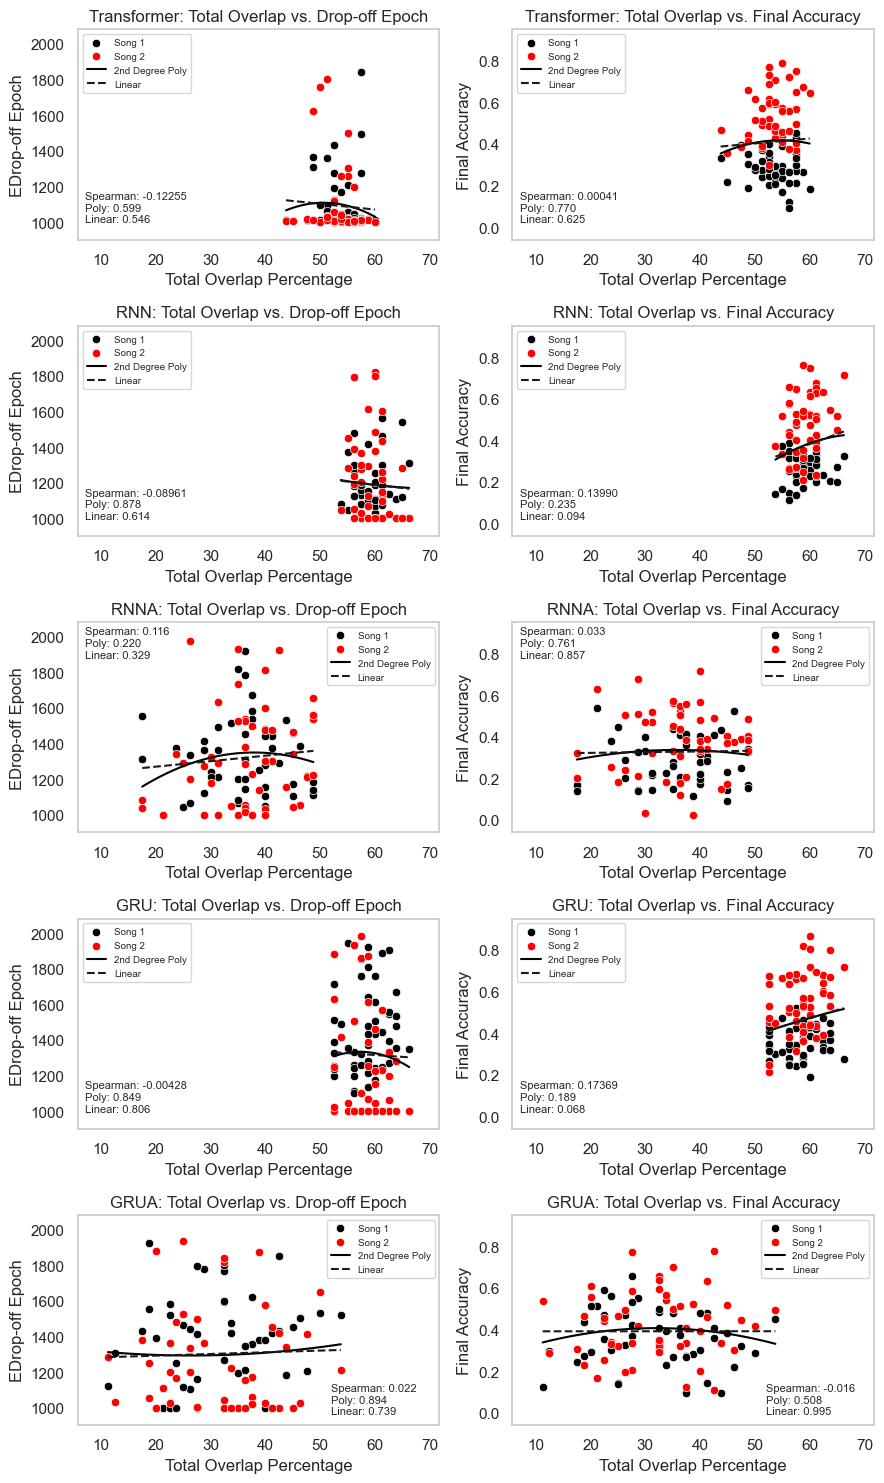

In [11]:
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from scipy.stats import spearmanr, f

    # Assuming df_model_accuracies_songs_12_merged is already loaded
    sns.set(style="whitegrid")

    # Setup the subplots for each model and metric
    fig, axs = plt.subplots(5, 2, figsize=(9, 15))  # 5 models x 2 metrics

    model_names = ["TF", "RNN", "RNNA", "GRU", "GRUA"]
    all_x = []
    all_y_epoch = []
    all_y_accuracy = []

    # Define a function to plot polynomial and linear regression for a specified model
    def plot_regression(model, df, x, y, ax, title="", xlabel="", ylabel="", metric_type='epoch'):
        global all_x, all_y_epoch, all_y_accuracy
        
        # Extend all_x and depending on metric type, extend respective y list
        all_x.extend(df[x].tolist())
        if metric_type == 'epoch':
            all_y_epoch.extend(df[y].tolist())
        else:
            all_y_accuracy.extend(df[y].tolist())

        sns.scatterplot(x=x, y=y, data=df[df['Song'] == 1], color='black', ax=ax, label='Song 1')
        sns.scatterplot(x=x, y=y, data=df[df['Song'] == 2], color='red', ax=ax, label='Song 2')
        
        # Use local minimum and maximum for linspace
        local_min_x = df[x].min()
        local_max_x = df[x].max()
        x_poly = np.linspace(local_min_x, local_max_x, 100)
        
        # Polynomial and linear regressions
        coeffs_poly = np.polyfit(df[x], df[y], 2)
        poly_eq = np.poly1d(coeffs_poly)
        y_poly = poly_eq(x_poly)
        ax.plot(x_poly, y_poly, color='black', label='2nd Degree Poly')
        
        coeffs_linear = np.polyfit(df[x], df[y], 1)
        linear_eq = np.poly1d(coeffs_linear)
        y_linear = linear_eq(x_poly)
        ax.plot(x_poly, y_linear, 'k--', label='Linear')

        # Calculate R^2 for the polynomial regression
        y_fit_poly = poly_eq(df[x])
        ss_res_poly = np.sum((df[y] - y_fit_poly) ** 2)
        ss_tot_poly = np.sum((df[y] - np.mean(df[y])) ** 2)
        r_squared_poly = 1 - (ss_res_poly / ss_tot_poly)
        
        # Calculate F-statistic and p-value for polynomial regression
        n = len(df[x])
        k_poly = 2  # 2nd degree polynomial has 2 predictors
        df1_poly = k_poly
        df2_poly = n - k_poly - 1
        F_poly = (r_squared_poly / k_poly) / ((1 - r_squared_poly) / df2_poly)
        p_poly = f.sf(F_poly, df1_poly, df2_poly)
        poly_significance = "(*)" if p_poly < 0.05 else ""

        # Calculate R^2 for the linear regression
        y_fit_linear = linear_eq(df[x])
        ss_res_linear = np.sum((df[y] - y_fit_linear) ** 2)
        ss_tot_linear = np.sum((df[y] - np.mean(df[y])) ** 2)
        r_squared_linear = 1 - (ss_res_linear / ss_tot_linear)
        
        # Calculate F-statistic and p-value for linear regression
        k_linear = 1  # Linear regression has 1 predictor
        df1_linear = k_linear
        df2_linear = n - k_linear - 1
        F_linear = (r_squared_linear / k_linear) / ((1 - r_squared_linear) / df2_linear)
        p_linear = f.sf(F_linear, df1_linear, df2_linear)
        linear_significance = "(*)" if p_linear < 0.05 else ""

        spearman_corr, p_spearman = spearmanr(df[x], df[y])
        spearman_significance = "(*)" if p_spearman < 0.05 else ""
        
        ax.set_title(title, fontsize = 12)
        ax.set_xlabel(xlabel, fontsize = 12)
        ax.set_ylabel(ylabel, fontsize = 12)
        ax.legend(title='', fontsize = 7)
        
        if model in ['TF','RNN', 'GRU'] and y in ['Final Accuracy', 'Epoch at 50% Drop']:
            text_x = 0.02
            text_y = 0.23
            spearman_corr = f'{spearman_corr:.5f}'
            vertical_align = 'top'
        elif model in ['GRUA'] and y in ['Final Accuracy', 'Epoch at 50% Drop']:
            text_x = 0.7
            text_y = 0.2
            vertical_align = 'top'
            spearman_corr = f'{spearman_corr:.3f}'
        else:
            text_x = 0.02
            text_y = 0.98
            vertical_align = 'top'
            spearman_corr = f'{spearman_corr:.3f}'
        ax.text(text_x, text_y, 
                f'Spearman: {spearman_corr} {spearman_significance}\n'
                f'Poly: {p_poly:.3f} {poly_significance}\n'
                f'Linear: {p_linear:.3f} {linear_significance}', 
                transform=ax.transAxes, verticalalignment=vertical_align, fontsize=8, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
        ax.grid(False)  # Turn off the grid for each subplot

    # Process each model and metric
    for idx, model in enumerate(model_names):
        df_filtered = df_model_accuracies_songs_12_merged[df_model_accuracies_songs_12_merged['Kind'] == model]
        title = "Transformer" if model == "TF" else f"{model}"

        plot_regression(model, df_filtered, 'Total_Overlapp_percentage', 'Epoch at 50% Drop', axs[idx, 0], 
                        title=f'{title}: Total Overlap vs. Drop-off Epoch', 
                        xlabel='Total Overlap Percentage', ylabel='EDrop-off Epoch', metric_type='epoch')
        plot_regression(model, df_filtered, 'Total_Overlapp_percentage', 'Final Accuracy', axs[idx, 1], 
                        title=f'{title}: Total Overlap vs. Final Accuracy', 
                        xlabel='Total Overlap Percentage', ylabel='Final Accuracy', metric_type='accuracy')

    # Global x limits and separate y limits for epochs and accuracy
    x_range = max(all_x) - min(all_x)
    x_padding = 0.1 * x_range
    x_lim = [min(all_x) - x_padding, max(all_x) + x_padding]

    y_epoch_range = max(all_y_epoch) - min(all_y_epoch)
    y_epoch_padding = 0.1 * y_epoch_range
    y_epoch_lim = [min(all_y_epoch) - y_epoch_padding, max(all_y_epoch) + y_epoch_padding]

    y_accuracy_range = max(all_y_accuracy) - min(all_y_accuracy)
    y_accuracy_padding = 0.1 * y_accuracy_range
    y_accuracy_lim = [min(all_y_accuracy) - y_accuracy_padding, max(all_y_accuracy) + y_accuracy_padding]

    # Apply consistent x-axis limits and respective y-axis limits
    for i, ax in enumerate(axs.flat):
        ax.set_xlim(x_lim)
        if i % 2 == 0:
            ax.set_ylim(y_epoch_lim)
        else:
            ax.set_ylim(y_accuracy_lim) 

    plt.tight_layout()
    plt.savefig(f"./Final-Plots/song_1_2_overlap.pdf")
    plt.show()


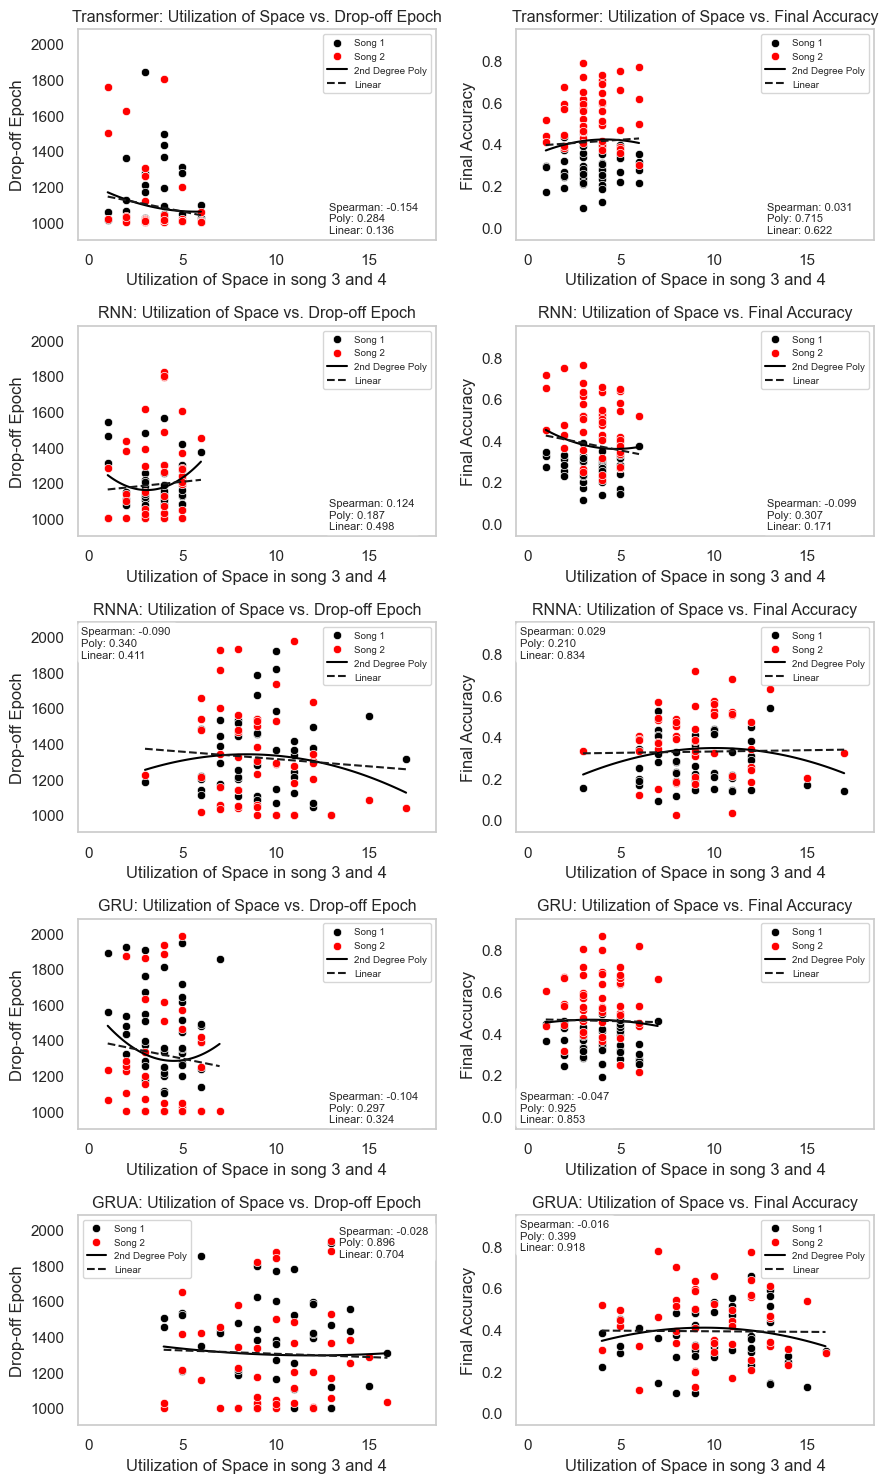

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, f

# Assuming df_model_accuracies_songs_12_merged is already loaded
sns.set(style="whitegrid")

# Setup the subplots for each model and metric
fig, axs = plt.subplots(5, 2, figsize=(9, 15))  # 5 models x 2 metrics

model_names = ["TF", "RNN", "RNNA", "GRU", "GRUA"]
all_x = []
all_y_epoch = []
all_y_accuracy = []

# Define a function to plot polynomial and linear regression for a specified model
def plot_regression(df, x, y, ax, title="", xlabel="", ylabel="", metric_type='epoch'):
    global all_x, all_y_epoch, all_y_accuracy
    
    # Extend all_x and depending on metric type, extend respective y list
    all_x.extend(df[x].tolist())
    if metric_type == 'epoch':
        all_y_epoch.extend(df[y].tolist())
    else:
        all_y_accuracy.extend(df[y].tolist())

    sns.scatterplot(x=x, y=y, data=df[df['Song'] == 1], color='black', ax=ax, label='Song 1')
    sns.scatterplot(x=x, y=y, data=df[df['Song'] == 2], color='red', ax=ax, label='Song 2')
    
    # Use local minimum and maximum for linspace
    local_min_x = df[x].min()
    local_max_x = df[x].max()
    x_poly = np.linspace(local_min_x, local_max_x, 100)
    
    # Polynomial and linear regressions
    coeffs_poly = np.polyfit(df[x], df[y], 2)
    poly_eq = np.poly1d(coeffs_poly)
    y_poly = poly_eq(x_poly)
    ax.plot(x_poly, y_poly, color='black', label='2nd Degree Poly')
    
    coeffs_linear = np.polyfit(df[x], df[y], 1)
    linear_eq = np.poly1d(coeffs_linear)
    y_linear = linear_eq(x_poly)
    ax.plot(x_poly, y_linear, 'k--', label='Linear')

    # Calculate R^2 for the polynomial regression
    y_fit_poly = poly_eq(df[x])
    ss_res_poly = np.sum((df[y] - y_fit_poly) ** 2)
    ss_tot_poly = np.sum((df[y] - np.mean(df[y])) ** 2)
    r_squared_poly = 1 - (ss_res_poly / ss_tot_poly)
    
    # Calculate F-statistic and p-value for polynomial regression
    n = len(df[x])
    k_poly = 2  # 2nd degree polynomial has 2 predictors
    df1_poly = k_poly
    df2_poly = n - k_poly - 1
    F_poly = (r_squared_poly / k_poly) / ((1 - r_squared_poly) / df2_poly)
    p_poly = f.sf(F_poly, df1_poly, df2_poly)
    poly_significance = "(*)" if p_poly < 0.05 else ""

    # Calculate R^2 for the linear regression
    y_fit_linear = linear_eq(df[x])
    ss_res_linear = np.sum((df[y] - y_fit_linear) ** 2)
    ss_tot_linear = np.sum((df[y] - np.mean(df[y])) ** 2)
    r_squared_linear = 1 - (ss_res_linear / ss_tot_linear)
    
    # Calculate F-statistic and p-value for linear regression
    k_linear = 1  # Linear regression has 1 predictor
    df1_linear = k_linear
    df2_linear = n - k_linear - 1
    F_linear = (r_squared_linear / k_linear) / ((1 - r_squared_linear) / df2_linear)
    p_linear = f.sf(F_linear, df1_linear, df2_linear)
    linear_significance = "(*)" if p_linear < 0.05 else ""

    spearman_corr, p_spearman = spearmanr(df[x], df[y])
    spearman_significance = "(*)" if p_spearman < 0.05 else ""
    
    ax.set_title(title, fontsize = 11.5)
    ax.set_xlabel(xlabel, fontsize = 12)
    ax.set_ylabel(ylabel, fontsize = 12)
    ax.legend(title='', fontsize = 7)
    if model in ['GRU'] and y in ['Final Accuracy']:
        text_x = 0.01
        text_y = 0.18
        vertical_align = 'top'
    elif model in ['GRU'] and y in ['Epoch at 50% Drop']:
        text_x = 0.70
        text_y = 0.18
        vertical_align = 'top'
    elif model in ['GRUA'] and y in ['Epoch at 50% Drop']:
        text_x = 0.73
        text_y = 0.95
        vertical_align = 'top'   
    elif model in ['RNN', 'TF'] and y in ['Final Accuracy','Epoch at 50% Drop']:
        text_x = 0.70
        text_y = 0.18
        vertical_align = 'top'
    else:
        text_x = 0.01
        text_y = 0.98
        vertical_align = 'top'

    ax.text(text_x, text_y, 
            f'Spearman: {spearman_corr:.3f} {spearman_significance}\n'
            f'Poly: {p_poly:.3f} {poly_significance}\n'
            f'Linear: {p_linear:.3f} {linear_significance}', 
            transform=ax.transAxes, verticalalignment=vertical_align, fontsize=8,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    ax.grid(False)  # Remove grid

# Process each model and metric
for idx, model in enumerate(model_names):
    df_filtered = df_model_accuracies_songs_12_merged[df_model_accuracies_songs_12_merged['Kind'] == model]
    title = "Transformer" if model == "TF" else f"{model}"

    plot_regression(df_filtered, 'count_00_for_songs_34', 'Epoch at 50% Drop', axs[idx, 0], 
                    title=f'{title}: Utilization of Space vs. Drop-off Epoch', 
                    xlabel='Utilization of Space in song 3 and 4', ylabel='Drop-off Epoch', metric_type='epoch')
    plot_regression(df_filtered, 'count_00_for_songs_34', 'Final Accuracy', axs[idx, 1], 
                    title=f'{title}: Utilization of Space vs. Final Accuracy', 
                    xlabel='Utilization of Space in song 3 and 4', ylabel='Final Accuracy', metric_type='accuracy')

# Global x limits and separate y limits for epochs and accuracy
x_range = max(all_x) - min(all_x)
x_padding = 0.1 * x_range
x_lim = [min(all_x) - x_padding, max(all_x) + x_padding]

y_epoch_range = max(all_y_epoch) - min(all_y_epoch)
y_epoch_padding = 0.1 * y_epoch_range
y_epoch_lim = [min(all_y_epoch) - y_epoch_padding, max(all_y_epoch) + y_epoch_padding]

y_accuracy_range = max(all_y_accuracy) - min(all_y_accuracy)
y_accuracy_padding = 0.1 * y_accuracy_range
y_accuracy_lim = [min(all_y_accuracy) - y_accuracy_padding, max(all_y_accuracy) + y_accuracy_padding]

# Apply consistent x-axis limits and respective y-axis limits
for i, ax in enumerate(axs.flat):
    ax.set_xlim(x_lim)
    if i % 2 == 0:
        ax.set_ylim(y_epoch_lim)
    else:
        ax.set_ylim(y_accuracy_lim)

plt.tight_layout()
plt.savefig(f"./Final-Plots/song_1_2_empty.pdf")
plt.show()


In [13]:
import os
import pandas as pd
import numpy as np

def analyze_simple_50_percent_reach_model_accuracies_songs_56(model_names, num_iterations=50, data_folder='dataCF'):
    all_results = []  # List to store results for DataFrame

    for model_name in model_names:
        for iteration in range(num_iterations):
            # Construct the file path based on the model name and iteration
            file_name = f'acc_{model_name}_{iteration}.csv'
            if  model_name == 'TF':
                file_name = f"acc_CF_{model_name}_{iteration}.csv"

            file_path = os.path.join(data_folder, file_name)

            # Check if the file exists
            if os.path.exists(file_path):
                # Load and process data if the file exists
                data = pd.read_csv(file_path)
                if not data.empty:
                    # Convert string accuracies to list of floats
                    accuracies = data['acc'].apply(myEval).tolist()

                    # Assuming each row in the file represents consecutive epochs
                    accuracies = np.array(accuracies)

                    # Focus on Song 5 and Song 6
                    for song_index in range(4,6):  # only process the first two songs for demonstration
                        if accuracies.shape[0] >= 2000:
                            song_accuracies = accuracies[:2000, song_index]
                        else:
                            repeat_factor = int(np.ceil(2000 / accuracies.shape[0]))
                            song_accuracies = np.tile(accuracies[:, song_index], repeat_factor)[:2000]


                        # Determine the maximum accuracy from epoch 1000 onwards
                        max_accuracy_post_1000 = np.max(song_accuracies[1000:])
                        target_accuracy = max_accuracy_post_1000 * 0.5

                        # Calculate when accuracy reaches 50% of the max accuracy after epoch 1000
                        post_1000_accuracies = song_accuracies[1000:]
                        reach_50_index = np.where(post_1000_accuracies >= 0.5)[0][0] + 1000 if np.any(post_1000_accuracies >= 0.5) else 2000
                        
                        # Save results with detailed info for DataFrame
                        all_results.append({
                            "Kind": model_name,
                            "Repetition": iteration,
                            "Song": song_index + 1,
                            "Epoch to Reach 50% Accuracy": reach_50_index,
                            "Highest Accuracy": max_accuracy_post_1000
                        })
                        
    # Convert all results into a DataFrame
    return pd.DataFrame(all_results)

# List of model names
model_names = ["TF", "RNN", "RNNA", "GRU", "GRUA"]

# Call the function to analyze all models for Songs 5 and 6 and create a DataFrame
df_simple_50_reach_accuracies_songs_56 = analyze_simple_50_percent_reach_model_accuracies_songs_56(model_names)
df_simple_50_reach_accuracies_songs_56


Kind  Repetition  Song  Epoch to Reach 50% Accuracy  Highest Accuracy
0      TF           0     5                         1055          0.957027
1      TF           0     6                         1053          0.954123
2      TF           1     5                         1063          0.961672
3      TF           1     6                         1041          0.959350
4      TF           2     5                         1096          0.958769
..    ...         ...   ...                          ...               ...
495  GRUA          47     6                         1265          0.814750
496  GRUA          48     5                         1209          0.700929
497  GRUA          48     6                         1174          0.793264
498  GRUA          49     5                         1462          0.699768
499  GRUA          49     6                         1304          0.684669

[500 rows x 5 columns]

In [14]:
df_model_accuracies_songs_56_merged = pd.merge(df_simple_50_reach_accuracies_songs_56, data_epoch_1000_overlap, on=['Kind', 'Repetition'])

In [15]:
df_model_accuracies_songs_56_merged

Kind  Repetition  Song  Epoch to Reach 50% Accuracy  Highest Accuracy  \
0      TF           0     5                         1055          0.957027   
1      TF           0     6                         1053          0.954123   
2      TF           1     5                         1063          0.961672   
3      TF           1     6                         1041          0.959350   
4      TF           2     5                         1096          0.958769   
..    ...         ...   ...                          ...               ...   
495  GRUA          47     6                         1265          0.814750   
496  GRUA          48     5                         1209          0.700929   
497  GRUA          48     6                         1174          0.793264   
498  GRUA          49     5                         1462          0.699768   
499  GRUA          49     6                         1304          0.684669   

     Total_Overlapp_percentage  epoch  count_00_for_songs_34  
0                        53.75   1000                      3  
1                        53.75   1000                      3  
2                        55.00   1000                      1  
3                        55.00   1000                      1  
4                        53.75   1000                      4  
..                         ...    ...                    ...  
495                      26.25   1000                      9  
496                      33.75   1000                     12  
497                      33.75   1000                     12  
498                      18.75   1000                     14  
499                      18.75   1000                     14  

[500 rows x 8 columns]

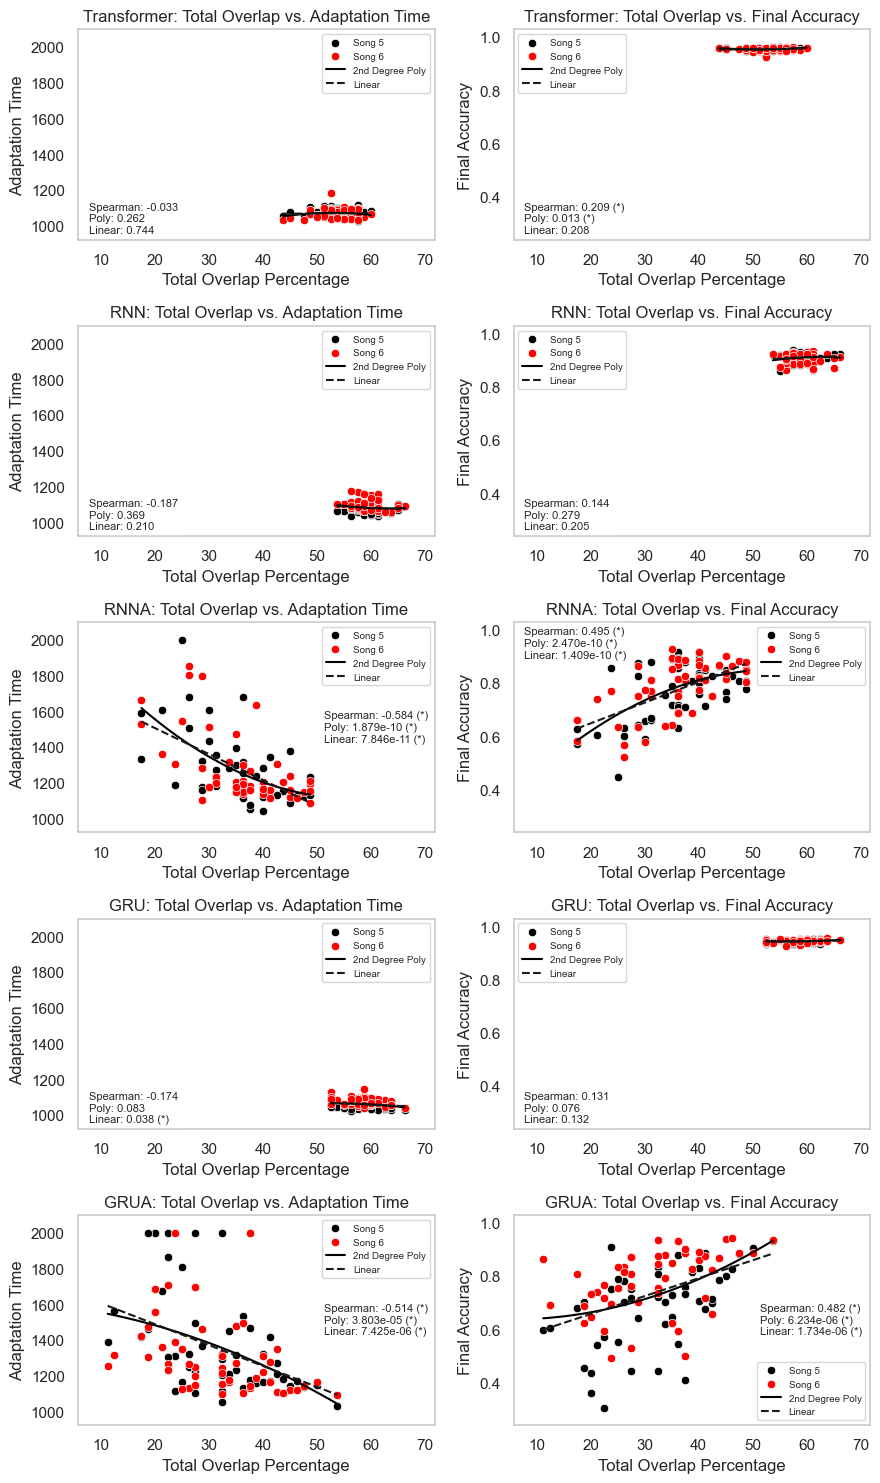

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, f

# Assuming df_model_accuracies_songs_56_merged is already loaded
sns.set(style="whitegrid")

# Define model names
model_names = ["TF", "RNN", "RNNA", "GRU", "GRUA"]

# Set up the figure with subplots - 5 models x 2 metrics (as we combine songs for each metric)
fig, axs = plt.subplots(len(model_names), 2, figsize=(9, 15))  # Adjust size as needed

all_x = []
all_y_epoch = []
all_y_accuracy = []

# Define a function to plot combined polynomial and linear regression for a specified model
def plot_combined_regression(model, df, x, y, ax, title="", xlabel="", ylabel="", metric_type='epoch'):
    global all_x, all_y_epoch, all_y_accuracy
    
    # Extend all_x and depending on metric type, extend respective y list
    all_x.extend(df[x].tolist())
    if metric_type == 'epoch':
        all_y_epoch.extend(df[y].tolist())
    else:
        all_y_accuracy.extend(df[y].tolist())

    sns.scatterplot(x=x, y=y, data=df[df['Song'] == 5], color='black', ax=ax, label='Song 5')
    sns.scatterplot(x=x, y=y, data=df[df['Song'] == 6], color='red', ax=ax, label='Song 6')
    
    combined_df = df[df['Song'].isin([5, 6])]
    coeffs_poly = np.polyfit(combined_df[x], combined_df[y], 2)
    poly_eq = np.poly1d(coeffs_poly)
    x_poly = np.linspace(combined_df[x].min(), combined_df[x].max(), 100)
    y_poly = poly_eq(x_poly)
    ax.plot(x_poly, y_poly, color='black', label='2nd Degree Poly')

    coeffs_linear = np.polyfit(combined_df[x], combined_df[y], 1)
    linear_eq = np.poly1d(coeffs_linear)
    y_linear = linear_eq(x_poly)
    ax.plot(x_poly, y_linear, 'k--', label='Linear')

    # Calculate R^2 for the polynomial regression
    y_fit_poly = poly_eq(combined_df[x])
    ss_res_poly = np.sum((combined_df[y] - y_fit_poly) ** 2)
    ss_tot_poly = np.sum((combined_df[y] - np.mean(combined_df[y])) ** 2)
    r_squared_poly = 1 - (ss_res_poly / ss_tot_poly)
    
    # Calculate F-statistic and p-value for polynomial regression
    n = len(combined_df[x])
    k_poly = 2  # 2nd degree polynomial has 2 predictors
    df1_poly = k_poly
    df2_poly = n - k_poly - 1
    F_poly = (r_squared_poly / k_poly) / ((1 - r_squared_poly) / df2_poly)
    p_poly = f.sf(F_poly, df1_poly, df2_poly)
    poly_significance = "(*)" if p_poly < 0.05 else ""

    # Calculate R^2 for the linear regression
    y_fit_linear = linear_eq(combined_df[x])
    ss_res_linear = np.sum((combined_df[y] - y_fit_linear) ** 2)
    ss_tot_linear = np.sum((combined_df[y] - np.mean(combined_df[y])) ** 2)
    r_squared_linear = 1 - (ss_res_linear / ss_tot_linear)
    
    # Calculate F-statistic and p-value for linear regression
    k_linear = 1  # Linear regression has 1 predictor
    df1_linear = k_linear
    df2_linear = n - k_linear - 1
    F_linear = (r_squared_linear / k_linear) / ((1 - r_squared_linear) / df2_linear)
    p_linear = f.sf(F_linear, df1_linear, df2_linear)
    linear_significance = "(*)" if p_linear < 0.05 else ""

    spearman_corr, p_spearman = spearmanr(combined_df[x], combined_df[y])
    spearman_significance = "(*)" if p_spearman < 0.05 else ""
    
    ax.set_title(title, fontsize = 12)
    ax.set_xlabel(xlabel, fontsize = 12)
    ax.set_ylabel(ylabel, fontsize = 12)
    ax.legend(title='', fontsize = 7)

    if model in ['TF' ,'RNN', 'GRU'] and y in ['Epoch to Reach 50% Accuracy','Highest Accuracy']:
        text_x = 0.03
        text_y = 0.18
        vertical_align = 'top'
        p_poly = f'{p_poly:.3f}'
        p_linear =f'{p_linear:.3f}'
    elif model in ['GRUA'] and y in ['Epoch to Reach 50% Accuracy','Highest Accuracy']:
        text_x = 0.69
        text_y = 0.58
        vertical_align = 'top'
        p_poly = f'{p_poly:.3e}'
        p_linear =f'{p_linear:.3e}'

    elif model in ['RNNA'] and y in ['Epoch to Reach 50% Accuracy']:
        text_x = 0.69
        text_y = 0.58
        vertical_align = 'top'
        p_poly = f'{p_poly:.3e}'
        p_linear =f'{p_linear:.3e}'
    elif model in ['RNNA'] and y in ['Highest Accuracy']:
        text_x = 0.03
        text_y = 0.98
        vertical_align = 'top'
        p_poly = f'{p_poly:.3e}'
        p_linear =f'{p_linear:.3e}'
    else:
        text_x = 0.03
        text_y = 0.98
        vertical_align = 'top'
        p_poly = f'{p_poly:.3f}'
        p_linear =f'{p_linear:.3f}'

    ax.text(text_x, text_y, 
            f'Spearman: {spearman_corr:.3f} {spearman_significance}\n'
            f'Poly: {p_poly} {poly_significance}\n'
            f'Linear: {p_linear} {linear_significance}', 
            transform=ax.transAxes, verticalalignment=vertical_align, fontsize = 8,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    ax.grid(False)  # Remove grid


# Iterate over each model to create combined plots
for i, model in enumerate(model_names):
    df_filtered = df_model_accuracies_songs_56_merged[df_model_accuracies_songs_56_merged['Kind'] == model]
    title = "Transformer" if model == "TF" else f"{model}"

    plot_combined_regression(model, df_filtered, 'Total_Overlapp_percentage', 'Epoch to Reach 50% Accuracy', axs[i, 0], 
                             title=f'{title}: Total Overlap vs. Adaptation Time', 
                             xlabel='Total Overlap Percentage', ylabel='Adaptation Time', metric_type='epoch')
    plot_combined_regression(model, df_filtered, 'Total_Overlapp_percentage', 'Highest Accuracy', axs[i, 1], 
                             title=f'{title}: Total Overlap vs. Final Accuracy', 
                             xlabel='Total Overlap Percentage', ylabel='Final Accuracy', metric_type='accuracy')

# Determine consistent x-axis limits and separate y-axis limits
x_padding = 0.1 * (max(all_x) - min(all_x))
x_lim = [min(all_x) - x_padding, max(all_x) + x_padding]

y_epoch_padding = 0.1 * (max(all_y_epoch) - min(all_y_epoch))
y_epoch_lim = [min(all_y_epoch) - y_epoch_padding, max(all_y_epoch) + y_epoch_padding]

y_accuracy_padding = 0.1 * (max(all_y_accuracy) - min(all_y_accuracy))
y_accuracy_lim = [min(all_y_accuracy) - y_accuracy_padding, max(all_y_accuracy) + y_accuracy_padding]

# Apply consistent x-axis limits and respective y-axis limits
for i, ax in enumerate(axs.flat):
    ax.set_xlim(x_lim)
    if i % 2 == 0:
        ax.set_ylim(y_epoch_lim)
    else:
        ax.set_ylim(y_accuracy_lim)

plt.tight_layout()
plt.savefig(f"./Final-Plots/song_5_6_overlap.pdf")
plt.show()


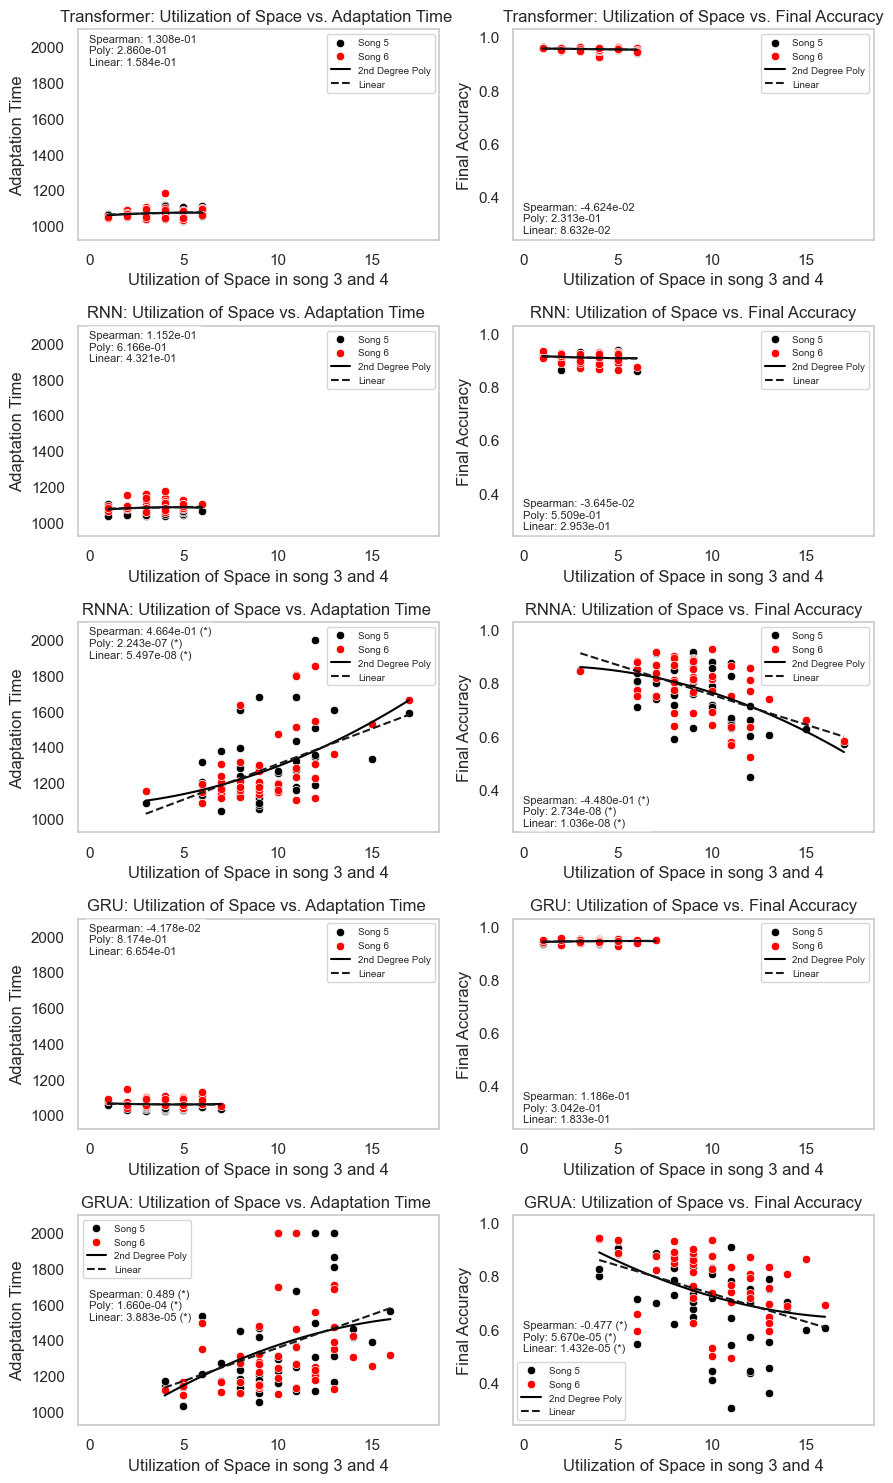

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, f

# Assuming df_model_accuracies_songs_56_merged is already loaded
sns.set(style="whitegrid")

# Define model names
model_names = ["TF", "RNN", "RNNA", "GRU", "GRUA"]

# Set up the figure with subplots - 5 models x 2 metrics (as we combine songs for each metric)
fig, axs = plt.subplots(len(model_names), 2, figsize=(9, 15))  # Adjust size as needed

all_x = []
all_y_epoch = []
all_y_accuracy = []

# Define a function to plot combined polynomial and linear regression for a specified model
def plot_combined_regression(model, df, x, y, ax, title="", xlabel="", ylabel="", metric_type='epoch'):
    global all_x, all_y_epoch, all_y_accuracy
    
    # Extend all_x and depending on metric type, extend respective y list
    all_x.extend(df[x].tolist())
    if metric_type == 'epoch':
        all_y_epoch.extend(df[y].tolist())
    else:
        all_y_accuracy.extend(df[y].tolist())

    sns.scatterplot(x=x, y=y, data=df[df['Song'] == 5], color='black', ax=ax, label='Song 5')
    sns.scatterplot(x=x, y=y, data=df[df['Song'] == 6], color='red', ax=ax, label='Song 6')
    
    combined_df = df[df['Song'].isin([5, 6])]
    coeffs_poly = np.polyfit(combined_df[x], combined_df[y], 2)
    poly_eq = np.poly1d(coeffs_poly)
    x_poly = np.linspace(combined_df[x].min(), combined_df[x].max(), 100)
    y_poly = poly_eq(x_poly)
    ax.plot(x_poly, y_poly, color='black', label='2nd Degree Poly')

    coeffs_linear = np.polyfit(combined_df[x], combined_df[y], 1)
    linear_eq = np.poly1d(coeffs_linear)
    y_linear = linear_eq(x_poly)
    ax.plot(x_poly, y_linear, 'k--', label='Linear')

    # Calculate R^2 for the polynomial regression
    y_fit_poly = poly_eq(combined_df[x])
    ss_res_poly = np.sum((combined_df[y] - y_fit_poly) ** 2)
    ss_tot_poly = np.sum((combined_df[y] - np.mean(combined_df[y])) ** 2)
    r_squared_poly = 1 - (ss_res_poly / ss_tot_poly)
    
    # Calculate F-statistic and p-value for polynomial regression
    n = len(combined_df[x])
    k_poly = 2  # 2nd degree polynomial has 2 predictors
    df1_poly = k_poly
    df2_poly = n - k_poly - 1
    F_poly = (r_squared_poly / k_poly) / ((1 - r_squared_poly) / df2_poly)
    p_poly = f.sf(F_poly, df1_poly, df2_poly)
    poly_significance = "(*)" if p_poly < 0.05 else ""

    # Calculate R^2 for the linear regression
    y_fit_linear = linear_eq(combined_df[x])
    ss_res_linear = np.sum((combined_df[y] - y_fit_linear) ** 2)
    ss_tot_linear = np.sum((combined_df[y] - np.mean(combined_df[y])) ** 2)
    r_squared_linear = 1 - (ss_res_linear / ss_tot_linear)
    
    # Calculate F-statistic and p-value for linear regression
    k_linear = 1  # Linear regression has 1 predictor
    df1_linear = k_linear
    df2_linear = n - k_linear - 1
    F_linear = (r_squared_linear / k_linear) / ((1 - r_squared_linear) / df2_linear)
    p_linear = f.sf(F_linear, df1_linear, df2_linear)
    linear_significance = "(*)" if p_linear < 0.05 else ""

    spearman_corr, p_spearman = spearmanr(combined_df[x], combined_df[y])
    spearman_significance = "(*)" if p_spearman < 0.05 else ""
    
    ax.set_title(title, fontsize = 12)
    ax.set_xlabel(xlabel, fontsize = 12)
    ax.set_ylabel(ylabel, fontsize = 12)
    ax.legend(title='', fontsize = 7)

    if model in ['TF' ,'RNN', 'GRU', 'RNNA'] and y in ['Highest Accuracy']:
        text_x = 0.03
        text_y = 0.18
        vertical_align = 'top'
        spearman_corr =f"{spearman_corr:.3e}"
    elif model in ['GRUA'] and y in ['Highest Accuracy']:
        text_x = 0.03
        text_y = 0.5
        vertical_align = 'top'
        spearman_corr = f"{spearman_corr:.3f}"
    elif model in ['GRUA'] and y in ['Epoch to Reach 50% Accuracy']:
        text_x = 0.03
        text_y = 0.65
        vertical_align = 'top'
        spearman_corr = f"{spearman_corr:.3f}"
    else:
        text_x = 0.03
        text_y = 0.98
        vertical_align = 'top'
        spearman_corr =f"{spearman_corr:.3e}"

    ax.text(text_x, text_y, 
            f'Spearman: {spearman_corr} {spearman_significance}\n'
            f'Poly: {p_poly:.3e} {poly_significance}\n'
            f'Linear: {p_linear:.3e} {linear_significance}', 
            transform=ax.transAxes, verticalalignment=vertical_align,fontsize = 8, 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    ax.grid(False)

# Iterate over each model to create combined plots
for i, model in enumerate(model_names):
    df_filtered = df_model_accuracies_songs_56_merged[df_model_accuracies_songs_56_merged['Kind'] == model]
    title = "Transformer" if model == "TF" else f"{model}"
    plot_combined_regression(model, df_filtered, 'count_00_for_songs_34', 'Epoch to Reach 50% Accuracy', axs[i, 0], 
                             title=f'{title}: Utilization of Space vs. Adaptation Time ', 
                             xlabel='Utilization of Space in song 3 and 4', ylabel='Adaptation Time', metric_type='epoch')
    plot_combined_regression(model, df_filtered, 'count_00_for_songs_34', 'Highest Accuracy', axs[i, 1], 
                             title=f'{title}: Utilization of Space vs. Final Accuracy', 
                             xlabel='Utilization of Space in song 3 and 4', ylabel='Final Accuracy', metric_type='accuracy')

# Determine consistent x-axis limits and separate y-axis limits
x_padding = 0.1 * (max(all_x) - min(all_x))
x_lim = [min(all_x) - x_padding, max(all_x) + x_padding]

y_epoch_padding = 0.1 * (max(all_y_epoch) - min(all_y_epoch))
y_epoch_lim = [min(all_y_epoch) - y_epoch_padding, max(all_y_epoch) + y_epoch_padding]

y_accuracy_padding = 0.1 * (max(all_y_accuracy) - min(all_y_accuracy))
y_accuracy_lim = [min(all_y_accuracy) - y_accuracy_padding, max(all_y_accuracy) + y_accuracy_padding]

# Apply consistent x-axis limits and respective y-axis limits
for i, ax in enumerate(axs.flat):
    ax.set_xlim(x_lim)
    if i % 2 == 0:
        ax.set_ylim(y_epoch_lim)
    else:
        ax.set_ylim(y_accuracy_lim)

plt.tight_layout()
plt.savefig(f"./Final-Plots/song_5_6_empty.pdf")
plt.show()


In [21]:
# Adjusted function to analyze Songs 3 and 4 as per new requirements
def analyze_model_accuracies_songs_34(model_names, num_iterations=50, data_folder='dataCF'):
    all_results = []  # List to store results for DataFrame

    for model_name in model_names:
        for iteration in range(num_iterations):
            # Construct the file path based on the model name and iteration
            file_name = f'acc_{model_name}_{iteration}.csv'
            if  model_name == 'TF':
                file_name = f"acc_CF_{model_name}_{iteration}.csv"
            file_path = os.path.join(data_folder, file_name)

            # Check if the file exists
            if os.path.exists(file_path):
                # Load and process data if the file exists
                data = pd.read_csv(file_path)
                if not data.empty:
                    accuracies = data['acc']. apply(myEval).tolist()

                    # Assuming each row in the file represents consecutive epochs
                    accuracies = np.array(accuracies)

                    # Focus on Song 3 and Song 4
                    for song_index in range(2, 4):  # indices 2 and 3 for Song 3 and 4
                        if accuracies.shape[0] >= 2000:
                            song_accuracies = accuracies[:2000, song_index]
                        else:
                            repeat_factor = int(np.ceil(2000 / accuracies.shape[0]))
                            song_accuracies = np.tile(accuracies[:, song_index], repeat_factor)[:2000]

                        # Calculate when accuracy reaches the lowest value after epoch 1000
                        lowest_accuracy = np.min(song_accuracies[1000:])
                        lowest_index = np.argmin(song_accuracies[1000:]) + 1000

                        # Determine the highest accuracy reached at the end
                        highest_accuracy = np.max(song_accuracies[1000:])

                        # Save results with detailed info for DataFrame
                        all_results.append({
                            "Kind": model_name,
                            "Repetition": iteration,
                            "Song": song_index + 1,
                            "Epoch at Lowest Accuracy": lowest_index,
                            "Lowest Accuracy": lowest_accuracy,
                            "Highest Accuracy": highest_accuracy
                        })

    # Convert all results into a DataFrame
    return pd.DataFrame(all_results)

# List of model names
model_names = ["TF", "RNN", "RNNA", "GRU", "GRUA"]

# Call the function to analyze all models for Songs 3 and 4 and create a DataFrame
df_model_accuracies_songs_34 = analyze_model_accuracies_songs_34(model_names)
df_model_accuracies_songs_34.head()


Kind  Repetition  Song  Epoch at Lowest Accuracy  Lowest Accuracy  \
0   TF           0     3                      1004         0.604530   
1   TF           0     4                      1007         0.661440   
2   TF           1     3                      1012         0.635889   
3   TF           1     4                      1015         0.664344   
4   TF           2     3                      1015         0.628339   

   Highest Accuracy  
0          0.966318  
1          0.963415  
2          0.966318  
3          0.961672  
4          0.965738

In [22]:
df_model_accuracies_songs_34_merged = pd.merge(df_model_accuracies_songs_34, data_epoch_1000_overlap, on=['Kind', 'Repetition'])


In [23]:
df_model_accuracies_songs_34_merged

Kind  Repetition  Song  Epoch at Lowest Accuracy  Lowest Accuracy  \
0      TF           0     3                      1004         0.604530   
1      TF           0     4                      1007         0.661440   
2      TF           1     3                      1012         0.635889   
3      TF           1     4                      1015         0.664344   
4      TF           2     3                      1015         0.628339   
..    ...         ...   ...                       ...              ...   
495  GRUA          47     4                      1014         0.442509   
496  GRUA          48     3                      1024         0.663763   
497  GRUA          48     4                      1015         0.638792   
498  GRUA          49     3                      1005         0.592334   
499  GRUA          49     4                      1006         0.470383   

     Highest Accuracy  Total_Overlapp_percentage  epoch  count_00_for_songs_34  
0            0.966318                      53.75   1000                      3  
1            0.963415                      53.75   1000                      3  
2            0.966318                      55.00   1000                      1  
3            0.961672                      55.00   1000                      1  
4            0.965738                      53.75   1000                      4  
..                ...                        ...    ...                    ...  
495          0.800813                      26.25   1000                      9  
496          0.821138                      33.75   1000                     12  
497          0.814170                      33.75   1000                     12  
498          0.759582                      18.75   1000                     14  
499          0.773519                      18.75   1000                     14  

[500 rows x 9 columns]

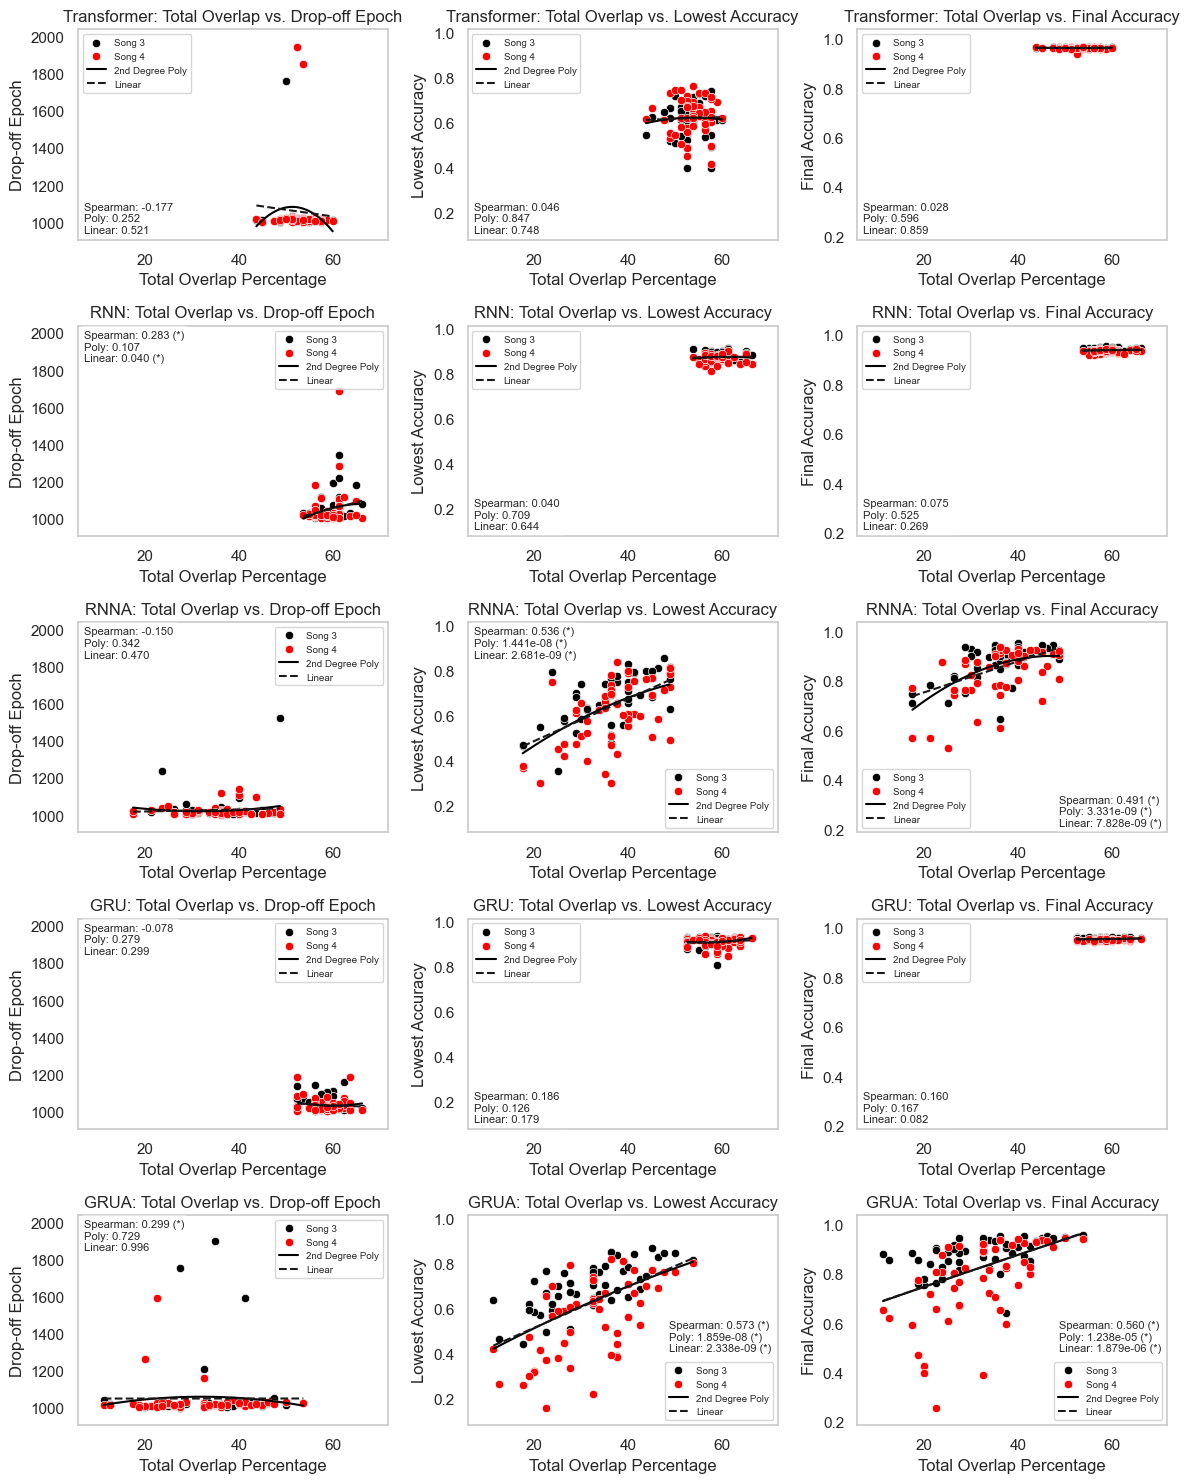

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, f

# Assuming df_model_accuracies_songs_34_merged is already loaded
sns.set(style="whitegrid")

# Define model names
model_names = ["TF", "RNN", "RNNA", "GRU", "GRUA"]

# Set up the figure with subplots - 5 models x 3 metrics
fig, axs = plt.subplots(len(model_names), 3, figsize=(12, 15))  # Adjust size as needed

# Collect global min and max for each axis to standardize axis scales
all_x = []
all_y_epoch = []
all_y_lowest = []
all_y_highest = []

def plot_combined_regression(model, df, x, y, ax, title="", xlabel="", ylabel="", y_values_list=None):
    # Scatter plot for Song 3 and Song 4
    sns.scatterplot(x=x, y=y, data=df[df['Song'] == 3], color='black', ax=ax, label='Song 3')
    sns.scatterplot(x=x, y=y, data=df[df['Song'] == 4], color='red', ax=ax, label='Song 4')
    
    # Extend all data lists for scaling
    all_x.extend(df[x].tolist())
    y_values_list.extend(df[y].tolist())

    # Polynomial and linear regressions
    coeffs_poly = np.polyfit(df[x], df[y], 2)
    poly_eq = np.poly1d(coeffs_poly)
    x_poly = np.linspace(df[x].min(), df[x].max(), 100)
    y_poly = poly_eq(x_poly)
    ax.plot(x_poly, y_poly, color='black', label='2nd Degree Poly')

    coeffs_linear = np.polyfit(df[x], df[y], 1)
    linear_eq = np.poly1d(coeffs_linear)
    y_linear = linear_eq(x_poly)
    ax.plot(x_poly, y_linear, 'k--', label='Linear')
    
    # Calculate R^2 for the polynomial regression
    y_fit_poly = poly_eq(df[x])
    ss_res_poly = np.sum((df[y] - y_fit_poly) ** 2)
    ss_tot_poly = np.sum((df[y] - np.mean(df[y])) ** 2)
    r_squared_poly = 1 - (ss_res_poly / ss_tot_poly)
    
    # Calculate F-statistic and p-value for polynomial regression
    n = len(df[x])
    k_poly = 2  # 2nd degree polynomial has 2 predictors
    df1_poly = k_poly
    df2_poly = n - k_poly - 1
    F_poly = (r_squared_poly / k_poly) / ((1 - r_squared_poly) / df2_poly)
    p_poly = f.sf(F_poly, df1_poly, df2_poly)
    poly_significance = "(*)" if p_poly < 0.05 else ""

    # Calculate R^2 for the linear regression
    y_fit_linear = linear_eq(df[x])
    ss_res_linear = np.sum((df[y] - y_fit_linear) ** 2)
    ss_tot_linear = np.sum((df[y] - np.mean(df[y])) ** 2)
    r_squared_linear = 1 - (ss_res_linear / ss_tot_linear)
    
    # Calculate F-statistic and p-value for linear regression
    k_linear = 1  # Linear regression has 1 predictor
    df1_linear = k_linear
    df2_linear = n - k_linear - 1
    F_linear = (r_squared_linear / k_linear) / ((1 - r_squared_linear) / df2_linear)
    p_linear = f.sf(F_linear, df1_linear, df2_linear)
    linear_significance = "(*)" if p_linear < 0.05 else ""

    # Spearman correlation
    spearman_corr, p_spearman = spearmanr(df[x], df[y])
    spearman_significance = "(*)" if p_spearman < 0.05 else ""
    
    ax.set_title(title, fontsize = 12)
    ax.set_xlabel(xlabel, fontsize = 12)
    ax.set_ylabel(ylabel, fontsize = 12)
    ax.legend(title='', fontsize = 7)

    if model in ['TF'] and y in ['Epoch at Lowest Accuracy', 'Lowest Accuracy', 'Highest Accuracy']:
        text_x = 0.02
        text_y = 0.18
        vertical_align = 'top'
        spearman_corr = f'{spearman_corr:.3f}'
        p_poly= f'{p_poly:.3f}'
        p_linear = f'{p_linear:.3f}'
    elif model in ['RNN', 'GRU'] and y in ['Lowest Accuracy', 'Highest Accuracy']:
        text_x = 0.02
        text_y = 0.18
        vertical_align = 'top'
        spearman_corr = f'{spearman_corr:.3f}'
        p_poly= f'{p_poly:.3f}'
        p_linear = f'{p_linear:.3f}'
    elif model in ['RNNA'] and y in ['Lowest Accuracy']:
        text_x = 0.02
        text_y = 0.98
        vertical_align = 'top'
        spearman_corr = f'{spearman_corr:.3f}'
        p_poly= f'{p_poly:.3e}'
        p_linear = f'{p_linear:.3e}'
    elif model in ['RNNA'] and y in ['Highest Accuracy']:
        text_x = 0.65
        text_y = 0.18
        vertical_align = 'top'
        spearman_corr = f'{spearman_corr:.3f}'
        p_poly= f'{p_poly:.3e}'
        p_linear = f'{p_linear:.3e}'    
    elif model in ['GRUA'] and y in ['Highest Accuracy']:
        text_x = 0.65
        text_y = 0.5
        vertical_align = 'top'
        spearman_corr = f'{spearman_corr:.3f}'
        p_poly= f'{p_poly:.3e}'
        p_linear = f'{p_linear:.3e}' 
    elif model in ['GRUA'] and y in ['Lowest Accuracy']:
        text_x = 0.65
        text_y = 0.5
        vertical_align = 'top'
        spearman_corr = f'{spearman_corr:.3f}'
        p_poly= f'{p_poly:.3e}'
        p_linear = f'{p_linear:.3e}' 
    else:
        text_x = 0.02
        text_y = 0.98
        vertical_align = 'top'
        spearman_corr = f'{spearman_corr:.3f}'
        p_poly= f'{p_poly:.3f}'
        p_linear = f'{p_linear:.3f}'

    ax.text(text_x, text_y, 
            f'Spearman: {spearman_corr} {spearman_significance}\n'
            f'Poly: {p_poly} {poly_significance}\n'
            f'Linear: {p_linear} {linear_significance}', 
            transform=ax.transAxes, verticalalignment=vertical_align, fontsize = 8,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    ax.grid(False)

# Iterate over each model to create plots for combined song 3 and 4 data
for i, model in enumerate(model_names):
    df_filtered = df_model_accuracies_songs_34_merged[(df_model_accuracies_songs_34_merged['Kind'] == model)]
    combined_songs_df = df_filtered[(df_filtered['Song'] == 3) | (df_filtered['Song'] == 4)]
    title = "Transformer" if model == "TF" else f"{model}"

    plot_combined_regression(model, combined_songs_df, 'Total_Overlapp_percentage', 'Epoch at Lowest Accuracy', axs[i, 0], 
                             title=f'{title}: Total Overlap vs. Drop-off Epoch', 
                             xlabel='Total Overlap Percentage', ylabel='Drop-off Epoch',
                             y_values_list=all_y_epoch)
    plot_combined_regression(model, combined_songs_df, 'Total_Overlapp_percentage', 'Lowest Accuracy', axs[i, 1], 
                             title=f'{title}: Total Overlap vs. Lowest Accuracy', 
                             xlabel='Total Overlap Percentage', ylabel='Lowest Accuracy',
                             y_values_list=all_y_lowest)
    plot_combined_regression(model, combined_songs_df, 'Total_Overlapp_percentage', 'Highest Accuracy', axs[i, 2], 
                             title=f'{title}: Total Overlap vs. Final Accuracy', 
                             xlabel='Total Overlap Percentage', ylabel='Final Accuracy',
                             y_values_list=all_y_highest)

# Calculate global x and y limits
x_padding = 0.1 * (max(all_x) - min(all_x))
x_lim = [min(all_x) - x_padding, max(all_x) + x_padding]

# Define function to calculate padded limits
def calculate_padded_limits(values, padding_fraction=0.1):
    range_val = max(values) - min(values)
    padding = padding_fraction * range_val
    return [min(values) - padding, max(values) + padding]

# Apply consistent limits
y_epoch_lim = calculate_padded_limits(all_y_epoch)
y_lowest_lim = calculate_padded_limits(all_y_lowest)
y_highest_lim = calculate_padded_limits(all_y_highest)

for i, ax in enumerate(axs.flat):
    ax.set_xlim(x_lim)
    if i % 3 == 0:
        ax.set_ylim(y_epoch_lim)
    elif i % 3 == 1:
        ax.set_ylim(y_lowest_lim)
    else:
        ax.set_ylim(y_highest_lim)

plt.tight_layout()
plt.savefig(f"./Final-Plots/song_3_4_overlap.pdf")
plt.show()


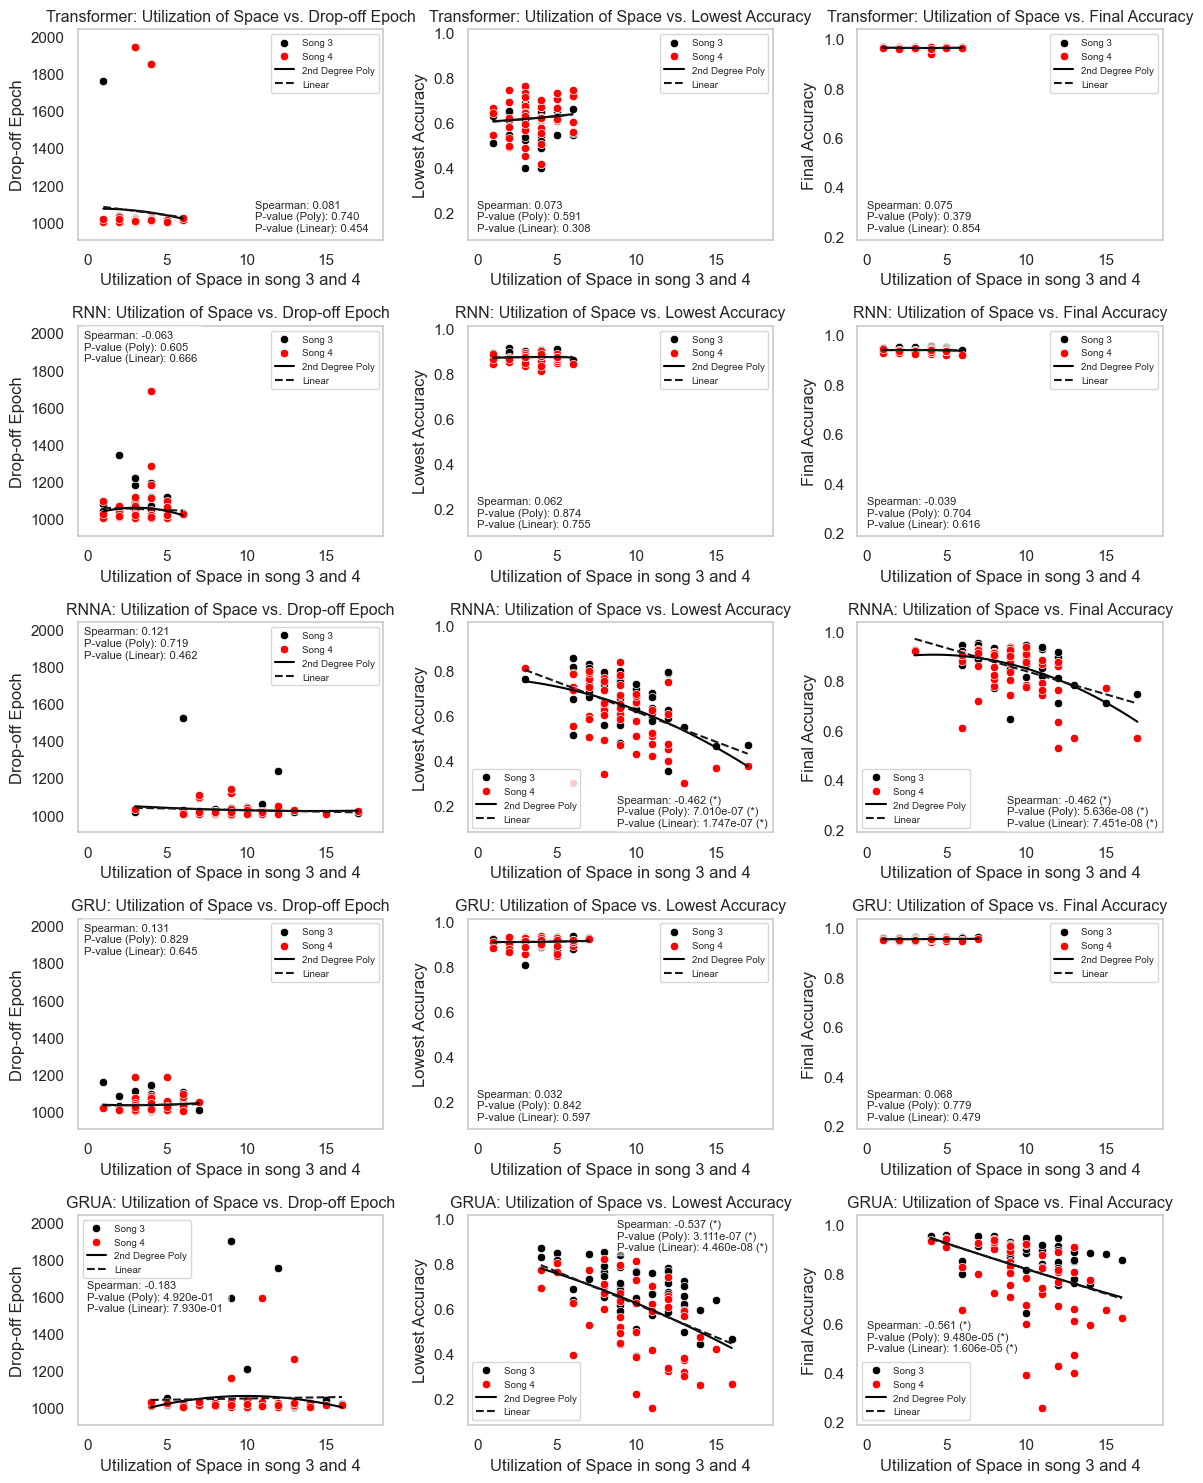

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, f

# Assuming df_model_accuracies_songs_34_merged is already loaded
sns.set(style="whitegrid")

# Define model names
model_names = ["TF", "RNN", "RNNA", "GRU", "GRUA"]

# Set up the figure with subplots - 5 models x 3 metrics
fig, axs = plt.subplots(len(model_names), 3, figsize=(12, 15))  # Adjust size as needed

# Collect global min and max for each axis to standardize axis scales
all_x = []
all_y_epoch = []
all_y_lowest = []
all_y_highest = []

def plot_combined_regression(model, df, x, y, ax, title="", xlabel="", ylabel="", y_values_list=None):
    # Scatter plot for Song 3 and Song 4
    sns.scatterplot(x=x, y=y, data=df[df['Song'] == 3], color='black', ax=ax, label='Song 3')
    sns.scatterplot(x=x, y=y, data=df[df['Song'] == 4], color='red', ax=ax, label='Song 4')
    
    # Extend all data lists for scaling
    all_x.extend(df[x].tolist())
    y_values_list.extend(df[y].tolist())

    # Polynomial and linear regressions
    coeffs_poly = np.polyfit(df[x], df[y], 2)
    poly_eq = np.poly1d(coeffs_poly)
    x_poly = np.linspace(df[x].min(), df[x].max(), 100)
    y_poly = poly_eq(x_poly)
    ax.plot(x_poly, y_poly, color='black', label='2nd Degree Poly')

    coeffs_linear = np.polyfit(df[x], df[y], 1)
    linear_eq = np.poly1d(coeffs_linear)
    y_linear = linear_eq(x_poly)
    ax.plot(x_poly, y_linear, 'k--', label='Linear')
    
    # Calculate R^2 for the polynomial regression
    y_fit_poly = poly_eq(df[x])
    ss_res_poly = np.sum((df[y] - y_fit_poly) ** 2)
    ss_tot_poly = np.sum((df[y] - np.mean(df[y])) ** 2)
    r_squared_poly = 1 - (ss_res_poly / ss_tot_poly)
    
    # Calculate F-statistic and p-value for polynomial regression
    n = len(df[x])
    k_poly = 2  # 2nd degree polynomial has 2 predictors
    df1_poly = k_poly
    df2_poly = n - k_poly - 1
    F_poly = (r_squared_poly / k_poly) / ((1 - r_squared_poly) / df2_poly)
    p_poly = f.sf(F_poly, df1_poly, df2_poly)
    poly_significance = "(*)" if p_poly < 0.05 else ""

    # Calculate R^2 for the linear regression
    y_fit_linear = linear_eq(df[x])
    ss_res_linear = np.sum((df[y] - y_fit_linear) ** 2)
    ss_tot_linear = np.sum((df[y] - np.mean(df[y])) ** 2)
    r_squared_linear = 1 - (ss_res_linear / ss_tot_linear)
    
    # Calculate F-statistic and p-value for linear regression
    k_linear = 1  # Linear regression has 1 predictor
    df1_linear = k_linear
    df2_linear = n - k_linear - 1
    F_linear = (r_squared_linear / k_linear) / ((1 - r_squared_linear) / df2_linear)
    p_linear = f.sf(F_linear, df1_linear, df2_linear)
    linear_significance = "(*)" if p_linear < 0.05 else ""

    # Spearman correlation
    spearman_corr, p_spearman = spearmanr(df[x], df[y])
    spearman_significance = "(*)" if p_spearman < 0.05 else ""
    
    ax.set_title(title, fontsize = 11.5)
    ax.set_xlabel(xlabel, fontsize = 12)
    ax.set_ylabel(ylabel, fontsize = 12)
    ax.legend(title='', fontsize = 7)

    if model in ['TF'] and y in ['Epoch at Lowest Accuracy']:
        text_x = 0.58
        text_y = 0.19
        vertical_align = 'top'
        p_poly = f'{p_poly:.3f}'
        p_linear = f'{p_linear:.3f}'
    elif model in ['TF', 'RNN', 'GRU'] and y in ['Lowest Accuracy', 'Highest Accuracy']:
        text_x = 0.03
        text_y = 0.19
        vertical_align = 'top'
        p_poly = f'{p_poly:.3f}'
        p_linear = f'{p_linear:.3f}'
    elif model in ['RNN', 'GRU'] and y in ['Lowest Accuracy', 'Highest Accuracy']:
        text_x = 0.01
        text_y = 0.1
        vertical_align = 'top'
        p_poly = f'{p_poly:.3f}'
        p_linear = f'{p_linear:.3f}'
    elif model in ['RNNA'] and y in ['Highest Accuracy']:
        text_x = 0.49
        text_y = 0.18
        vertical_align = 'top'
        p_poly = f'{p_poly:.3e}'
        p_linear = f'{p_linear:.3e}'
    elif model in ['GRUA'] and y in ['Lowest Accuracy']:
        text_x = 0.49
        text_y = 0.98
        vertical_align = 'top'
        p_poly = f'{p_poly:.3e}'
        p_linear = f'{p_linear:.3e}'
    elif model in ['GRUA'] and y in ['Epoch at Lowest Accuracy']:
        text_x = 0.03
        text_y = 0.69
        vertical_align = 'top'
        p_poly = f'{p_poly:.3e}'
        p_linear = f'{p_linear:.3e}'
    elif model in ['GRUA'] and y in ['Highest Accuracy']:
        text_x = 0.03
        text_y = 0.5
        vertical_align = 'top'
        p_poly = f'{p_poly:.3e}'
        p_linear = f'{p_linear:.3e}'
    elif model in ['RNNA'] and y in ['Lowest Accuracy']:
        text_x = 0.49
        text_y = 0.18
        vertical_align = 'top'
        p_poly = f'{p_poly:.3e}'
        p_linear = f'{p_linear:.3e}'
    else:
        text_x = 0.02
        text_y = 0.98
        vertical_align = 'top'
        p_poly = f'{p_poly:.3f}'
        p_linear = f'{p_linear:.3f}'
        
    ax.text(text_x, text_y, 
            f'Spearman: {spearman_corr:.3f} {spearman_significance}\n'
            f'P-value (Poly): {p_poly} {poly_significance}\n'
            f'P-value (Linear): {p_linear} {linear_significance}', 
            transform=ax.transAxes, verticalalignment=vertical_align, fontsize = 8,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    ax.grid(False)


# Iterate over each model to create plots for combined song 3 and 4 data
for i, model in enumerate(model_names):
    df_filtered = df_model_accuracies_songs_34_merged[(df_model_accuracies_songs_34_merged['Kind'] == model)]
    combined_songs_df = df_filtered[(df_filtered['Song'] == 3) | (df_filtered['Song'] == 4)]
    title = "Transformer" if model == "TF" else f"{model}"

    plot_combined_regression(model, combined_songs_df, 'count_00_for_songs_34', 'Epoch at Lowest Accuracy', axs[i, 0], 
                             title=f'{title}: Utilization of Space vs. Drop-off Epoch', 
                             xlabel='Utilization of Space in song 3 and 4', ylabel='Drop-off Epoch',
                             y_values_list=all_y_epoch)
    plot_combined_regression(model, combined_songs_df, 'count_00_for_songs_34', 'Lowest Accuracy', axs[i, 1], 
                             title=f'{title}: Utilization of Space vs. Lowest Accuracy', 
                             xlabel='Utilization of Space in song 3 and 4', ylabel='Lowest Accuracy',
                             y_values_list=all_y_lowest)
    plot_combined_regression(model, combined_songs_df, 'count_00_for_songs_34', 'Highest Accuracy', axs[i, 2], 
                             title=f'{title}: Utilization of Space vs. Final Accuracy', 
                             xlabel='Utilization of Space in song 3 and 4', ylabel='Final Accuracy',
                             y_values_list=all_y_highest)

# Calculate global x and y limits
x_padding = 0.1 * (max(all_x) - min(all_x))
x_lim = [min(all_x) - x_padding, max(all_x) + x_padding]

# Define function to calculate padded limits
def calculate_padded_limits(values, padding_fraction=0.1):
    range_val = max(values) - min(values)
    padding = padding_fraction * range_val
    return [min(values) - padding, max(values) + padding]

# Apply consistent limits
y_epoch_lim = calculate_padded_limits(all_y_epoch)
y_lowest_lim = calculate_padded_limits(all_y_lowest)
y_highest_lim = calculate_padded_limits(all_y_highest)

for i, ax in enumerate(axs.flat):
    ax.set_xlim(x_lim)
    if i % 3 == 0:
        ax.set_ylim(y_epoch_lim)
    elif i % 3 == 1:
        ax.set_ylim(y_lowest_lim)
    else:
        ax.set_ylim(y_highest_lim)

plt.tight_layout()
plt.savefig(f"./Final-Plots/song_3_4_empty.pdf")
plt.show()
